In [1]:
import pandas as pd
import matplotlib
import warnings
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import analysis_utils
from copy import deepcopy

# path to repository folder (data is stored here as well)
path = '..'
preds_loc = os.path.join(path, 'data', 'fireprot_mapped_preds_clusters.csv')

# default plotting settings
font = {'size'   : 18}
matplotlib.rc('font', **font)

# notebook display options
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 300

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

In [2]:
# NOTE: The number of bootstrap samples have been greatly reduced to enable a faster demo. Please set them to the values indicated in the text to reproduce the figures.

In [3]:
### load and preprocess data

# load main data
db = pd.read_csv(preds_loc, index_col=0)
db['uid2'] = db['code'] + '_' + db['position'].fillna(-1000000).astype(int).astype(str) + db['mutation']
db = db.reset_index().set_index(['uid', 'uid2'])

# drop locations with no indicated position
#db = db.dropna(subset=['position'])

# uid (specified in preprocessing) is the index for this database
db = db.reset_index()#.rename({'index': 'uid'}, axis=1)

# extract information about data origins
db['ProTherm'] = db['datasets'].apply(lambda x: 'ProTherm' in str(x))
db['FireProt'] = db['datasets'].apply(lambda x: 'FireProt' in str(x))
db['ThermoFluor'] = db['method'].apply(lambda x: 'ThermoFluor' in str(x))

# get only curated mutations for all future analyses
#db = db.loc[db['is_curated']]

# extract ground-truth labels and selected attributes of the data
db_measurements = db.groupby(['uid']).agg({'ddG':'median', 'dTm':'median', 'ProTherm':'max', 'FireProt':'max', 'ThermoFluor':'max', 'code':'first', 'is_curated':'median', 'window_start': 'first'})
print('Number of unique mutations with computed predictions', len(db_measurements))

db_ddg = db_measurements[['ddG']]
db_clusters = db.groupby('uid').first()[['cluster']]
db_training = db.groupby('uid').first()[[c for c in db.columns if 'overlaps' in c]]

db = db.set_index(['uid', 'uid2'])
# use ddG of unfolding so that both dTm and ddG are positive for stabilizing
db_measurements['ddG'] = -db_measurements['ddG']

# extract prediction columns
incl = [col for col in db.columns if '_dir' in col and not 'runtime' in col]
# get only unique mutations (predictions are always the same)
db_preds = db[incl].drop_duplicates()

# extract runtimes for each prediction type
db_runtimes = db[[col for col in db.columns if 'runtime' in col] + ['code']].drop_duplicates()
# estimate the per-mutation runtime (the code takes about 6 seconds to run 6330 mutations)
db_runtimes['runtime_korpm_dir'] = 0.001

# reassign the Tranception runtimes to be per-mutation (by dividing by the number of mutations)
for col in [c for c in db_runtimes.columns if 'tranception' in c]:
    grouped = db_runtimes.groupby('code')[col]
    mean_values = grouped.mean()
    group_sizes = grouped.size()

    # Divide mean values by group sizes
    divided_values = mean_values / group_sizes
    # Merge the divided_values back to the original DataFrame
    db_runtimes = db_runtimes.merge(divided_values.rename('divided_value'), left_on='code', right_index=True)
    # Reassign the 'target_column' values with the divided values
    db_runtimes[col] = db_runtimes['divided_value']
    # Drop the 'divided_value' column
    db_runtimes = db_runtimes.drop('divided_value', axis=1)

# load effective number of sequences from separate file (generated by MSA transformer)
neff = pd.read_csv(os.path.join(path, 'data', 'neff_fireprot.csv'), header=None).set_index(0)
neff.index.name = 'code'
neff.columns = ['neff', 'sequence_length']
neff = neff.groupby(level=0).max()
neff = neff[['neff']]

# drop any NaN columns
db_preds = db_preds.dropna(how='all', axis=1)

# output a glimpse of the dataframe
db_preds

# ~15 seconds

Number of unique mutations with computed predictions 6455


mpnn_10_00_dir  mpnn_20_00_dir  mpnn_30_00_dir   mif_dir  \
uid       uid2                                                                  
1A23_170A 1A23_151A       -4.949540       -5.244984       -5.672250 -5.430375   
1A23_49S  1A23_30S         2.077144        2.085694       -1.302507  1.864485   
1A23_51L  1A23_32L         0.228933        2.368069       -0.227686  1.119251   
1A23_51S  1A23_32S         0.456958        0.988697        0.862586 -0.854073   
1A23_51Y  1A23_32Y        -0.185157        0.708840        0.176705  1.528646   
...                             ...             ...             ...       ...   
6TQ3_97A  6TQ3_91A         1.426476        1.061871       -0.051376  1.937819   
6TQ3_97K  6TQ3_91K        -1.633844       -1.412267       -0.688994 -3.846951   
6TQ3_9P   6TQ3_3P          1.479089        0.600413        1.845578  1.529709   
8TIM_179A 8TIM_178A       -0.048543        0.312612       -0.108129  1.211097   
8TIM_193A 8TIM_192A        0.275487        2.610600        1.680574 -0.412504   

                     mifst_dir  esmif_monomer_dir  pll_esmif_monomer_dir  \
uid       uid2                                                             
1A23_170A 1A23_151A  -9.428463          -0.058681               6.139080   
1A23_49S  1A23_30S   -6.805952          -0.043713               6.139080   
1A23_51L  1A23_32L   -7.800102          -0.042389               6.139080   
1A23_51S  1A23_32S   -5.414868          -0.029983               6.139080   
1A23_51Y  1A23_32Y   -3.414633          -0.020219               6.139080   
...                        ...                ...                    ...   
6TQ3_97A  6TQ3_91A   -0.323130           0.005651               2.714652   
6TQ3_97K  6TQ3_91K   -6.354403          -0.015521               2.714652   
6TQ3_9P   6TQ3_3P     1.332036          -0.012842               2.714652   
8TIM_179A 8TIM_178A   1.235412           0.004287               2.813355   
8TIM_193A 8TIM_192A  -3.617151          -0.005032               2.813355   

                      esm2_dir  esm2_15B_half_dir  esmif_multimer_dir  ...  \
uid       uid2                                                         ...   
1A23_170A 1A23_151A -11.686458         -11.403809           -0.058681  ...   
1A23_49S  1A23_30S  -11.571676         -11.668701           -0.043712  ...   
1A23_51L  1A23_32L  -13.755667         -13.076172           -0.042389  ...   
1A23_51S  1A23_32S   -8.291791         -10.436035           -0.029983  ...   
1A23_51Y  1A23_32Y   -8.121881          -9.415039           -0.020220  ...   
...                        ...                ...                 ...  ...   
6TQ3_97A  6TQ3_91A    2.301441           2.237305            0.004414  ...   
6TQ3_97K  6TQ3_91K   -4.896001          -5.344726           -0.009634  ...   
6TQ3_9P   6TQ3_3P    -1.533729          -2.478516           -0.012137  ...   
8TIM_179A 8TIM_178A   0.568380          -0.851563            0.004968  ...   
8TIM_193A 8TIM_192A  -0.143130          -1.933594           -0.004131  ...   

                     msa_1_dir  msa_2_dir  msa_3_dir  msa_4_dir  msa_5_dir  \
uid       uid2                                                               
1A23_170A 1A23_151A -10.461273 -10.524462 -10.200914  -9.968088  -9.629943   
1A23_49S  1A23_30S   -8.661992  -7.024451  -8.284982  -8.104036  -8.652328   
1A23_51L  1A23_32L   -8.351897  -8.603205  -7.569136  -6.636557  -5.979207   
1A23_51S  1A23_32S   -6.135631  -6.917473  -5.214984  -4.093250   1.022389   
1A23_51Y  1A23_32Y   -4.844220  -5.309464  -3.828758  -3.489320  -2.578021   
...                        ...        ...        ...        ...        ...   
6TQ3_97A  6TQ3_91A    1.135963   0.554072   0.873857   0.864542   0.749370   
6TQ3_97K  6TQ3_91K   -4.162602  -4.975087  -3.478955  -4.468427  -3.621313   
6TQ3_9P   6TQ3_3P    -3.012066   0.437413   0.182471  -1.150957   0.787802   
8TIM_179A 8TIM_178A   0.285256   0.129107   0.090587  -2.995776   1.429789   
8TIM_193A 8TIM_192A  -1.756

In [4]:
# extract existing features from FireProtDB
feats = ['asa', 'b_factor', 'conservation', 
       'interpro_families', 'is_back_to_consensus', 'is_curated',
       'is_essential', 'is_in_catalytic_pocket', 'is_in_tunnel_bottleneck',
       'method', 'pH', 'secondary_structure', 'tm', 'is_nmr']

# get only unique mutations
db_feats = db[feats]#.drop_duplicates()
# deduplicate (features stay the same)
mask = ~db_feats.index.duplicated(keep='first')
db_feats = db_feats[mask]

# load features generated by preprocessing/compute_features.py
db_feats_2 = pd.read_csv(os.path.join(path, 'data', 'fireprot_local_mapped_feats.csv'))

# preprocess raw features
db_feats_2['uid'] = db_feats_2['code'] + '_' + (db_feats_2['position'].fillna(-10000000) - db_feats_2['offset_up'].fillna(-10000000)).astype(int).astype(str) + db_feats_2['mutation']
db_feats_2 = db_feats_2.set_index('uid')

db_feats_2 = db_feats_2[[
       'code', 'wild_type', 'mutation', 'on_interface', 'entropy', 
       'conservation', 'column_completeness', 'completeness_score', 'n_seqs', 
       'structure_length', 'sequence_length','multimer', 'SS','features', 
       'hbonds', 'saltbrs', 'kdh_wt', 'kdh_mut', 'vol_wt', 
       'vol_mut', 'chg_wt', 'chg_mut', 'rel_ASA', #'residue_depth',
       ]]

# combine generated features with features provided by FireProt authors
db_feats_2 = db_feats_2.join(db_feats.reset_index('uid2').drop(['conservation', 'is_curated'], axis=1), how='inner')

# derived from SwissProt
db_feats_2['on_interface'] = db_feats_2['on_interface']#.astype(int)
db_feats_2['features'] = db_feats_2['features'].fillna("")
db_feats_2['binding'] = db_feats_2['features'].str.contains('BINDING')
db_feats_2['active_site'] = db_feats_2['features'].str.contains('ACT_SITE')

# change in physicochemical features
db_feats_2['delta_kdh'] = db_feats_2['kdh_mut'] - db_feats_2['kdh_wt']
db_feats_2['delta_vol'] = db_feats_2['vol_mut'] - db_feats_2['vol_wt']
db_feats_2['delta_chg'] = db_feats_2['chg_mut'] - db_feats_2['chg_wt']

db_feats_2['delta_kdh_dir'] = db_feats_2['kdh_mut'] - db_feats_2['kdh_wt']
db_feats_2['delta_vol_dir'] = db_feats_2['vol_mut'] - db_feats_2['vol_wt']
db_feats_2['delta_chg_dir'] = db_feats_2['chg_mut'] - db_feats_2['chg_wt']
db_feats_2['rel_ASA_dir'] = db_feats_2['rel_ASA']

# unusual / important identities
db_feats_2['to_proline'] = db_feats_2['mutation'] == 'P'
db_feats_2['to_glycine'] = db_feats_2['mutation'] == 'G'
db_feats_2['from_proline'] = db_feats_2['wild_type'] == 'P'
db_feats_2['from_glycine'] = db_feats_2['wild_type'] == 'G'
db_feats_2['to_alanine'] = db_feats_2['mutation'] == 'A'

# secondary structure
db_feats_2['helix'] = db_feats_2['SS'] == 'H'
db_feats_2['bend'] = db_feats_2['SS'] == 'S'
db_feats_2['turn'] = db_feats_2['SS'] == 'T'
db_feats_2['coil'] = db_feats_2['SS'] == '-'
db_feats_2['strand'] = db_feats_2['SS'] == 'E'

# drop raw features
db_feats_2 = db_feats_2.drop([
       'kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 
       'features', 'SS', 'wild_type', 'mutation'
       ], axis=1)

# combine feature information from remaining sources
db_feats_2 = db_feats_2.reset_index().merge(neff, on='code', how='left').drop('code', axis=1).set_index('uid')
db_feats_2 = db_feats_2.join(db_measurements[['ProTherm', 'FireProt', 'is_curated', 'ThermoFluor']])
print(len(db_feats_2))
#db_feats_2['ProTherm']

6330


In [5]:
original_feat_cols = ['entropy', 'column_completeness', 'structure_length',
       'multimer', 'hbonds', 'saltbrs', 'rel_ASA', 'asa', 'b_factor',
       'pH', 'tm', 'is_nmr', 'delta_kdh', 'delta_vol', 'delta_chg', 'to_proline', 'to_glycine',
       'from_proline', 'from_glycine', 'to_alanine', 'helix', 'bend', 'turn',
       'coil', 'strand', 'neff']
db_feats_2.columns

Index(['on_interface', 'entropy', 'conservation', 'column_completeness',
       'completeness_score', 'n_seqs', 'structure_length', 'sequence_length',
       'multimer', 'hbonds', 'saltbrs', 'rel_ASA', 'uid2', 'asa', 'b_factor',
       'interpro_families', 'is_back_to_consensus', 'is_essential',
       'is_in_catalytic_pocket', 'is_in_tunnel_bottleneck', 'method', 'pH',
       'secondary_structure', 'tm', 'is_nmr', 'binding', 'active_site',
       'delta_kdh', 'delta_vol', 'delta_chg', 'delta_kdh_dir', 'delta_vol_dir',
       'delta_chg_dir', 'rel_ASA_dir', 'to_proline', 'to_glycine',
       'from_proline', 'from_glycine', 'to_alanine', 'helix', 'bend', 'turn',
       'coil', 'strand', 'neff', 'ProTherm', 'FireProt', 'is_curated',
       'ThermoFluor'],
      dtype='object')

In [6]:
db_runtimes

runtime_mpnn_10_00_dir  runtime_mpnn_20_00_dir  \
uid       uid2                                                        
1A23_170A 1A23_151A                0.781902                0.548272   
1A23_49S  1A23_30S                 0.008106                0.008040   
1A23_51L  1A23_32L                 0.007963                0.007847   
1A23_51S  1A23_32S                 0.007918                0.007789   
1A23_51Y  1A23_32Y                 0.007978                0.007781   
...                                     ...                     ...   
6TQ3_97A  6TQ3_91A                 0.016137                0.016049   
6TQ3_97K  6TQ3_91K                 0.016040                0.016085   
6TQ3_9P   6TQ3_3P                  0.016012                0.016075   
8TIM_179A 8TIM_178A                0.010677                0.010679   
8TIM_193A 8TIM_192A                0.010593                0.010649   

                     runtime_mpnn_30_00_dir  runtime_mif_dir  \
uid       uid2                                                 
1A23_170A 1A23_151A                0.554410         0.760198   
1A23_49S  1A23_30S                 0.008107         0.015999   
1A23_51L  1A23_32L                 0.007868         0.012534   
1A23_51S  1A23_32S                 0.007862         0.012525   
1A23_51Y  1A23_32Y                 0.007869         0.012143   
...                                     ...              ...   
6TQ3_97A  6TQ3_91A                 0.015954         0.013692   
6TQ3_97K  6TQ3_91K                 0.016007         0.013720   
6TQ3_9P   6TQ3_3P                  0.015980         0.013628   
8TIM_179A 8TIM_178A                0.010566         0.015378   
8TIM_193A 8TIM_192A                0.010620         0.014291   

                     runtime_mifst_dir  runtime_esmif_monomer_dir  \
uid       uid2                                                      
1A23_170A 1A23_151A           0.856311                   0.151037   
1A23_49S  1A23_30S            0.076028                   0.149973   
1A23_51L  1A23_32L            0.034749                   0.149707   
1A23_51S  1A23_32S            0.082075                   0.149462   
1A23_51Y  1A23_32Y            0.034016                   0.149789   
...                                ...                        ...   
6TQ3_97A  6TQ3_91A            0.033327                   0.183151   
6TQ3_97K  6TQ3_91K            0.033267                   0.183232   
6TQ3_9P   6TQ3_3P             0.034543                   0.183713   
8TIM_179A 8TIM_178A           0.041601                   0.187125   
8TIM_193A 8TIM_192A           0.036839                   0.187171   

                     runtime_esm2_dir  runtime_esm2_15B_half_dir  \
uid       uid2                                                     
1A23_170A 1A23_151A          0.709385                   0.875595   
1A23_49S  1A23_30S           0.107006                   0.056062   
1A23_51L  1A23_32L           0.106752                   0.055940   
1A23_51S  1A23_32S           0.106986                   0.055990   
1A23_51Y  1A23_32Y           0.106735                   0.055922   
...                               ...                        ...   
6TQ3_97A  6TQ3_91A           0.106890                   0.057971   
6TQ3_97K  6TQ3_91K           0.106873                   0.058007   
6TQ3_9P   6TQ3_3P            0.106883                   0.057877   
8TIM_179A 8TIM_178A          0.107792                   0.059419   
8TIM_193A 8TIM_192A          0.107036                   0.058351   

                     runtime_esmif_multimer_dir  runtime_tranception_dir  ...  \
uid       uid2                                                            ...   
1A23_170A 1A23_151A                    0.150321                 4.196386  ...   
1A23_49S  1A23_30S                     0.150003                 4.196386  ...   
1A23_51L  1A23_32L                     0.150425                 4.196386  ...   
1A23_51S  1A23_32S                     0.150352                 4.196386  ..

In [7]:
#db.reset_index('uid', drop=True).reset_index().rename({'uid2': 'uid'}, axis=1).set_index('uid')
# Get predictions from Rosetta (included in repo)
# assuming you have designated the repo location as the path
df_cart, df_cart_runtimes = analysis_utils.parse_rosetta_predictions(db.reset_index('uid', drop=True).reset_index().rename({'uid2': 'uid'}, axis=1).set_index('uid'), os.path.join(path, 'data', 'rosetta_predictions'), runtime=True)
db_preds = db_preds.reset_index().rename({'uid': 'uid_', 'uid2': 'uid'}, axis=1).set_index('uid').join(df_cart.astype(float).rename_axis('uid'), how='left')
db_preds = db_preds.reset_index(drop=True).rename({'uid_': 'uid'}, axis=1).set_index('uid')
db_runtimes = db_runtimes.reset_index().rename({'uid': 'uid_', 'uid2': 'uid'}, axis=1).set_index('uid').join(df_cart_runtimes.astype(float).rename_axis('uid'), how='left')
db_runtimes = db_runtimes.reset_index(drop=True).rename({'uid_': 'uid'}, axis=1).set_index('uid')

# ~25 seconds on SSD, 5 minutes on HDD

Could not find predictions for 1AJ3_-1000000A
Could not find predictions for 1AJ3_-1000000E
Could not find predictions for 1AJ3_-1000000F
Could not find predictions for 1AJ3_-1000000G
Could not find predictions for 1AJ3_-1000000K
Could not find predictions for 1AJ3_-1000000L
Could not find predictions for 1AJ3_-1000000V
Could not find predictions for 1AJ3_-1000000Y
Could not find predictions for 1DPM_257L
Could not find predictions for 1E21_-1000000A
Could not find predictions for 1HYN_-1000000K
Could not find predictions for 1PGA_-1000000F
Could not find predictions for 1PGA_-1000000I
Could not find predictions for 1PGA_-1000000V
Could not find predictions for 1PGA_-1000000Y
Could not find predictions for 1PIN_-1000000A
Could not find predictions for 1PIN_-1000000G
Could not find predictions for 1QLP_-1000000I
Could not find predictions for 1QLP_-1000000L
Could not find predictions for 1QLP_-1000000P
Could not find predictions for 1QLP_-1000000V
Could not find predictions for 1STN_-10

Original unique mutations: 6455
Dropped 301 interface mutations
Unique mutations in chosen set: 5754
Unique clusters (protein families with significant structural homology): 68


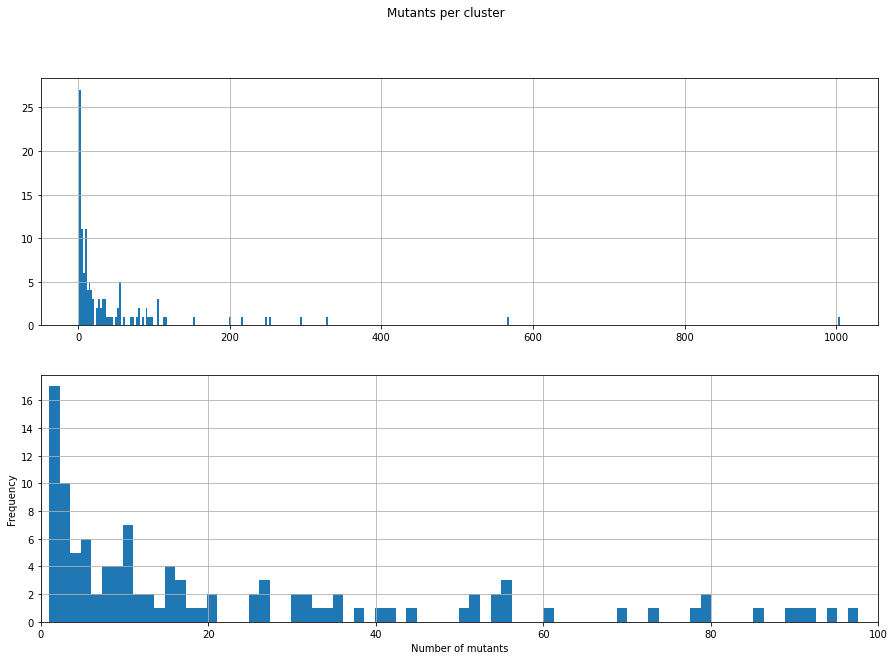

In [8]:
# compile predictions and measurements for statistical analysis
db_class = db_preds.join(db_measurements).drop('code', axis=1).join(db_clusters) #.join(db_runtimes.drop('code', axis=1))
print('Original unique mutations:', len(db_class))

# can uncomment to look at non-ProTherm or Curated mutaions
#db_class = db_class.loc[~db_class['ProTherm'].astype(bool)]
#db_class = db_class.loc[~(db_class.index.str[:4]=='1PGA')]
#db_class = db_class.loc[db_class['is_curated'].astype(bool)]

# dropna from korpm 
db_class = db_class.dropna(subset='cartesian_ddg_dir')
#print('Unique mutations after dropping NA for Rosetta:', len(db_class))

# don't drop missing predictions from sequence-based models because we want the 
# most complete comparison of the focal inverse-folding and traditional models
#db_class = db_class.dropna(subset='msa_transformer_mean_dir')
#print(len(db_class))

original_pred_cols = [c for c in db_class.columns if '_dir' in c and not 'runtime' in c and not 'pll' in c]
original_pred_cols_reduced = deepcopy(original_pred_cols)
for col in [f'esm1v_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
for col in [f'msa_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)

db_class['ddG_dir'] = db_class['ddG']
db_class['dTm_dir'] = db_class['dTm']

evolutionary = ['tranception', 'msa_transformer', 'esm1v', 'msa', 'esm2', 'ankh']
structural = ['mpnn', 'mif', 'mifst', 'esmif']
supervised = ['cartesian_ddg', 'korpm']

db_class_rescaled = db_class.copy(deep=True)
db_class_rescaled[original_pred_cols] /= db_class_rescaled[original_pred_cols].std()

db_class['structural_dir'] = db_class_rescaled[[c for c in db_class.columns if any([s in c for s in structural])]].mean(axis=1)
db_class['evolutionary_dir'] = db_class_rescaled[[c for c in db_class.columns if any([s in c for s in evolutionary])]].mean(axis=1)
db_class['supervised_dir'] = db_class_rescaled[[c for c in db_class.columns if any([s in c for s in supervised])]].mean(axis=1)
db_class['clustered_ensemble_dir'] = db_class[['supervised_dir', 'structural_dir', 'evolutionary_dir']].mean(axis=1)

db_class['mpnn_rosetta_dir'] = db_class['cartesian_ddg_dir'] + db_class['mpnn_20_00_dir']

db_class['mpnn_mean_dir'] = db_class[['mpnn_10_00_dir', 'mpnn_20_00_dir', 'mpnn_30_00_dir']].mean(axis=1)
db_runtimes['runtime_mpnn_mean_dir'] = db_runtimes[['runtime_mpnn_10_00_dir', 'runtime_mpnn_20_00_dir', 'runtime_mpnn_30_00_dir']].sum(axis=1)

db_class['esmif_mean_dir'] = db_class[['esmif_multimer_dir', 'esmif_monomer_dir']].mean(axis=1)
db_runtimes['runtime_esmif_mean_dir'] = db_runtimes[['runtime_esmif_multimer_dir', 'runtime_esmif_monomer_dir']].sum(axis=1)

db_class['mif_mean_dir'] = db_class[['mif_dir', 'mifst_dir']].mean(axis=1)
db_runtimes['runtime_mif_mean_dir'] = db_runtimes[['runtime_mif_dir', 'runtime_mifst_dir']].sum(axis=1)

db_class['esm2_mean_dir'] = db_class[['esm2_15B_half_dir', 'esm2_dir', 'esm2_650M_dir', 'esm2_150M_dir']].mean(axis=1)
db_runtimes['runtime_esm2_mean_dir'] = db_runtimes[['runtime_esm2_15B_half_dir', 'runtime_esm2_dir', 'runtime_esm2_650M_dir', 'runtime_esm2_150M_dir']].sum(axis=1)

#db_class['ensemble_dir'] = db_class['cartesian_ddg_dir'] + db_class['mpnn_20_00_dir']
# random (Gaussian noise) control
db_class['random_dir'] = np.random.normal(loc=0, size=len(db_class))

#db_class = db_class.reset_index('uid2', drop=True)

fig, axes = plt.subplots(2, figsize=(15, 10)) 
db_class.groupby('cluster').count().iloc[:, 0].hist(bins=400, ax=axes[0])
db_class.groupby('cluster').count().iloc[:, 0].hist(bins=800, ax=axes[1])
plt.xlim([0,100])
plt.suptitle('Mutants per cluster')
plt.xlabel('Number of mutants')
plt.ylabel('Frequency')

group_counts = db_class.groupby('cluster').count().iloc[:, 0]
large_groups = group_counts > 10
filtered_df = db_class[db_class['cluster'].isin(large_groups[large_groups].index)]
db_class = filtered_df

l1 = len(db_class)
db_class = db_class.loc[~db_feats_2['on_interface']]
l2 = len(db_class)
print(f'Dropped {l1-l2} interface mutations')
#db_class = db_class.loc[~db_feats_2['on_interface']]
#print(f'Dropped {l2-len(db_class)} mutations in binding regions')

db_class

print('Unique mutations in chosen set:', len(db_class))
print('Unique clusters (protein families with significant structural homology):', len(db_class['cluster'].unique()))

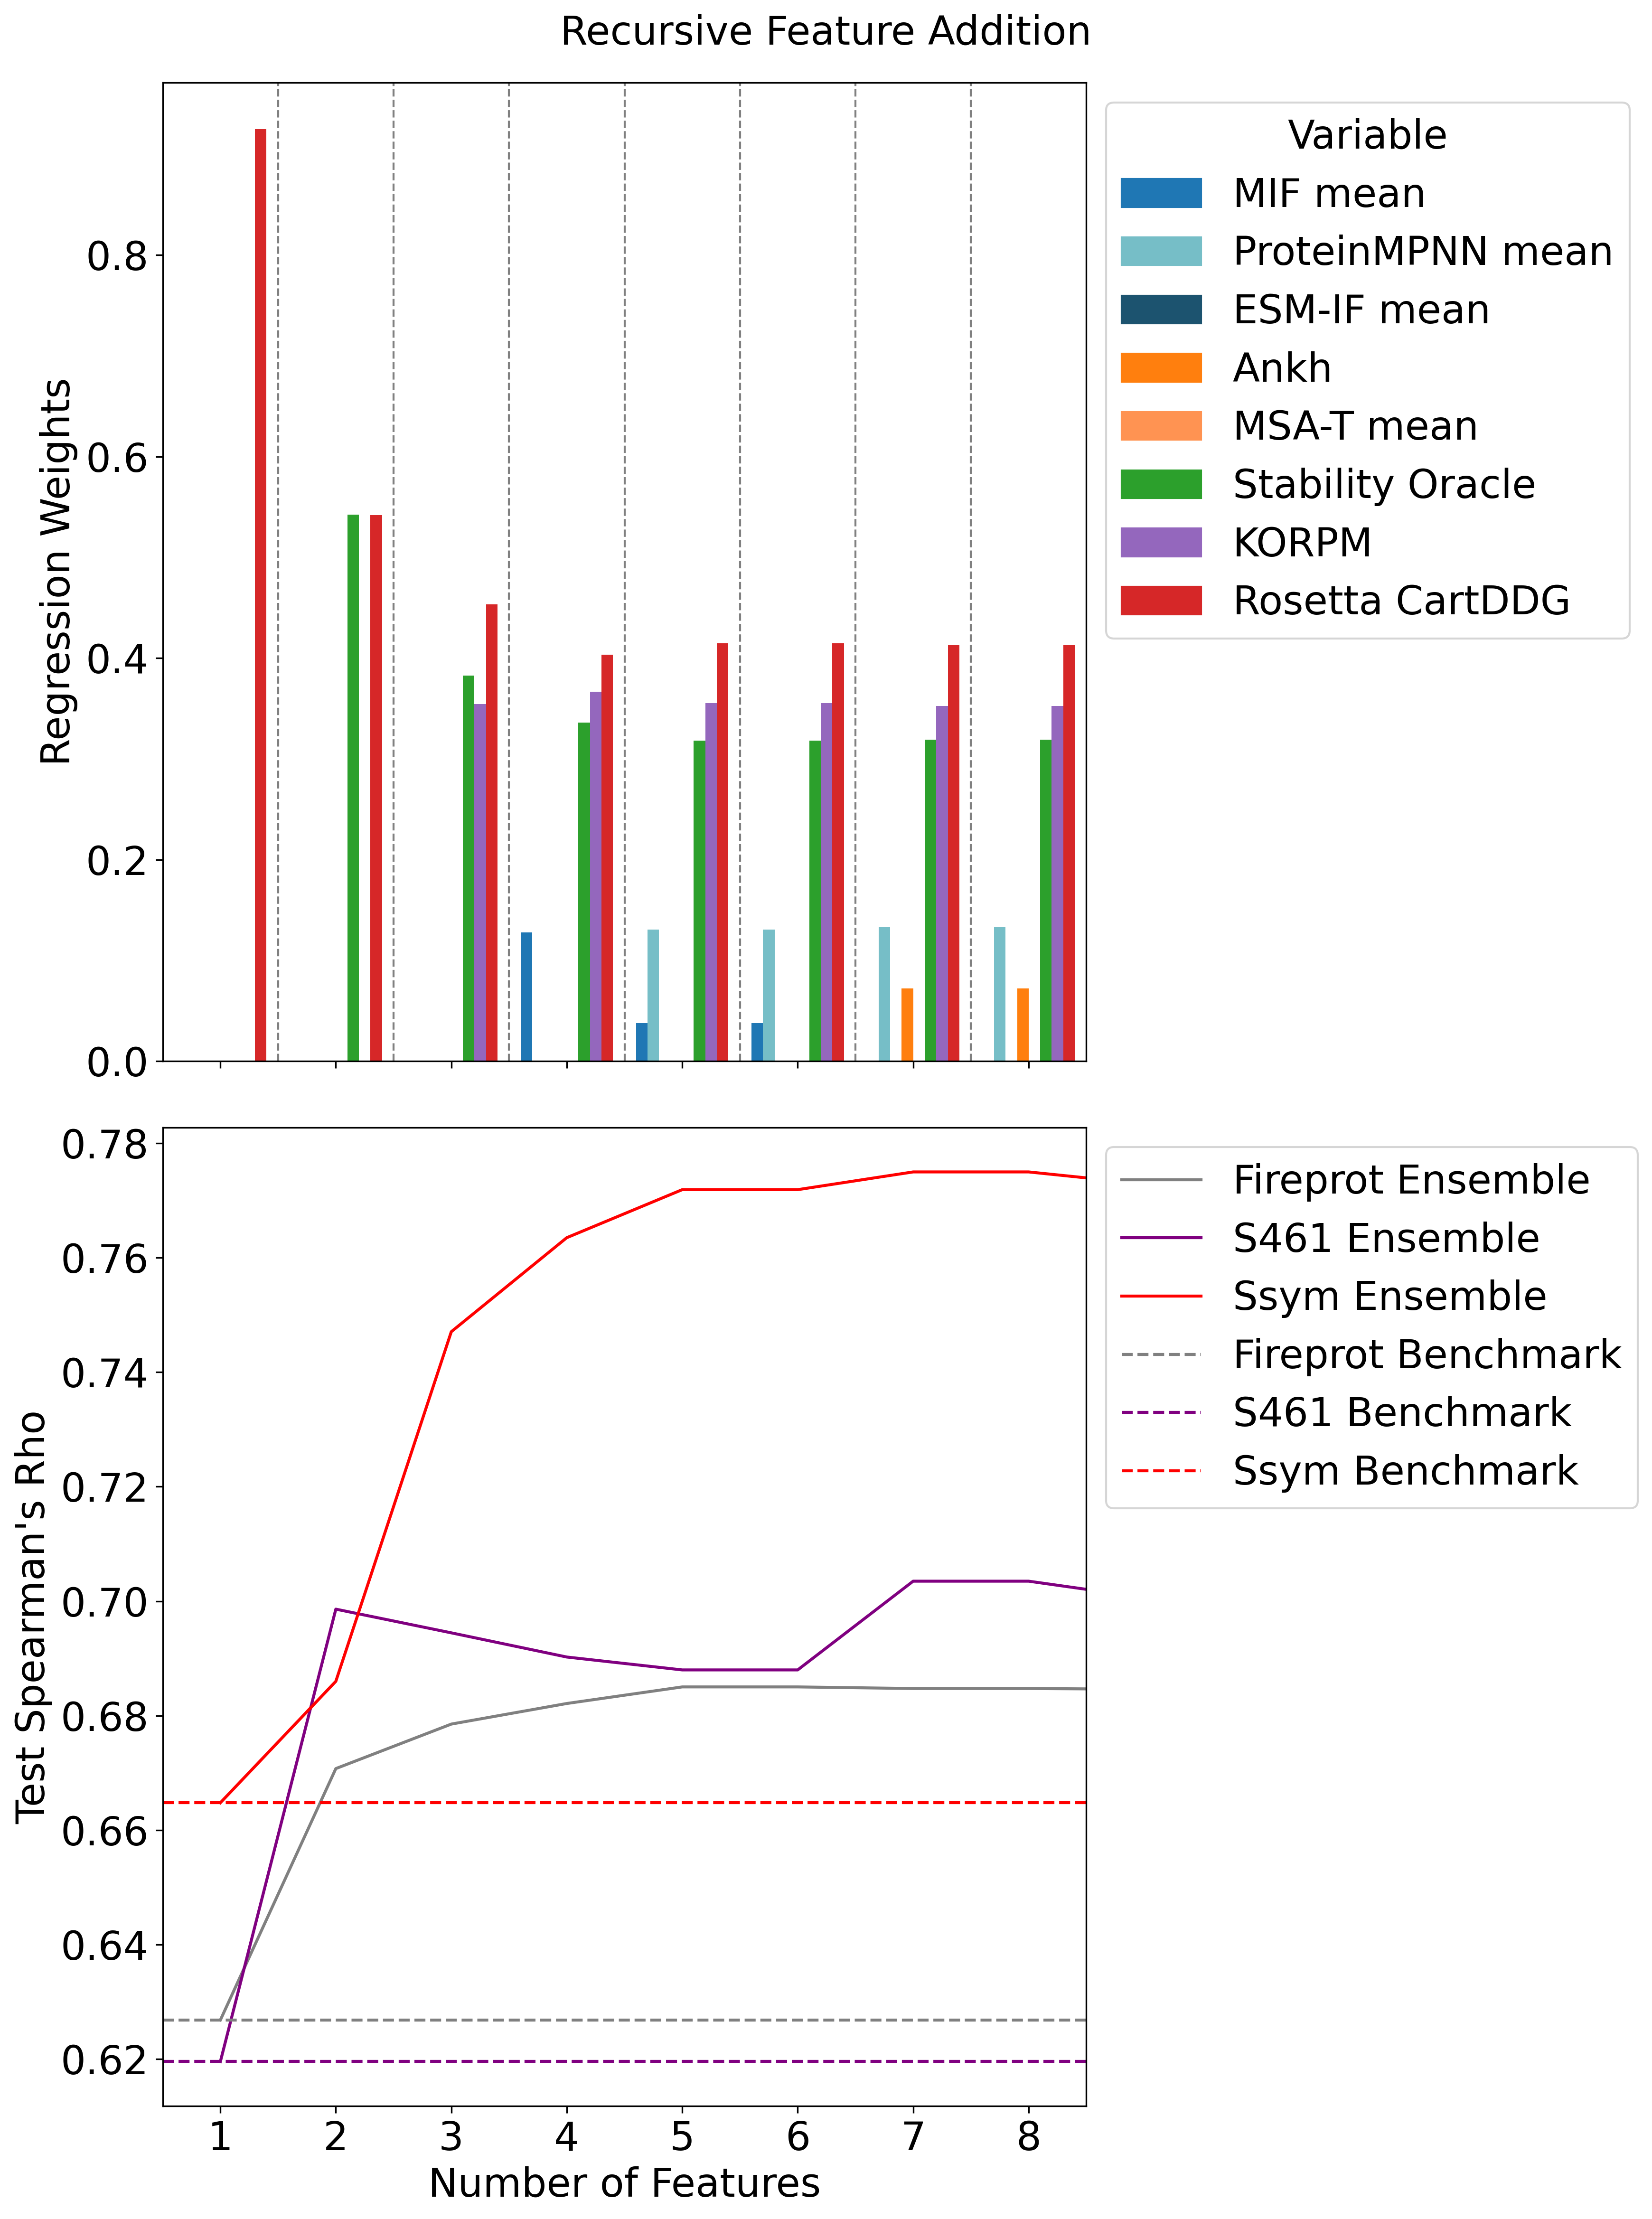

In [26]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
import importlib
importlib.reload(analysis_utils)

cols2 = ['cartesian_ddg_dir', 'korpm_dir', 'stability-oracle_dir', 'esmif_mean_dir', 'mpnn_mean_dir', 'mif_mean_dir', 'msa_transformer_mean_dir', 'esm2_mean_dir', 'ankh_dir', 'tranception_dir']
df_train = db_class.drop('cluster', axis=1).join(db_feats_2[[c for c in db_feats_2.columns if c in cols2]]).join(db_training).dropna(subset=['ddG_dir', 'stability-oracle_dir'])
#df_train = df_train.loc[~df_train['Ssym_cluster']].loc[~df_train['s461_cluster']]
df_train[['overlaps_Ssym', 'overlaps_s461']] = df_train[['overlaps_Ssym', 'overlaps_s461']].fillna(False)
df_train = df_train.loc[~df_train['overlaps_Ssym']].loc[~df_train['overlaps_s461']]
df_test = db_class.drop('cluster', axis=1).join(db_feats_2[[c for c in db_feats_2.columns if c in cols2]]).join(db_training).dropna(subset=['ddG_dir', 'stability-oracle_dir']).drop(['ProTherm', 'ddG'], axis=1).fillna(0)
df_test_s461 = pd.read_csv(os.path.join(path, 'data', 's461_mapped_preds_clusters_extra.csv')).set_index('uid')
df_test_s461 = df_test_s461[[c for c in df_test_s461.columns if not 'q3421' in c and not 'rfa' in c]]
df_test_ssym = pd.read_csv(os.path.join(path, 'data', 'Ssym_mapped_preds_clusters_extra.csv')).set_index('uid')
df_test_ssym = df_test_ssym[[c for c in df_test_ssym.columns if not 'q3421' in c and not 'rfa' in c]]
df_test_ssym.columns = [c+'_dir' for c in df_test_ssym.columns]


dfs_test = {'fireprot': df_test, 's461': df_test_s461, 'ssym': df_test_ssym}

test_scores, weights_df, dfs_test = analysis_utils.custom_recursive_feature_addition(df_train, dfs_test, cols2, 'ddG_dir', LinearRegression(positive=True), fillna=True, source='fireprot_all')

df_test_s461 = dfs_test['s461']
df_test_s461 = df_test_s461.rename(dict(zip([c for c in df_test_s461.columns if 'rfa' in c], [c+'_dir' for c in df_test_s461.columns if 'rfa' in c])), axis=1)
df_test_s461.to_csv(os.path.join(path, 'data', 's461_mapped_preds_clusters_extra.csv'))

df_test_ssym = dfs_test['ssym']
df_test_ssym = df_test_ssym.rename(dict(zip([c for c in df_test_ssym.columns if '_dir' in c], [c[:-4] for c in df_test_ssym.columns if '_dir' in c])), axis=1)
df_test_ssym.to_csv(os.path.join(path, 'data', 'Ssym_mapped_preds_clusters_extra.csv'))

{'delta_vol_dir': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), 'rel_ASA_dir': (0.682174384230626, 0.6444769162185522, 0.5821661809652482), 'delta_kdh_dir': (0.31418358668930785, 0.3894735102156965, 0.3822451953221524), 'mpnn_20_00_dir': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'mifst_dir': (0.3776063009757435, 0.6432273200048375, 0.7903389193467517), 'mutcomputex_dir': (0.03147810209830959, 0.2400316581570392, 0.48263179833846426), 'esmif_multimer_dir': (0.612853888397293, 0.7969174447543321, 0.795099487048795), 'tranception_dir': (1.0, 0.4980392156862745, 0.054901960784313725)}


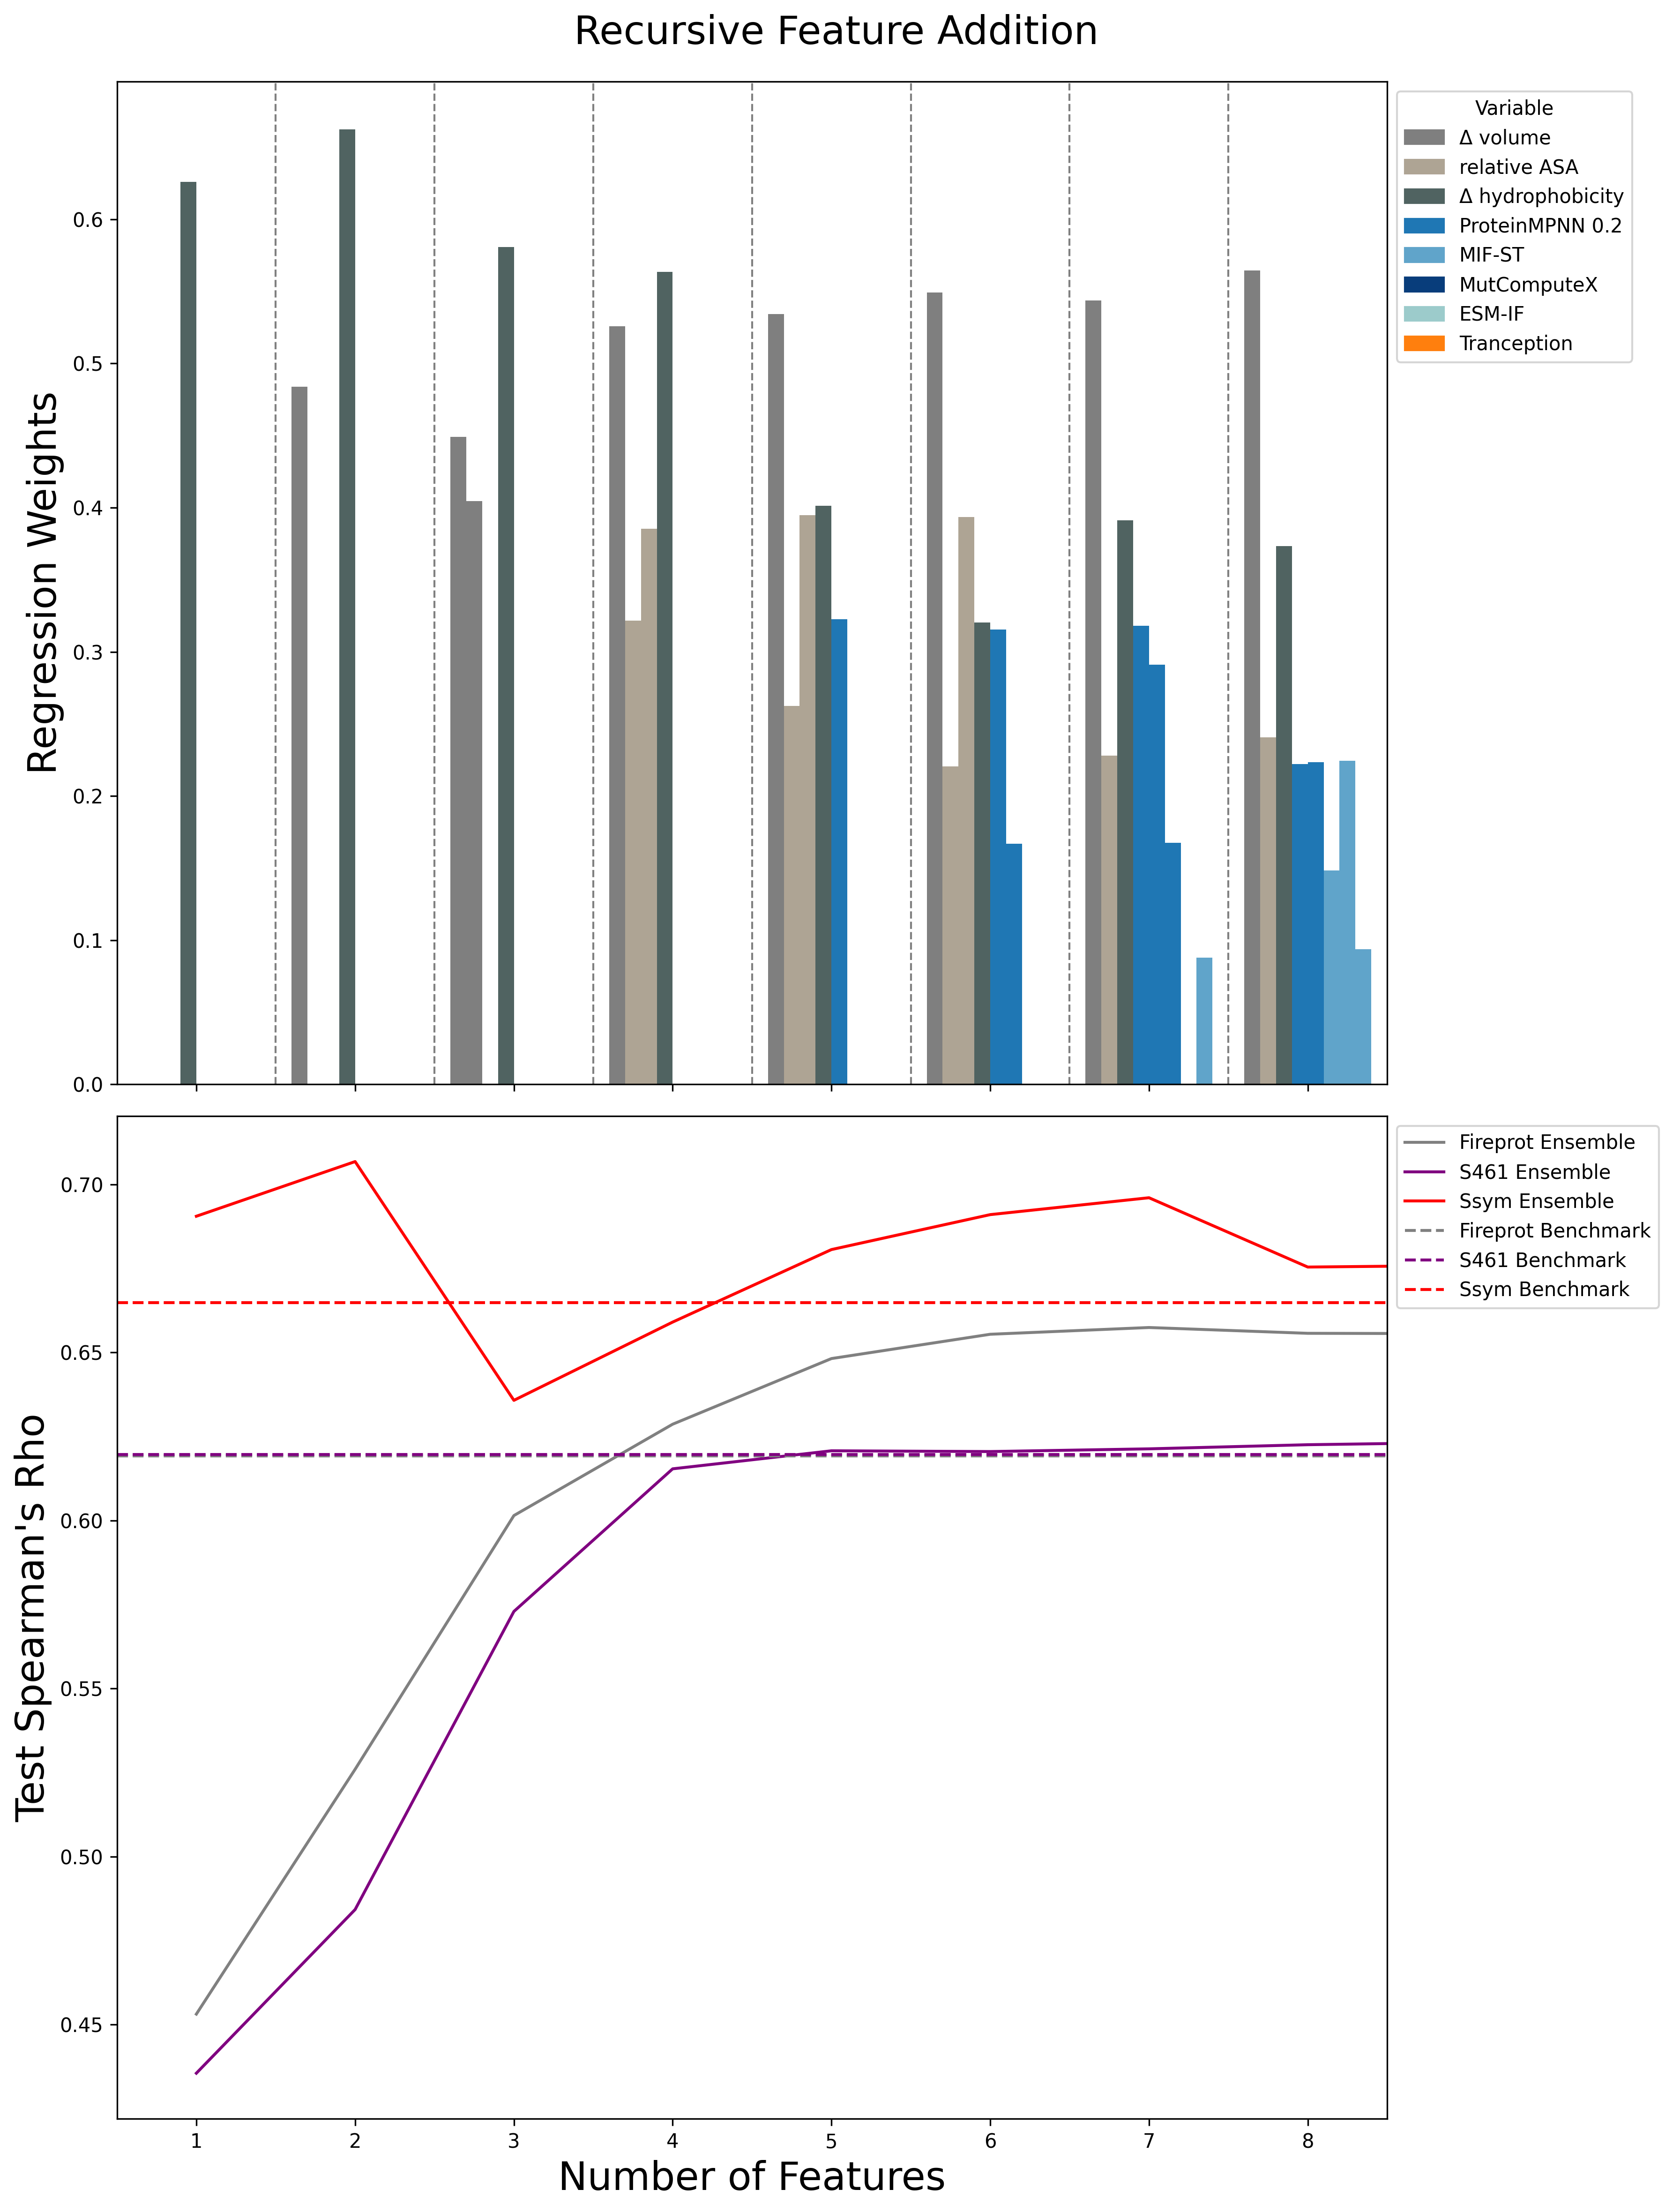

In [10]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
import importlib
importlib.reload(analysis_utils)

cols2 = ['delta_kdh_dir', 'delta_vol_dir', 'rel_ASA_dir', 'esmif_multimer_dir', 'mpnn_20_00_dir', 'mif_dir', 'mifst_dir', 'mutcomputex_dir', 'msa_transformer_mean_dir', 'esm2_650M_dir', 'ankh_dir', 'tranception_dir']
df_train = db_class.drop('cluster', axis=1).join(db_feats_2[[c for c in db_feats_2.columns if c in cols2]]).join(db_training).dropna(subset='ddG_dir').fillna(0)
df_train = df_train.loc[~df_train['overlaps_Ssym']].loc[~df_train['overlaps_s461']]
df_test = db_class.drop('cluster', axis=1).join(db_feats_2[[c for c in db_feats_2.columns if c in cols2]]).join(db_training).dropna(subset='ddG_dir').fillna(0).drop(['ProTherm', 'ddG'], axis=1).fillna(0)
df_test_s461 = pd.read_csv(os.path.join(path, 'data', 's461_mapped_preds_clusters_extra.csv')).set_index('uid')
df_test_s461 = df_test_s461[[c for c in df_test_s461.columns if not 'fireprot' in c and not 'rfa' in c]]
df_test_s461.columns = [c+'_dir' if c in ['delta_kdh', 'delta_vol', 'rel_ASA'] else c for c in df_test_s461.columns]
df_test_ssym = pd.read_csv(os.path.join(path, 'data', 'Ssym_mapped_preds_clusters_extra.csv')).set_index('uid')
df_test_ssym = df_test_ssym[[c for c in df_test_ssym.columns if not 'fireprot' in c and not 'rfa' in c]]
df_test_ssym.columns = [c+'_dir' for c in df_test_ssym.columns]

dfs_test = {'fireprot': df_test, 's461': df_test_s461, 'ssym': df_test_ssym}

test_scores, weights_df, dfs_test = analysis_utils.custom_recursive_feature_addition(df_train, dfs_test, cols2, 'ddG_dir', LinearRegression(positive=True), fillna=True, source='fireprot_pslm')

df_test_q3421 = dfs_test['fireprot']
df_test_q3421 = df_test_q3421.rename(dict(zip([c for c in df_test_q3421.columns if 'rfa' in c], [c+'_dir' for c in df_test_q3421.columns if 'rfa' in c])), axis=1)
db_class = db_class[[c for c in db_class.columns if not 'q3421_pslm' in c]]
db_class = db_class.join(df_test_q3421[[c for c in df_test_q3421.columns if 'rfa' in c]])

df_test_s461 = dfs_test['s461']
df_test_s461 = df_test_s461.rename(dict(zip([c for c in df_test_s461.columns if 'rfa' in c], [c+'_dir' for c in df_test_s461.columns if 'rfa' in c])), axis=1)
df_test_s461.to_csv(os.path.join(path, 'data', 's461_mapped_preds_clusters_extra.csv'))

df_test_ssym = dfs_test['ssym']
df_test_ssym = df_test_ssym.rename(dict(zip([c for c in df_test_ssym.columns if '_dir' in c], [c[:-4] for c in df_test_ssym.columns if '_dir' in c])), axis=1)
df_test_ssym.to_csv(os.path.join(path, 'data', 'Ssym_mapped_preds_clusters_extra.csv'))

In [11]:
# TABLE 1
# Note: due to changes in the dependencies and small changes to preprocessing,
# results have changed very slightly from the current revision, but do not affect
# the interpretation of results or conclusions

# could replace stats=() with ('n', 'MCC', 'auprc', 'ndcg', 'spearman')
# but then you would not be saving the other stats. 
# uncomment to_csv lines to save to a custom location
summ = analysis_utils.compute_stats(db_class, stats=(), n_classes=2, grouper='cluster')
rcv = summ.copy(deep=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

In [12]:
# uncomment this to save all stats and see which are available for other analyses
#summ.to_csv('~/zs_suppl/fireprot_summ_final_2_classes_all.csv')
#tmp = summ.loc[:,['n', 'MCC', 'auprc', 'spearman', 'weighted_ndcg', 'weighted_auprc', 'weighted_spearman']]
tmp = summ
tmp = tmp.sort_values(['measurement', 'weighted_spearman'], ascending=False).reset_index()

tmp['model'] = tmp['model'].map(remap_names_2)
tmp['measurement'] = tmp['measurement'].map({'ddG': 'ΔΔG', 'dTm': 'ΔTm'})
tmp.loc[tmp['model'].isin(['Gaussian noise', 'ΔΔG', 'ΔTm']), 'model_type'] = 'N/A'

remap_cols = {'auprc': 'AUPRC', 'spearman': 'ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy'}
tmp = tmp.rename(remap_cols, axis=1)
tmp = tmp[['measurement', 'model_type', 'model', 'n', 'MCC', 'AUPRC', 'ρ', 'wNDCG', 'wAUPRC', 'wρ', 'mean_t1s', 'Net Stabilization', 'pred_positives', 'mean_stabilization', 'mean PPC', 'mean MSC', 'True Positives', 'Sensitivity', 'Accuracy']]
tmp = tmp.loc[tmp['model'].isin(['Rosetta_CartDDG', 'ProteinMPNN_mean', 'ProteinMPNN_30', 'ProteinMPNN_20', 'ESM-IF', 'MIF', 'ESM-IF(M)', 'Ankh', 'ESM-2_3B', 'ESM-2_15B', 'Structural', 'Evolutionary', 'Supervised', 'ESM-2_150M', 'ESM-2_650M', 'Ensemble', 'ESM-2_mean', 'ESM-IF_mean', 'MIF_mean', 'Clustered_Ensemble', 'Ensemble_2',
                            'ProteinMPNN_10', 'MIF-ST', 'KORPM', 'MSA-T_mean', 'MSA-T_1', 'Tranception', 'ESM-1V_mean', 'ESM-1V_2', 'Gaussian noise', 'ΔΔG label', 'ΔTm label', 'ProteinMPNN + Rosetta_CartDDG', 'MutComputeX', 'Stability_Oracle'])]
tmp = tmp.dropna(subset='model').set_index(['measurement', 'model_type', 'model']).astype(float).round(3)
#tmp.to_csv('~/zs_suppl/fireprot_summ_final_2_classes_select.csv')
tmp

n    MCC  AUPRC      ρ  wNDCG  \
measurement model_type   model                                              
ΔΔG         unknown      ΔΔG label     4719.0  1.000  1.000  1.000  1.000   
                         ΔTm label     1428.0  0.793  0.855  0.891  0.898   
            NaN          Supervised    4719.0  0.342  0.545  0.635  0.670   
                         Structural    4719.0  0.226  0.386  0.412  0.641   
            potential    KORPM         4719.0  0.285  0.467  0.517  0.628   
            structural   MIF           4719.0  0.215  0.443  0.447  0.626   
                         MIF-ST        4719.0  0.190  0.433  0.424  0.597   
                         ESM-IF        4719.0  0.213  0.437  0.374  0.599   
                         ESM-IF(M)     4719.0  0.201  0.433  0.371  0.589   
            NaN          Evolutionary  4719.0  0.159  0.382  0.268  0.570   
            structural   MutComputeX   4676.0  0.190  0.443  0.381  0.606   
            evolutionary Ankh          4719.0  0.132  0.372  0.295  0.563   
                         Tranception   4719.0  0.102  0.348  0.253  0.540   
ΔTm         unknown      ΔTm label     2462.0  1.000  1.000  1.000  1.000   
                         ΔΔG label     1428.0  0.793  0.907  0.891  0.926   
            NaN          Structural    2462.0  0.296  0.508  0.503  0.710   
                         Supervised    2462.0  0.293  0.507  0.544  0.696   
            structural   ESM-IF        2462.0  0.248  0.546  0.550  0.690   
                         ESM-IF(M)     2462.0  0.259  0.544  0.546  0.688   
                         MIF           2462.0  0.271  0.534  0.476  0.690   
                         MIF-ST        2462.0  0.207  0.500  0.428  0.661   
            potential    KORPM         2462.0  0.257  0.470  0.443  0.664   
            NaN          Evolutionary  2462.0  0.200  0.487  0.396  0.645   
            evolutionary Ankh          2462.0  0.195  0.473  0.411  0.639   
            structural   MutComputeX   2427.0  0.226  0.515  0.388  0.645   
            evolutionary Tranception   2462.0  0.142  0.445  0.390  0.610   

                                       wAUPRC     wρ  mean_t1s  \
measurement model_type   model                                   
ΔΔG         unknown      ΔΔG label      0.957  1.000     1.905   
                         ΔTm label      0.827  0.851     1.017   
            NaN          Supervised     0.548  0.513     0.218   
                         Structural     0.518  0.443     0.264   
            potential    KORPM          0.483  0.424     0.064   
            structural   MIF            0.481  0.416     0.220   
                         MIF-ST         0.445  0.394     0.062   
                         ESM-IF         0.484  0.384    -0.023   
                         ESM-IF(M)      0.465  0.375    -0.264   
            NaN          Evolutionary   0.419  0.312    -0.038   
            structural   MutComputeX    0.459  0.303     0.030   
            evolutionary Ankh           0.427  0.268    -0.353   
                         Tranception    0.382  0.262    -0.167   
ΔTm         unknown      ΔTm label      0.990  1.000     6.496   
                         ΔΔG label      0.837  0.851     4.810   
            NaN          Structural     0.633  0.431     2.703   
                         Supervised     0.604  0.431     1.261   
            structural   ESM-IF         0.602  0.423     1.960   
                         ESM-IF(M)      0.601  0.421     1.739   
                         MIF            0.596  0.399     1.328   
                         MIF-ST         0.599  0.347     1.250   
            potential    KORPM          0.566  0.335     0.165   
            NaN          Evolutionary   0.617  0.290     0.485   
            evolutionary Ankh           0.606  0.262     0.627   
            structural   MutComputeX    0.566  0.261     0.584   
            evolutionary Tranception    0.574  0.217     0.098   

                                      

In [13]:
importlib.reload(analysis_utils)
db_class['code'] = db_class.index.str[:4]

summ = analysis_utils.compute_stats(db_class.drop('code', axis=1), 
                                    stats=('n', 'MCC', 'pred_positives', 'tp', 'auprc', 'spearman', 'ndcg', 'mean_t1s', 'mean_reciprocal_rank', 'mean_stabilization', 'net_stabilization', 'sensitivity', 'recall@k0.0', 'recall@k1.0'), 
                                    measurements=['ddG', 'dTm'], grouper='cluster', n_classes=2, n_bootstraps=100, quiet=True)

In [24]:
tmp1 = summ.xs('ddG').reset_index()
remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = tmp1.sort_values('net_stabilization_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s3 = s2.loc[s2['model'].isin(original_pred_cols_reduced + ['random_dir', 'ddG_dir'])]#.drop('measurement', axis=1)
s4 = s3[['model_type', 'model', 
    'n_mean', 'n_std',
    'recall@k1.0_mean', 'recall@k1.0_std',
    'ndcg_mean', 'ndcg_std',
    'weighted_ndcg_mean', 'weighted_ndcg_std',
    'spearman_mean', 'spearman_std',
    'weighted_spearman_mean', 'weighted_spearman_std',
    'auprc_mean', 'auprc_std', 
    'MCC_mean', 'MCC_std', 
    'mean_stabilization_mean', 'mean_stabilization_std', 
    'net_stabilization_mean', 'net_stabilization_std',
    ]]
s4['model'] = s4['model'].map(remap_names_2)
s5 = s4.set_index(['model_type', 'model'])
s5.columns = [new_remap_cols[c] for c in s5.columns]
s5
# Iterate over the DataFrame and update the mean columns
for column in s5.columns:
    if 'mean' in column:
        stdev_column = column.replace('mean', 'stdev')
        s5[column] = s5[column].round(3).astype(str) + ' ± ' + s5[stdev_column].round(2).astype(str)

# Drop the standard deviation columns
s5 = s5[[col for col in s5.columns if 'stdev' not in col]]
s5.columns = [col[:-5] for col in s5.columns]
s6 = s5.reset_index().rename({'model_type': 'Model Type', 'model': 'Model'}, axis=1)
s6

Model Type             Model                  n    Recall @ k  \
0        unknown         ΔΔG label  4727.51 ± 1190.96     1.0 ± 0.0   
1    biophysical   Rosetta CartDDG  4727.51 ± 1190.96  0.285 ± 0.04   
2     structural   ProteinMPNN 0.1  4727.51 ± 1190.96   0.23 ± 0.03   
3     structural   ProteinMPNN 0.2  4727.51 ± 1190.96  0.228 ± 0.03   
4     structural            MIF-ST  4727.51 ± 1190.96   0.17 ± 0.03   
5       transfer  Stability Oracle  4666.17 ± 1193.31  0.257 ± 0.05   
6   evolutionary       Tranception  4727.51 ± 1190.96  0.168 ± 0.04   
7   evolutionary         ESM-2 15B  4726.32 ± 1190.93  0.144 ± 0.03   
8     structural            ESM-IF  4727.51 ± 1190.96   0.18 ± 0.04   
9   evolutionary          ESM-2 3B  4727.51 ± 1190.96  0.138 ± 0.03   
10    structural   ProteinMPNN 0.3  4727.51 ± 1190.96  0.247 ± 0.04   
11    structural       MutComputeX  4678.97 ± 1192.64  0.136 ± 0.02   
12    structural         ESM-IF(M)  4727.51 ± 1190.96  0.174 ± 0.04   
13    structural               MIF  4727.51 ± 1190.96  0.226 ± 0.03   
14  evolutionary        MSA-T mean  4727.51 ± 1190.96  0.146 ± 0.03   
15  evolutionary      MSA-T median  4727.51 ± 1190.96  0.141 ± 0.03   
16  evolutionary              Ankh  4727.51 ± 1190.96  0.139 ± 0.03   
17  evolutionary        ESM-2 650M  4727.51 ± 1190.96  0.161 ± 0.03   
18  evolutionary       ESM-1V mean  4727.51 ± 1190.96  0.163 ± 0.03   
19  evolutionary     ESM-1V median  4727.51 ± 1190.96   0.16 ± 0.03   
20     potential             KORPM  4727.51 ± 1190.96  0.239 ± 0.03   
21  evolutionary        ESM-2 150M  4727.51 ± 1190.96  0.183 ± 0.04   
22       unknown    Gaussian Noise  4727.51 ± 1190.96  0.066 ± 0.01   

            NDCG         wNDCG  Spearman's ρ            wρ         AUPRC  \
0      1.0 ± 0.0     1.0 ± 0.0     1.0 ± 0.0     1.0 ± 0.0     1.0 ± 0.0   
1   0.717 ± 0.06  0.672 ± 0.02  0.606 ± 0.05  0.494 ± 0.03  0.534 ± 0.06   
2   0.705 ± 0.06  0.675 ± 0.02  0.456 ± 0.05  0.416 ± 0.02  0.472 ± 0.03   
3   0.702 ± 0.06  0.679 ± 0.02  0.468 ± 0.06  0.441 ± 0.02  0.484 ± 0.03   
4   0.681 ± 0.06  0.616 ± 0.02  0.422 ± 0.06  0.398 ± 0.02  0.434 ± 0.05   
5   0.698 ± 0.07  0.677 ± 0.02   0.61 ± 0.05  0.515 ± 0.03  0.517 ± 0.05   
6   0.645 ± 0.06  0.564 ± 0.02  0.253 ± 0.07  0.267 ± 0.03  0.353 ± 0.03   
7   0.656 ± 0.06  0.582 ± 0.02  0.286 ± 0.06  0.291 ± 0.03  0.382 ± 0.04   
8   0.688 ± 0.06  0.619 ± 0.02  0.411 ± 0.07  0.387 ± 0.03  0.443 ± 0.03   
9   0.655 ± 0.06  0.582 ± 0.02  0.278 ± 0.06  0.289 ± 0.03  0.376 ± 0.04   
10  0.706 ± 0.06  0.686 ± 0.02  0.462 ± 0.06  0.446 ± 0.02  0.476 ± 0.03   
11  0.666 ± 0.06  0.629 ± 0.02  0.375 ± 0.04  0.304 ± 0.02  0.442 ± 0.04   
12  0.686 ± 0.06  0.606 ± 0.02  0.407 ± 0.07  0.379 ± 0.03  0.438 ± 0.03   
13  0.695 ± 0.06  0.647 ± 0.02  0.461 ± 0.06  0.417 ± 0.02   0.45 ± 0.03   
14  0.654 ± 0.06   0.58 ± 0.02  0.257 ± 0.09   0.28 ± 0.03  0.371 ± 0.03   
15  0.653 ± 0.06  0.583 ± 0.02  0.254 ± 0.09  0.277 ± 0.03  0.371 ± 0.03   
16   0.65 ± 0.06  0.589 ± 0.02  0.295 ± 0.07  0.268 ± 0.04  0.373 ± 0.04   
17   0.67 ± 0.06  0.601 ± 0.02  0.278 ± 0.07  0.299 ± 0.04  0.373 ± 0.03   
18  0.672 ± 0.06  0.584 ± 0.02  0.219 ± 0.09  0.286 ± 0.03  0.361 ± 0.03   
19  0.672 ± 0.06  0.583 ± 0.02  0.212 ± 0.08  0.274 ± 0.03  0.359 ± 0.03   
20  0.704 ± 0.06  0.646 ± 0.02  0.508 ± 0.04  0.425 ± 0.02  0.461 ± 0.06   
21  0.668 ± 0.06  0.602 ± 0.02  0.188 ± 0.09  0.292 ± 0.03  0.337 ± 0.03   
22  0.625 ± 0.06  0.531 ± 0.02  0.027 ± 0.02  0.019 ± 0.02  0.276 ± 0.05   

             MCC Mean Stabilization  Net Stabilization  
0      1.0 ± 0.0       0.776 ± 0.15   1815.31 ± 680.32  
1   0.341 ± 0.02       0.064 ± 0.16    139.84 ± 310.12  
2   0.256 ± 0.05       0.094 ± 0.14   107.584 ± 158.88  
3   0.281 ± 0.05       0.055 ± 0.15    79.382 ± 190.59  
4     0.2 ± 0.03       0.087 ± 0.13     69.382 ± 96.56  
5   0.346 ± 0.02       0.017 ± 0.12    63.282 ± 253.56  
6   0.111 ± 0.04       0.201 ± 0.19      51.715 ± 52.3  
7   0.151 ± 0.04    

In [25]:
tmp1 = summ.xs('dTm').reset_index()
remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = tmp1.sort_values('net_stabilization_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s3 = s2.loc[s2['model'].isin(original_pred_cols_reduced + ['random_dir', 'dTm_dir'])]#.drop('measurement', axis=1)
s4 = s3[['model_type', 'model', 
    'recall@k1.0_mean', 'recall@k1.0_std',
    'ndcg_mean', 'ndcg_std',
    'weighted_ndcg_mean', 'weighted_ndcg_std',
    'spearman_mean', 'spearman_std',
    'weighted_spearman_mean', 'weighted_spearman_std',
    'auprc_mean', 'auprc_std', 
    'MCC_mean', 'MCC_std', 
    'mean_stabilization_mean', 'mean_stabilization_std', 
    'net_stabilization_mean', 'net_stabilization_std',
    ]]
s4['model'] = s4['model'].map(remap_names_2)
s5 = s4.set_index(['model_type', 'model'])
s5.columns = [new_remap_cols[c] for c in s5.columns]
s5
# Iterate over the DataFrame and update the mean columns
for column in s5.columns:
    if 'mean' in column:
        stdev_column = column.replace('mean', 'stdev')
        s5[column] = s5[column].round(3).astype(str) + ' ± ' + s5[stdev_column].round(2).astype(str)

# Drop the standard deviation columns
s5 = s5[[col for col in s5.columns if 'stdev' not in col]]
s5.columns = [col[:-5] for col in s5.columns]
s6 = s5.reset_index().rename({'model_type': 'Model Type', 'model': 'Model'}, axis=1)
s6

Model Type             Model    Recall @ k          NDCG         wNDCG  \
0        unknown         ΔTm label     1.0 ± 0.0     1.0 ± 0.0     1.0 ± 0.0   
1     structural   ProteinMPNN 0.2  0.442 ± 0.04  0.778 ± 0.03  0.705 ± 0.02   
2     structural   ProteinMPNN 0.3  0.438 ± 0.04  0.782 ± 0.03   0.71 ± 0.02   
3     structural            ESM-IF  0.401 ± 0.04  0.798 ± 0.04  0.707 ± 0.02   
4     structural         ESM-IF(M)  0.396 ± 0.04    0.8 ± 0.04  0.705 ± 0.02   
5     structural   ProteinMPNN 0.1  0.437 ± 0.04  0.775 ± 0.03  0.708 ± 0.02   
6    biophysical   Rosetta CartDDG  0.399 ± 0.05   0.75 ± 0.04   0.72 ± 0.03   
7     structural               MIF  0.409 ± 0.04  0.764 ± 0.03  0.708 ± 0.02   
8     structural            MIF-ST  0.372 ± 0.04  0.756 ± 0.04  0.683 ± 0.02   
9     structural       MutComputeX  0.357 ± 0.03  0.733 ± 0.03  0.664 ± 0.02   
10  evolutionary        ESM-2 650M  0.374 ± 0.04  0.738 ± 0.04   0.67 ± 0.02   
11  evolutionary              Ankh   0.36 ± 0.04  0.695 ± 0.03   0.67 ± 0.02   
12  evolutionary        MSA-T mean  0.353 ± 0.05  0.681 ± 0.03  0.658 ± 0.02   
13      transfer  Stability Oracle  0.388 ± 0.04  0.743 ± 0.04  0.699 ± 0.03   
14  evolutionary      MSA-T median  0.349 ± 0.05  0.681 ± 0.03   0.66 ± 0.02   
15  evolutionary         ESM-2 15B  0.339 ± 0.04  0.715 ± 0.04  0.662 ± 0.02   
16  evolutionary          ESM-2 3B  0.364 ± 0.04  0.708 ± 0.03  0.667 ± 0.02   
17  evolutionary       Tranception  0.316 ± 0.04   0.69 ± 0.02  0.642 ± 0.02   
18  evolutionary       ESM-1V mean  0.316 ± 0.03  0.737 ± 0.04  0.655 ± 0.02   
19  evolutionary     ESM-1V median   0.31 ± 0.04  0.736 ± 0.04  0.654 ± 0.02   
20     potential             KORPM  0.381 ± 0.04  0.707 ± 0.03  0.679 ± 0.02   
21  evolutionary        ESM-2 150M  0.321 ± 0.03  0.752 ± 0.04  0.686 ± 0.02   
22       unknown    Gaussian Noise  0.206 ± 0.03  0.634 ± 0.03  0.571 ± 0.02   

    Spearman's ρ            wρ         AUPRC           MCC Mean Stabilization  \
0      1.0 ± 0.0     1.0 ± 0.0     1.0 ± 0.0     1.0 ± 0.0        2.74 ± 0.42   
1   0.514 ± 0.07  0.387 ± 0.04  0.574 ± 0.04   0.31 ± 0.05       1.334 ± 0.58   
2   0.504 ± 0.08  0.378 ± 0.04  0.572 ± 0.04  0.318 ± 0.05        1.112 ± 0.6   
3   0.534 ± 0.08  0.425 ± 0.03  0.551 ± 0.04  0.249 ± 0.04        1.59 ± 0.78   
4    0.53 ± 0.08  0.423 ± 0.03  0.549 ± 0.04  0.261 ± 0.03        1.607 ± 0.8   
5   0.496 ± 0.08   0.41 ± 0.03  0.563 ± 0.04  0.294 ± 0.04       1.145 ± 0.62   
6   0.533 ± 0.09  0.441 ± 0.04  0.516 ± 0.06    0.3 ± 0.05       0.597 ± 0.57   
7   0.464 ± 0.08    0.4 ± 0.03  0.537 ± 0.04  0.273 ± 0.04       0.688 ± 0.69   
8   0.415 ± 0.08   0.35 ± 0.03  0.505 ± 0.04  0.213 ± 0.04       0.893 ± 0.74   
9   0.374 ± 0.06  0.259 ± 0.03  0.515 ± 0.03  0.227 ± 0.03       1.172 ± 0.59   
10   0.36 ± 0.08  0.277 ± 0.04  0.492 ± 0.04  0.229 ± 0.04       0.738 ± 0.65   
11    0.4 ± 0.08  0.265 ± 0.04  0.482 ± 0.04    0.2 ± 0.04       0.897 ± 0.71   
12  0.364 ± 0.09  0.253 ± 0.04  0.485 ± 0.04  0.206 ± 0.04       1.017 ± 0.74   
13  0.543 ± 0.08  0.446 ± 0.03  0.541 ± 0.05  0.307 ± 0.05       0.331 ± 0.48   
14  0.359 ± 0.08  0.251 ± 0.04  0.484 ± 0.04    0.2 ± 0.03       0.797 ± 0.74   
15  0.329 ± 0.09  0.254 ± 0.04  0.472 ± 0.04  0.171 ± 0.04       0.805 ± 0.88   
16  0.336 ± 0.08  0.229 ± 0.04  0.476 ± 0.04  0.192 ± 0.04       0.599 ± 0.81   
17   0.373 ± 0.1  0.214 ± 0.04  0.456 ± 0.04  0.154 ± 0.04       0.233 ± 0.61   
18  0.289 ± 0.08  0.239 ± 0.04   0.45 ± 0.04  0.175 ± 0.03       0.054 ± 0.58   
19  0.278 ± 0.08  0.223 ± 0.04  0.445 ± 0.03  0.153 ± 0.03      -0.269 ± 0.63   
20  0.431 ± 0.08  0.332 ± 0.04  0.477 ± 0.04   0.26 ± 0.05      -0.204 ± 0.58   
21   0.27 ± 0.08  0.261 ± 0.04  0.455 ± 0.03  0.164 ± 0.04      -0.655 ± 0.79   
22  0.025 ± 0.03  0.042 ± 0.03  0.327 ± 0.03  -0.01 ± 0.02      -3.083 ± 0.94   

      Net Stabilization  
0    3974.482 ± 1089.81  
1     1140.115 ± 517.48  
2     1056.986 ± 578.42  
3        974.4 ± 542.77  
4      948

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

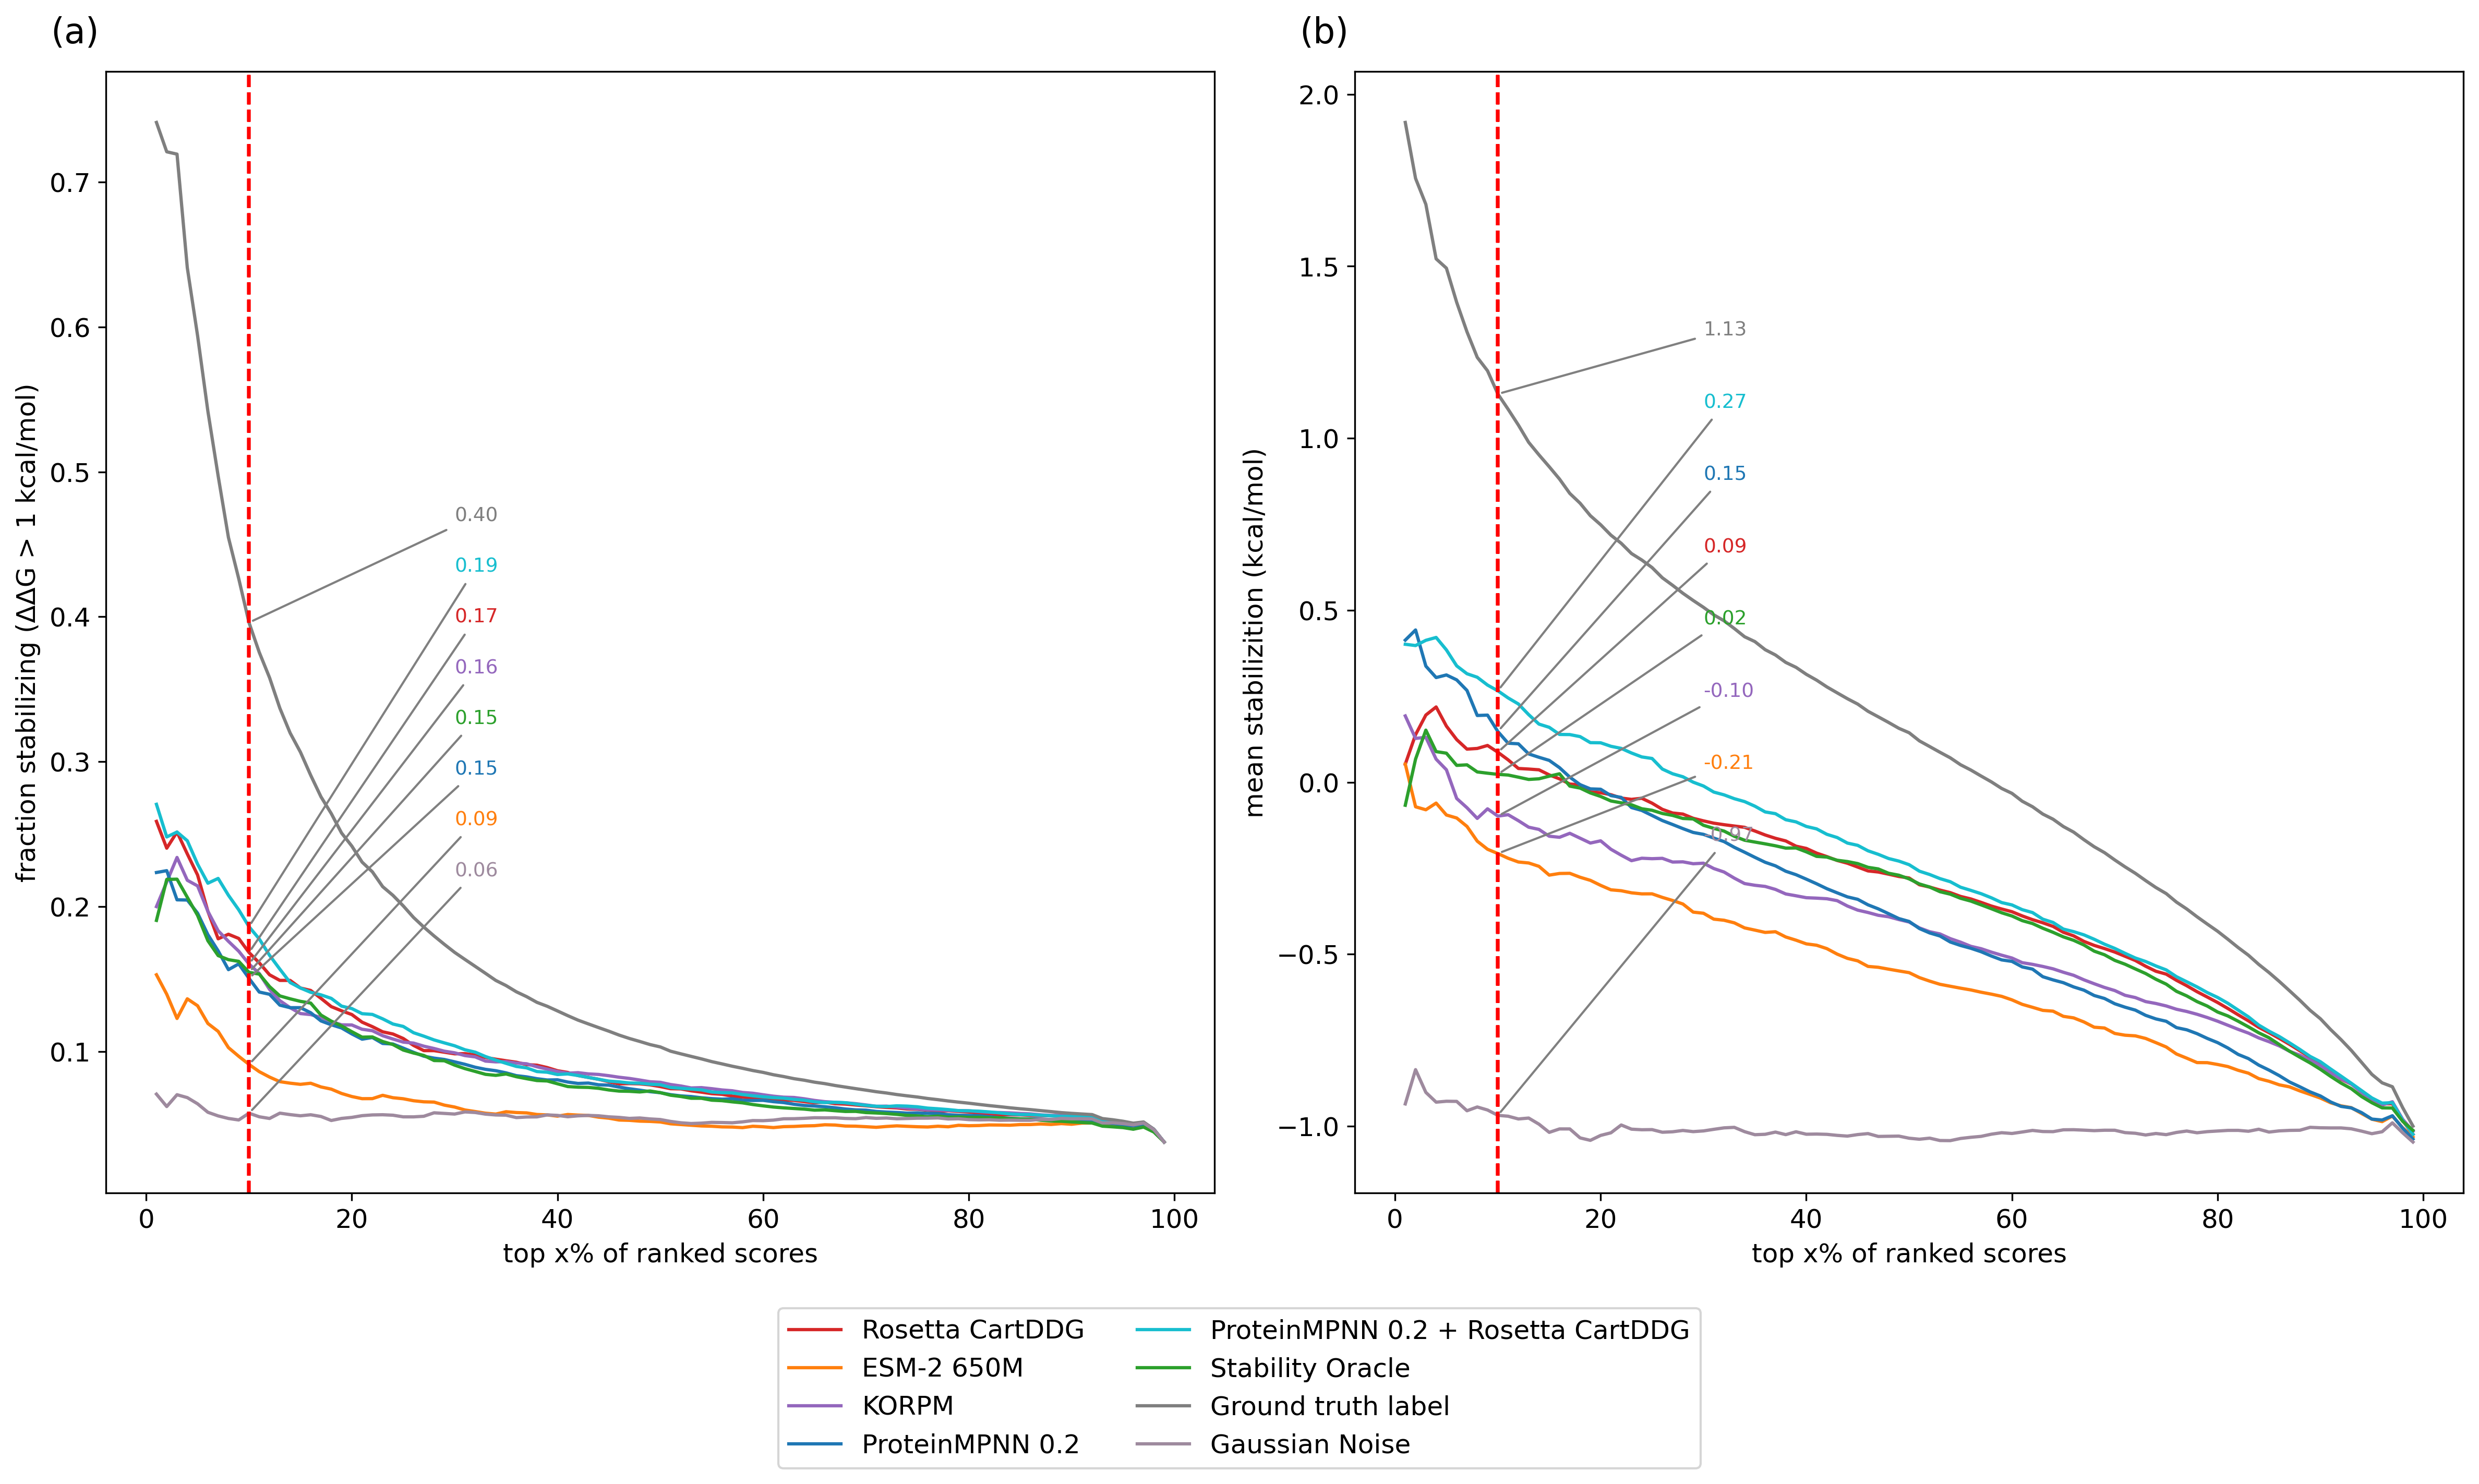

In [15]:
class_result_new = analysis_utils.compute_stats(db_class.drop('code', axis=1), stats=('aumsc', 'auppc'), measurements=['ddG'], grouper='cluster', n_bootstraps=0)
analysis_utils.recovery_curves(class_result_new, ['mpnn_20_00_dir', 'cartesian_ddg_dir', 'stability-oracle_dir', 'mpnn_rosetta_dir', 'korpm_dir', 'esm2_650M_dir', 'ddG_dir', 'random_dir'], spacing=0.07, measurements=['ddG'], plots=['auppc', 'aumsc']) #'mif_dir', 'esmif_multimer_full_dir',

In [16]:
# SUPPLEMENTARY TABLE 2
db_class_np = db_class.loc[~db_class['ProTherm'].astype(bool)]

summ2 = analysis_utils.compute_stats(db_class_np.drop('code', axis=1), stats=(), n_classes=2, grouper='cluster')
#summ2.to_csv('~/zs_suppl/fireprot_summ2_final_2_classes_no_protherm_all.csv')
tmp2 = summ2#.loc[:,['MCC', 'auprc', 'spearman', 'weighted_ndcg', 'weighted_auprc', 'weighted_spearman']]
tmp2 = tmp2.sort_values(['measurement', 'weighted_spearman'], ascending=False).reset_index()

tmp2['model'] = tmp2['model'].map(remap_names_2)
tmp2['measurement'] = tmp2['measurement'].map({'ddG': 'ΔΔG', 'dTm': 'ΔTm'})
tmp2.loc[tmp2['model'].isin(['Gaussian noise', 'ΔΔG', 'ΔTm']), 'model_type'] = 'N/A'

remap_cols = {'auprc': 'AUPRC', 'spearman': 'ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC'}
tmp2 = tmp2.rename(remap_cols, axis=1)
tmp2 = tmp2[['measurement', 'model_type', 'model', 'n', 'MCC', 'AUPRC', 'ρ', 'wNDCG', 'wAUPRC', 'wρ', 'mean_t1s', 'net_stabilization', 'pred_positives', 'mean_stabilization', 'mean PPC', 'mean MSC']]
tmp2 = tmp2.loc[tmp2['model'].isin(['Rosetta_CartDDG', 'ProteinMPNN_mean', 'ProteinMPNN_30', 'ProteinMPNN_20', 'ESM-IF', 'MIF', 'ESM-IF(M)', 'Ankh', 'ESM2_3B', 'ESM2_15B', 'Structural', 'Evolutionary', 'Supervised', 'ESM2_150M', 'ESM2_650M', 'Ensemble', 'ESM-2_mean', 'ESM-IF_mean', 'MIF_mean', 'Clustered_Ensemble', 'Ensemble_2',
                            'ProteinMPNN_10', 'MIF-ST', 'KORPM', 'MSA-T_mean', 'MSA-T_1', 'Tranception', 'ESM-1V_mean', 'ESM-1V_2', 'Gaussian noise', 'ΔΔG label', 'ΔTm label'])]
tmp2 = tmp2.dropna(subset='model').set_index(['measurement', 'model_type', 'model']).astype(float).round(3)
#tmp2.to_csv('~/zs_suppl/fireprot_summ_final_2_classes_no_protherm_select.csv')
tmp2

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

n    MCC  AUPRC      ρ  wNDCG  \
measurement model_type   model                                              
ΔΔG         unknown      ΔΔG label     1626.0  1.000  1.000  1.000  1.000   
                         ΔTm label       25.0  0.840  0.927  0.772  0.677   
            NaN          Structural    1626.0  0.204  0.479  0.369  0.705   
                         Supervised    1626.0  0.358  0.678  0.667  0.796   
            structural   ESM-IF        1626.0  0.162  0.503  0.341  0.686   
                         MIF           1626.0  0.144  0.523  0.389  0.701   
            potential    KORPM         1626.0  0.325  0.599  0.534  0.737   
            structural   ESM-IF(M)     1626.0  0.152  0.499  0.345  0.669   
                         MIF-ST        1626.0  0.170  0.562  0.408  0.674   
            NaN          Evolutionary  1626.0  0.108  0.458  0.223  0.660   
            evolutionary Tranception   1626.0  0.070  0.401  0.133  0.638   
                         Ankh          1626.0  0.136  0.474  0.255  0.644   
ΔTm         unknown      ΔTm label      857.0  1.000  1.000  1.000  1.000   
                         ΔΔG label       25.0  0.840  0.856  0.772  0.868   
            structural   ESM-IF(M)      857.0  0.187  0.525  0.352  0.697   
            NaN          Structural     857.0  0.196  0.562  0.374  0.720   
            structural   ESM-IF         857.0  0.153  0.522  0.355  0.697   
                         MIF            857.0  0.176  0.543  0.329  0.701   
            NaN          Evolutionary   857.0  0.124  0.497  0.266  0.644   
            structural   MIF-ST         857.0  0.095  0.513  0.275  0.639   
            evolutionary Tranception    857.0  0.096  0.476  0.259  0.651   
            NaN          Supervised     857.0  0.096  0.452  0.241  0.648   
            evolutionary Ankh           857.0  0.142  0.499  0.274  0.632   
            potential    KORPM          857.0  0.121  0.449  0.214  0.639   

                                       wAUPRC     wρ  mean_t1s  \
measurement model_type   model                                   
ΔΔG         unknown      ΔΔG label      0.799  1.000     0.739   
                         ΔTm label      0.726  0.512     0.036   
            NaN          Structural     0.521  0.417    -0.143   
                         Supervised     0.597  0.403    -0.160   
            structural   ESM-IF         0.502  0.371    -0.171   
                         MIF            0.484  0.367    -0.162   
            potential    KORPM          0.524  0.360    -0.242   
            structural   ESM-IF(M)      0.496  0.357    -0.336   
                         MIF-ST         0.496  0.324    -0.261   
            NaN          Evolutionary   0.453  0.274    -0.301   
            evolutionary Tranception    0.416  0.179    -0.420   
                         Ankh           0.432  0.138    -0.335   
ΔTm         unknown      ΔTm label      0.945  1.000     5.070   
                         ΔΔG label      0.586  0.512     1.099   
            structural   ESM-IF(M)      0.603  0.239     0.612   
            NaN          Structural     0.622  0.225     1.758   
            structural   ESM-IF         0.603  0.210     1.133   
                         MIF            0.602  0.207     1.172   
            NaN          Evolutionary   0.608  0.147     0.566   
            structural   MIF-ST         0.581  0.116    -0.305   
            evolutionary Tranception    0.618  0.109     0.995   
            NaN          Supervised     0.572  0.107     0.714   
            evolutionary Ankh           0.617  0.095    -0.323   
            potential    KORPM          0.561  0.076     0.715   

                                       net_stabilization  pred_positives  \
measurement model_type   model                                             
ΔΔG         unknown      ΔΔG label               359.060           601.0   
                         ΔTm label                 6.805            13.0   
            NaN     

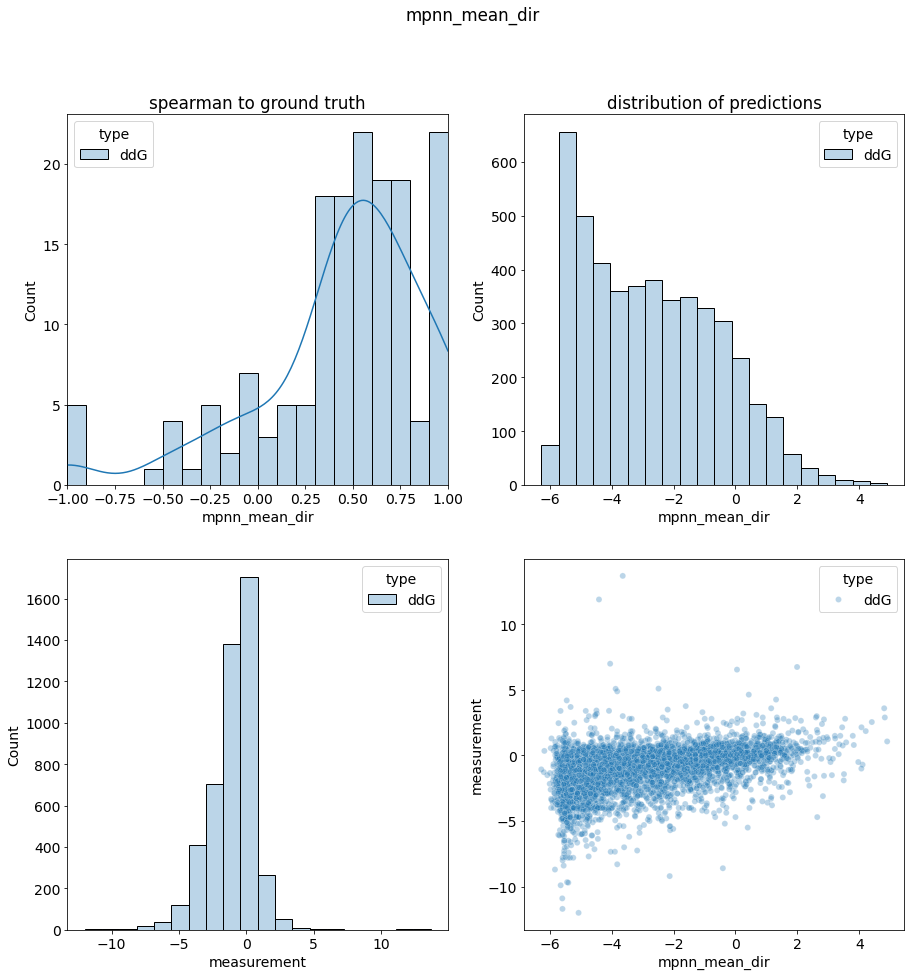

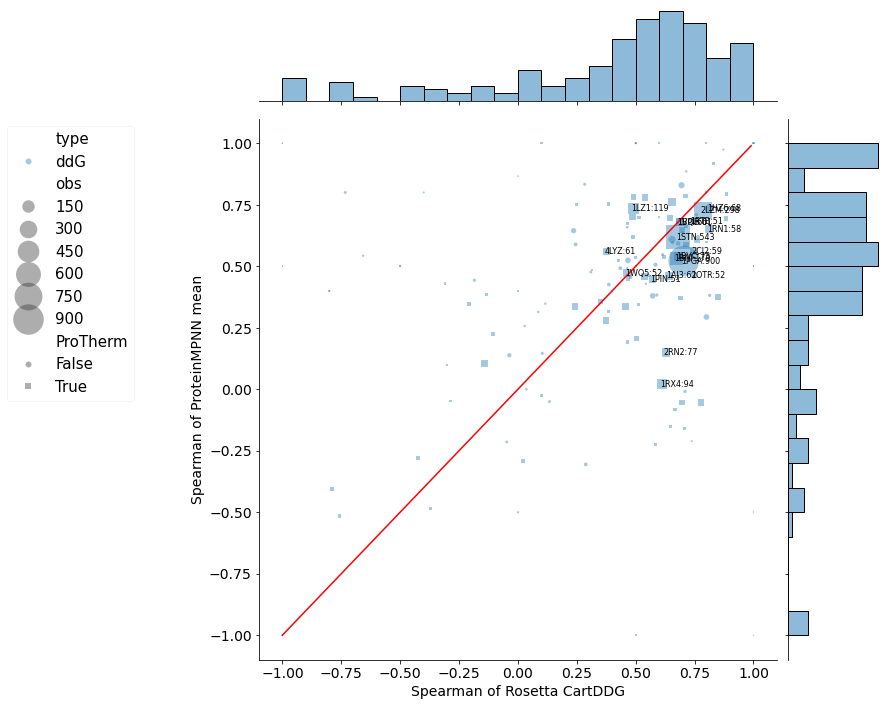

mpnn_mean_dir cartesian_ddg_dir
ddG n_total                      4719              4719
    ungrouped_spearman       0.462408          0.619149
    n_proteins                    132               132
    n_proteins_spearman           160               160
    avg_spearman             0.448078          0.402923
    weighted_spearman        0.451592          0.455314
    runtime (s)            111.691259         1935736.0

In [17]:
# SUPPLEMENTARY FIGURE 1 (second figure generated)

#db_corr = db_class.join(db_measurements)

db_class_ = db_class.copy(deep=True)
db_class_['code'] = db_class_.index.str[:4]
analysis_utils.correlations(db_class_, db_runtimes, stat='spearman', 
    score_name='mpnn_mean_dir', score_name_2='cartesian_ddg_dir', min_obs=1, group=True, plot=True, out=True, runtime=True)

In [18]:
# SUPPLEMENTARY TABLE 3

tmp3_ = analysis_utils.compute_stats(db_class.drop('code', axis=1), stats=['tp', 'fp', 'tn', 'fn', 'mean_t1s', 'auppc', 'aumsc', 'mean_stabilization', 'net_stabilization'], grouper='cluster')
#tmp_.to_csv('~/zs_suppl/fireprot_enrichment_all.csv')
tmp3 = tmp3_.sort_values(['measurement', 'net_stabilization'], ascending=False).reset_index()

tmp3['model'] = tmp3['model'].map(remap_names_2)
tmp3['measurement'] = tmp3['measurement'].map({'ddG': 'ΔΔG', 'dTm': 'ΔTm'})
tmp3.loc[tmp3['model'].isin(['Gaussian noise', 'ΔΔG', 'ΔTm']), 'model_type'] = 'N/A'

remap_cols = {'tp': 'TP', 'fp': 'FP', 'tn': 'TN', 'fn': 'FN', 'mean_t1s': 'Mean Top-1 Score', 'auppc': 'AUPPC', 'aumsc': 'AUMSC', 'mean_stabilization': 'Mean Stabilization', 'net_stabilization': 'Net Stabilization'}
tmp3 = tmp3.rename(remap_cols, axis=1)
tmp3 = tmp3.drop('runtime', axis=1)
tmp3 = tmp3.drop('class', axis=1)
tmp3 = tmp3.drop([c for c in tmp3.columns if '$' in c or 'x_recovery' in c], axis=1)
tmp3 = tmp3.loc[tmp3['model'].isin(['Rosetta_CartDDG', 'ProteinMPNN_mean', 'ProteinMPNN_30', 'ProteinMPNN_20', 'ESM-IF', 'MIF', 'ESM-IF(M)',
                            'ProteinMPNN_10', 'MIF-ST', 'KORPM', 'MSA-T_mean', 'MSA-T_1', 'Tranception', 'ESM-1V_mean', 'ESM-1V_2', 'Gaussian noise', 'ΔΔG label', 'ΔTm label'])]
tmp3 = tmp3.dropna(subset='model').set_index(['measurement', 'model_type', 'model']).astype(float).round(3)
tmp3 = tmp3[['TP', 'FP', 'TN', 'FN', 'AUPPC', 'AUMSC', 'Mean Top-1 Score', 'Mean Stabilization', 'Net Stabilization']]
#tmp3.to_csv('~/zs_suppl/fireprot_enrichment_select.csv')
tmp3
# ~ 3 minutes

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

TP     FP      TN      FN  AUPPC  \
measurement model_type   model                                               
ΔΔG         unknown      ΔΔG label    1275.0    0.0  3444.0     0.0  0.169   
                         ΔTm label     334.0   68.0   976.0    50.0  0.177   
            structural   MIF-ST        210.0  168.0  3276.0  1065.0  0.072   
            evolutionary Tranception    68.0   57.0  3387.0  1207.0  0.054   
            structural   ESM-IF        258.0  205.0  3239.0  1017.0  0.074   
                         MIF           321.0  303.0  3141.0   954.0  0.083   
                         ESM-IF(M)     248.0  209.0  3235.0  1027.0  0.073   
            potential    KORPM         591.0  630.0  2814.0   684.0  0.092   
ΔTm         unknown      ΔTm label     790.0    0.0  1672.0     0.0  0.451   
                         ΔΔG label     334.0   50.0   976.0    68.0  0.405   
            structural   ESM-IF        202.0  126.0  1546.0   588.0  0.282   
                         ESM-IF(M)     201.0  115.0  1557.0   589.0  0.282   
                         MIF           275.0  199.0  1473.0   515.0  0.285   
                         MIF-ST        197.0  157.0  1515.0   593.0  0.274   
            evolutionary Tranception   141.0  137.0  1535.0   649.0  0.241   
            potential    KORPM         394.0  403.0  1269.0   396.0  0.287   

                                      AUMSC  Mean Top-1 Score  \
measurement model_type   model                                  
ΔΔG         unknown      ΔΔG label    0.185             1.905   
                         ΔTm label    0.090             1.017   
            structural   MIF-ST      -0.439             0.062   
            evolutionary Tranception -0.633            -0.167   
            structural   ESM-IF      -0.426            -0.023   
                         MIF         -0.405             0.220   
                         ESM-IF(M)   -0.436            -0.264   
            potential    KORPM       -0.434             0.064   
ΔTm         unknown      ΔTm label    1.063             6.496   
                         ΔΔG label    0.416             4.810   
            structural   ESM-IF      -0.862             1.960   
                         ESM-IF(M)   -0.872             1.739   
                         MIF         -1.037             1.328   
                         MIF-ST      -1.127             1.250   
            evolutionary Tranception -1.656             0.098   
            potential    KORPM       -1.251             0.165   

                                      Mean Stabilization  Net Stabilization  
measurement model_type   model                                               
ΔΔG         unknown      ΔΔG label                 0.716            912.830  
                         ΔTm label                 0.596            239.575  
            structural   MIF-ST                    0.097             36.725  
            evolutionary Tranception               0.202             25.215  
            structural   ESM-IF                    0.022             10.405  
                         MIF                      -0.003             -1.715  
                         ESM-IF(M)                -0.028            -12.840  
            potential    KORPM                    -0.133           -162.650  
ΔTm         unknown      ΔTm label                 2.691           2126.045  
                         ΔΔG label                 2.639           1013.300  
            structural   ESM-IF                    1.619            530.970  
                         ESM-IF(M)                 1.633            516.010  
                         MIF                       0.757            359.025  
                         MIF-ST                    0.851            301.135  
            evolutionary Tranception               0.128             35.555  
            potential    KORPM                    -0.163           -130.120

KeyboardInterrupt: 

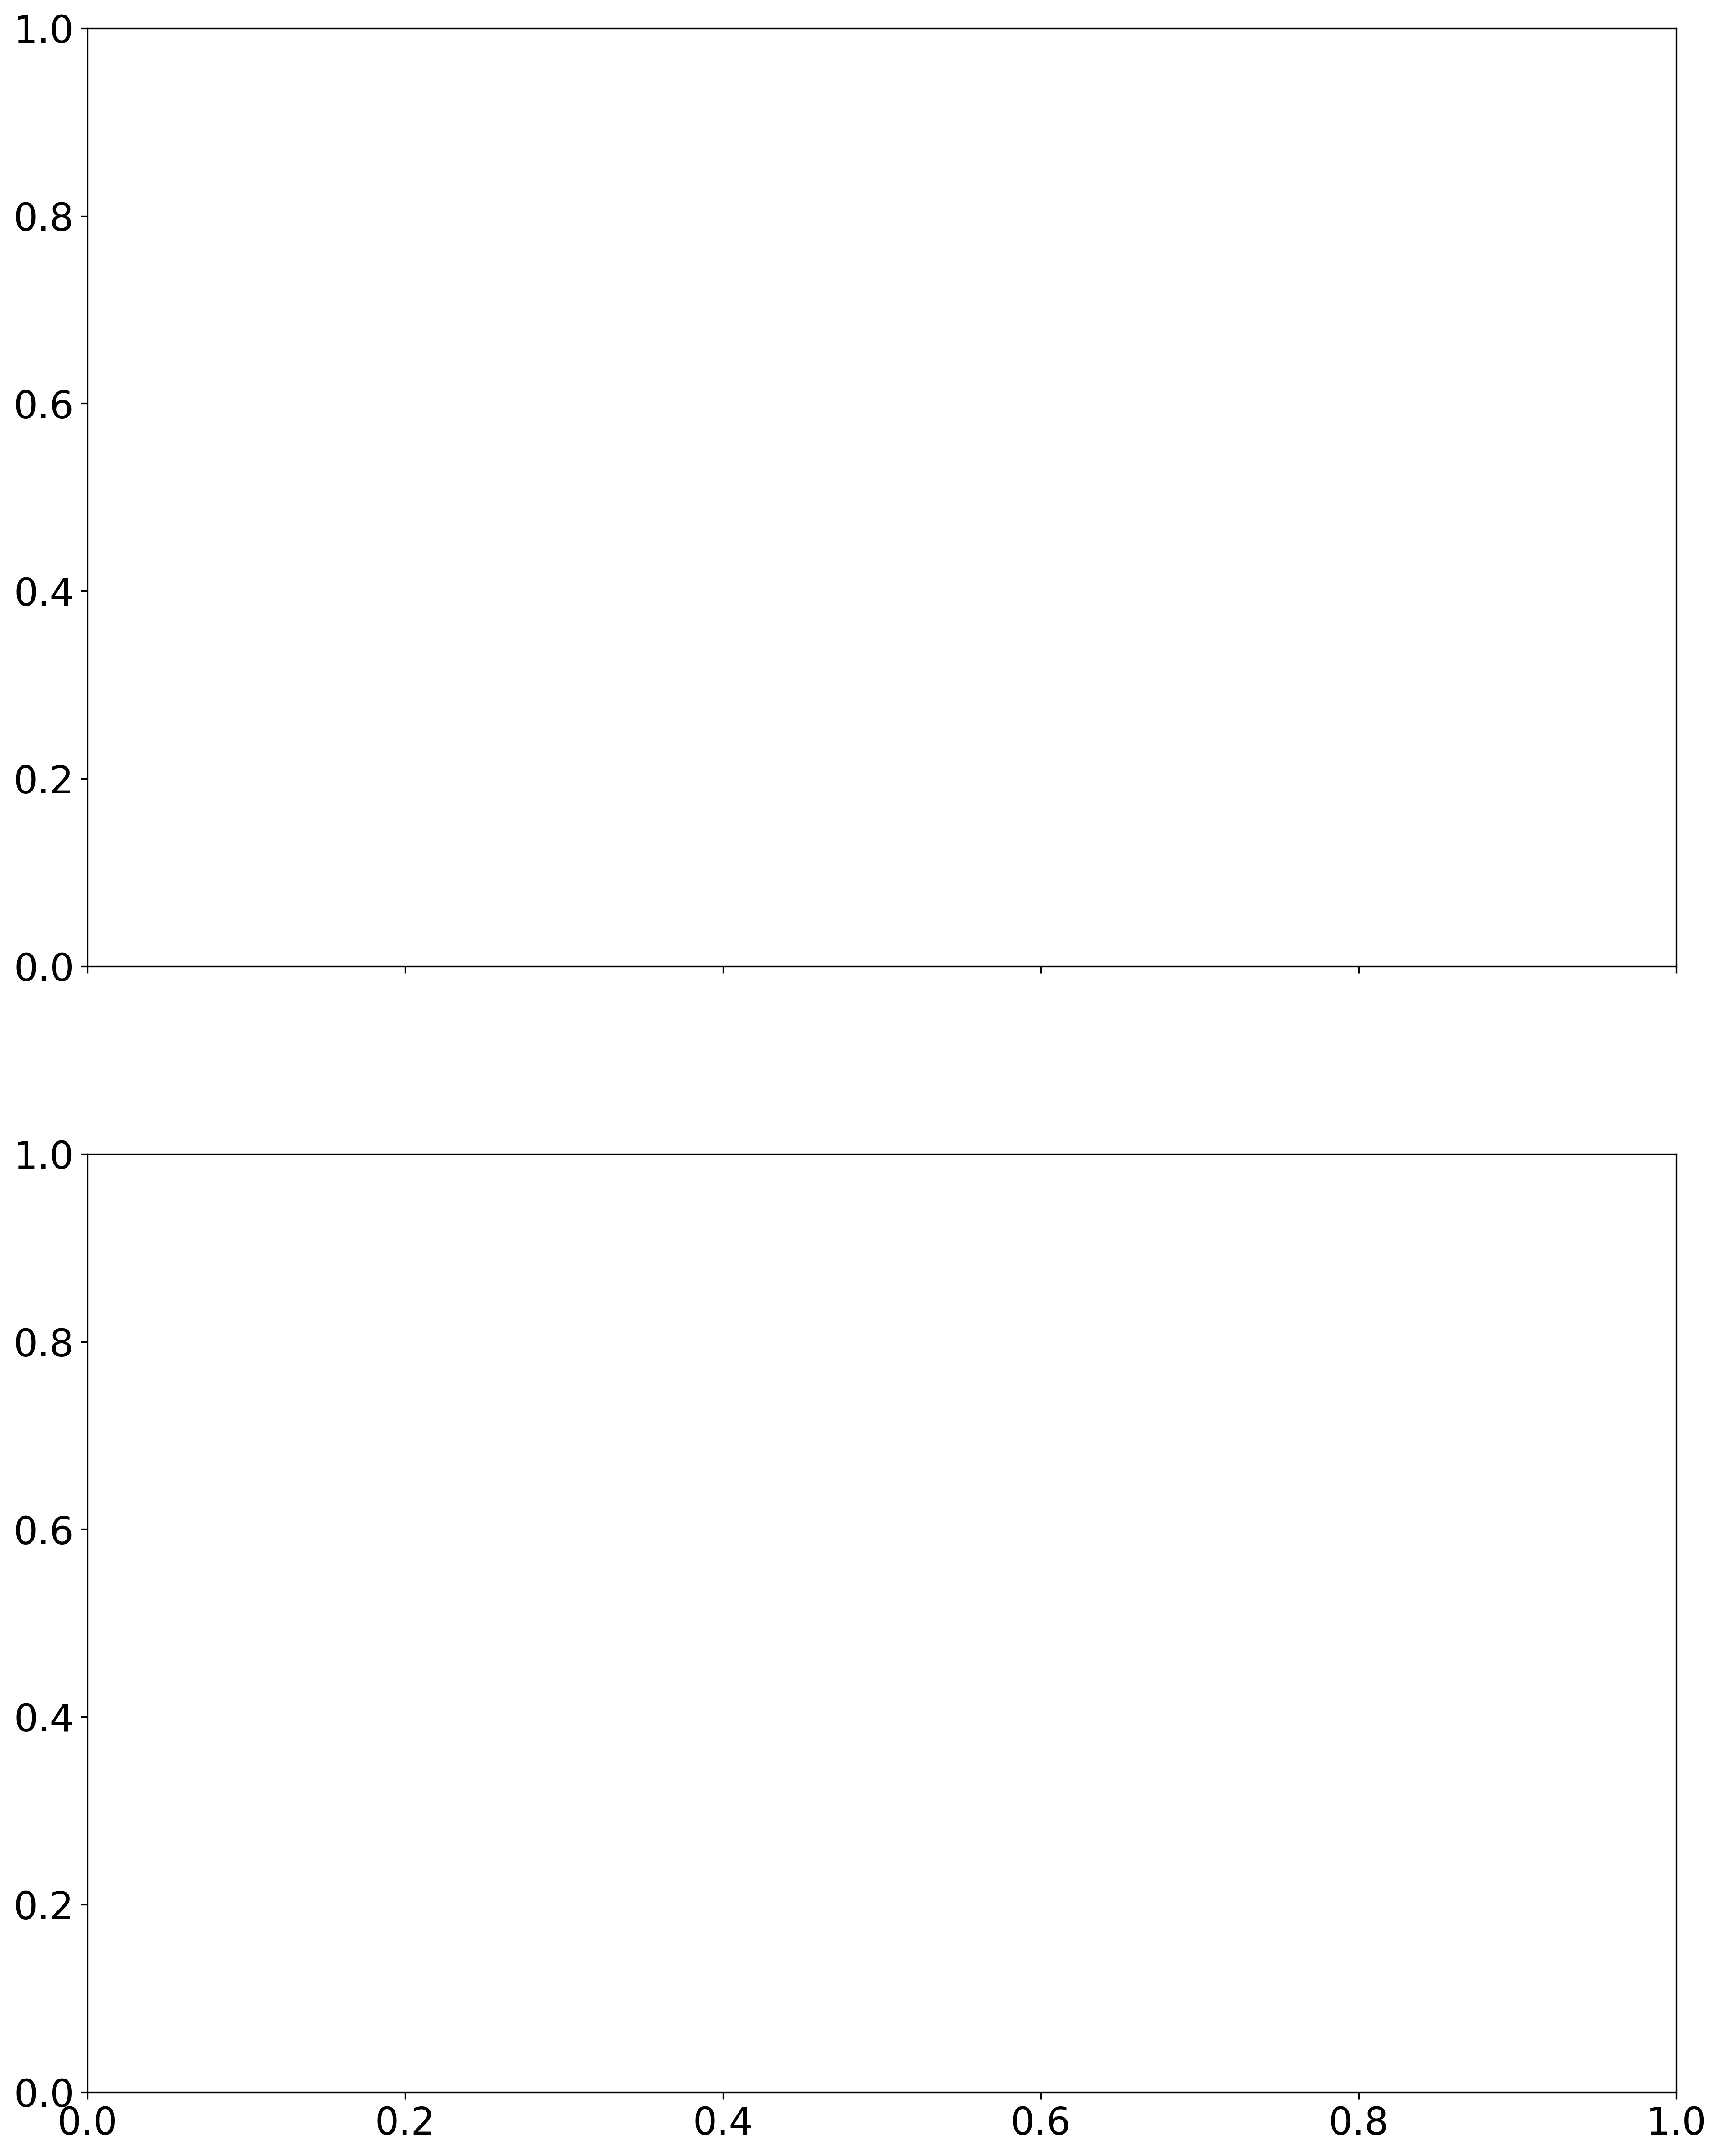

In [19]:
# Todo: bootstrap by adding / removing proteins?
# Figure 1 a + b
importlib.reload(analysis_utils)

custom_colors = {'cartesian_ddg_dir': 'orange',
                 'korpm_dir': 'orange',
                 #'esm1v_mean_dir': 'blue',
                 #'structural_dir': 'red',
                 'msa_transformer_mean_dir': 'green',
                 'tranception_dir': 'green',
                 #'evolutionary_dir': 'green',
                 'esm2_650M_dir': 'blue',
                 'esm2_15B_half_dir': 'blue',
                 #'esm2_150M_dir': 'blue',
                 'ankh_dir': 'blue',
                 #'esmif_monomer_dir': 'red',
                 'esmif_mean_dir': 'red',
                 #'esmif_monomer_masked_dir': 'red',
                 #'mpnn_mean_dir': 'red',
                 #'mpnn_10_00_dir': 'red',
                 'mpnn_20_00_dir': 'red',
                 #'mpnn_30_00_dir': 'red',
                 #'mpnn_mean_dir': 'red',
                 #'mif_mean_dir': 'red',
                 'mif_dir': 'red',
                 'mifst_dir': 'red',
                 'mutcomputex_dir': 'red',
                 'stability-oracle_dir': 'orange',
                 #'mifst_dir': 'purple',
                 'random_dir': 'grey',
                 'ddG_dir': 'grey'}

db_complete = db_class.join(db_feats_2.drop(['ProTherm', 'FireProt', 'ThermoFluor', 'is_curated'], axis=1), how='left')
db_complete['ddG_dir'] = db_complete['ddG']
db_complete['ΔΔG'] = db_complete['ddG']
#db_complete = db_complete.loc[~db_complete['ProTherm'].astype(bool)]

current_feats = ['ΔΔG', 'ddG']
db_fig = db_complete[[c for c in db_complete if '_dir' in c or c in current_feats or c == 'cluster']].fillna(0)
d = analysis_utils.compare_performance(
                        db_fig,
                        split_col = 'ΔΔG', 
                        split_col_2 = None, 
                        threshold_1 = 0, 
                        threshold_2 = -1.5, 
                        measurement = 'ddG',
                        statistic = 'spearman',
                        statistic_2 = 'weighted_spearman',
                        n_bootstraps=1000,
                        count_muts = True,
                        subset = list(custom_colors.keys()),
                        grouper = 'cluster'
                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

['ddG_dir', 'stability-oracle_dir', 'cartesian_ddg_dir', 'korpm_dir', 'mpnn_20_00_dir', 'mif_dir', 'mifst_dir', 'esmif_mean_dir', 'esm2_650M_dir', 'mutcomputex_dir', 'esm2_15B_half_dir', 'msa_transformer_mean_dir', 'ankh_dir', 'tranception_dir', 'random_dir']
class
1 >= delta_vol > -1     958
delta_vol <= -1        1651
delta_vol > 1           777
Name: n, dtype: int64


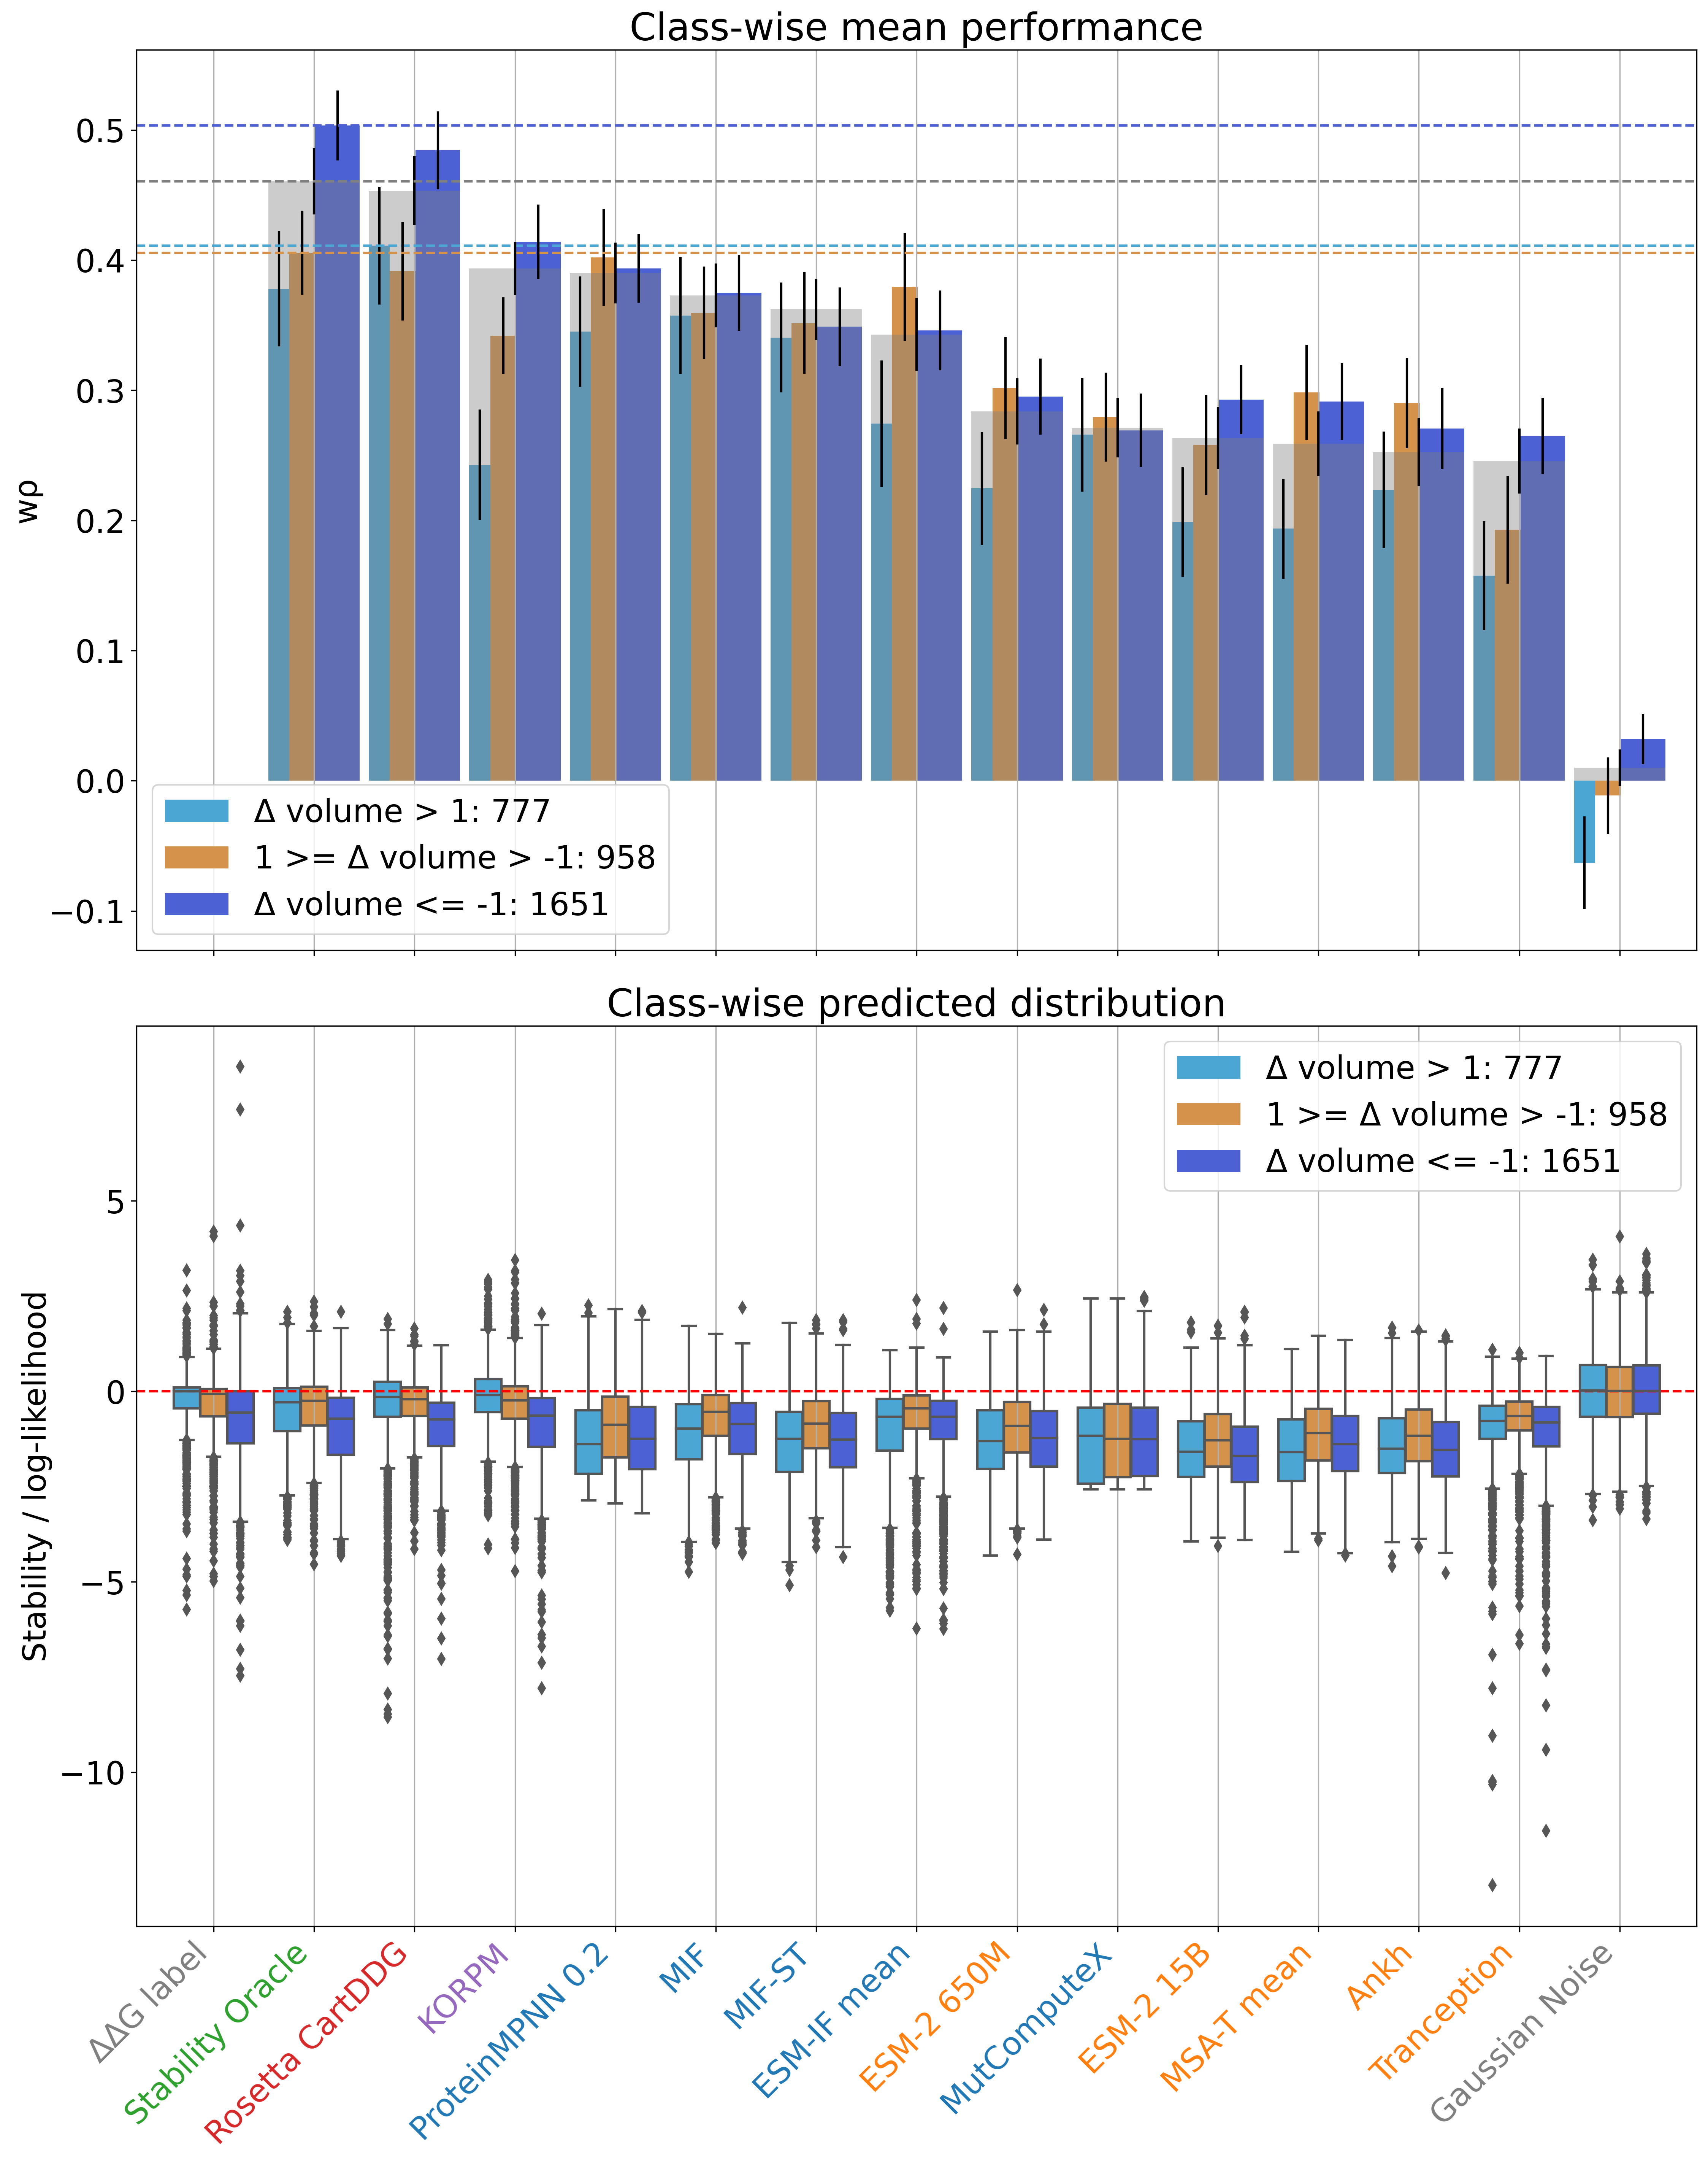

In [ ]:
# Figure 1 c + d

current_feats = ['delta_vol', 'ddG']
db_fig = db_complete[[c for c in db_complete if '_dir' in c or c in current_feats or c == 'cluster']].fillna(0)
d = analysis_utils.compare_performance(
                        db_fig,
                        split_col = 'delta_vol', 
                        split_col_2 = None, 
                        threshold_1 = 1, 
                        threshold_2 = -1, 
                        measurement = 'ddG',
                        statistic = 'spearman',
                        statistic_2 = 'weighted_spearman',
                        n_bootstraps=1000,
                        count_muts = True,
                        subset = list(custom_colors.keys()),
                        grouper = 'cluster'
                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

['ddG_dir', 'stability-oracle_dir', 'cartesian_ddg_dir', 'korpm_dir', 'mpnn_20_00_dir', 'mif_dir', 'mifst_dir', 'esmif_mean_dir', 'esm2_650M_dir', 'mutcomputex_dir', 'esm2_15B_half_dir', 'msa_transformer_mean_dir', 'ankh_dir', 'tranception_dir', 'random_dir']
class
delta_kdh <= 0 & rel_ASA <= 0.1     669
delta_kdh <= 0 & rel_ASA > 0.1      919
delta_kdh > 0 & rel_ASA <= 0.1      467
delta_kdh > 0 & rel_ASA > 0.1      1279
Name: n, dtype: int64


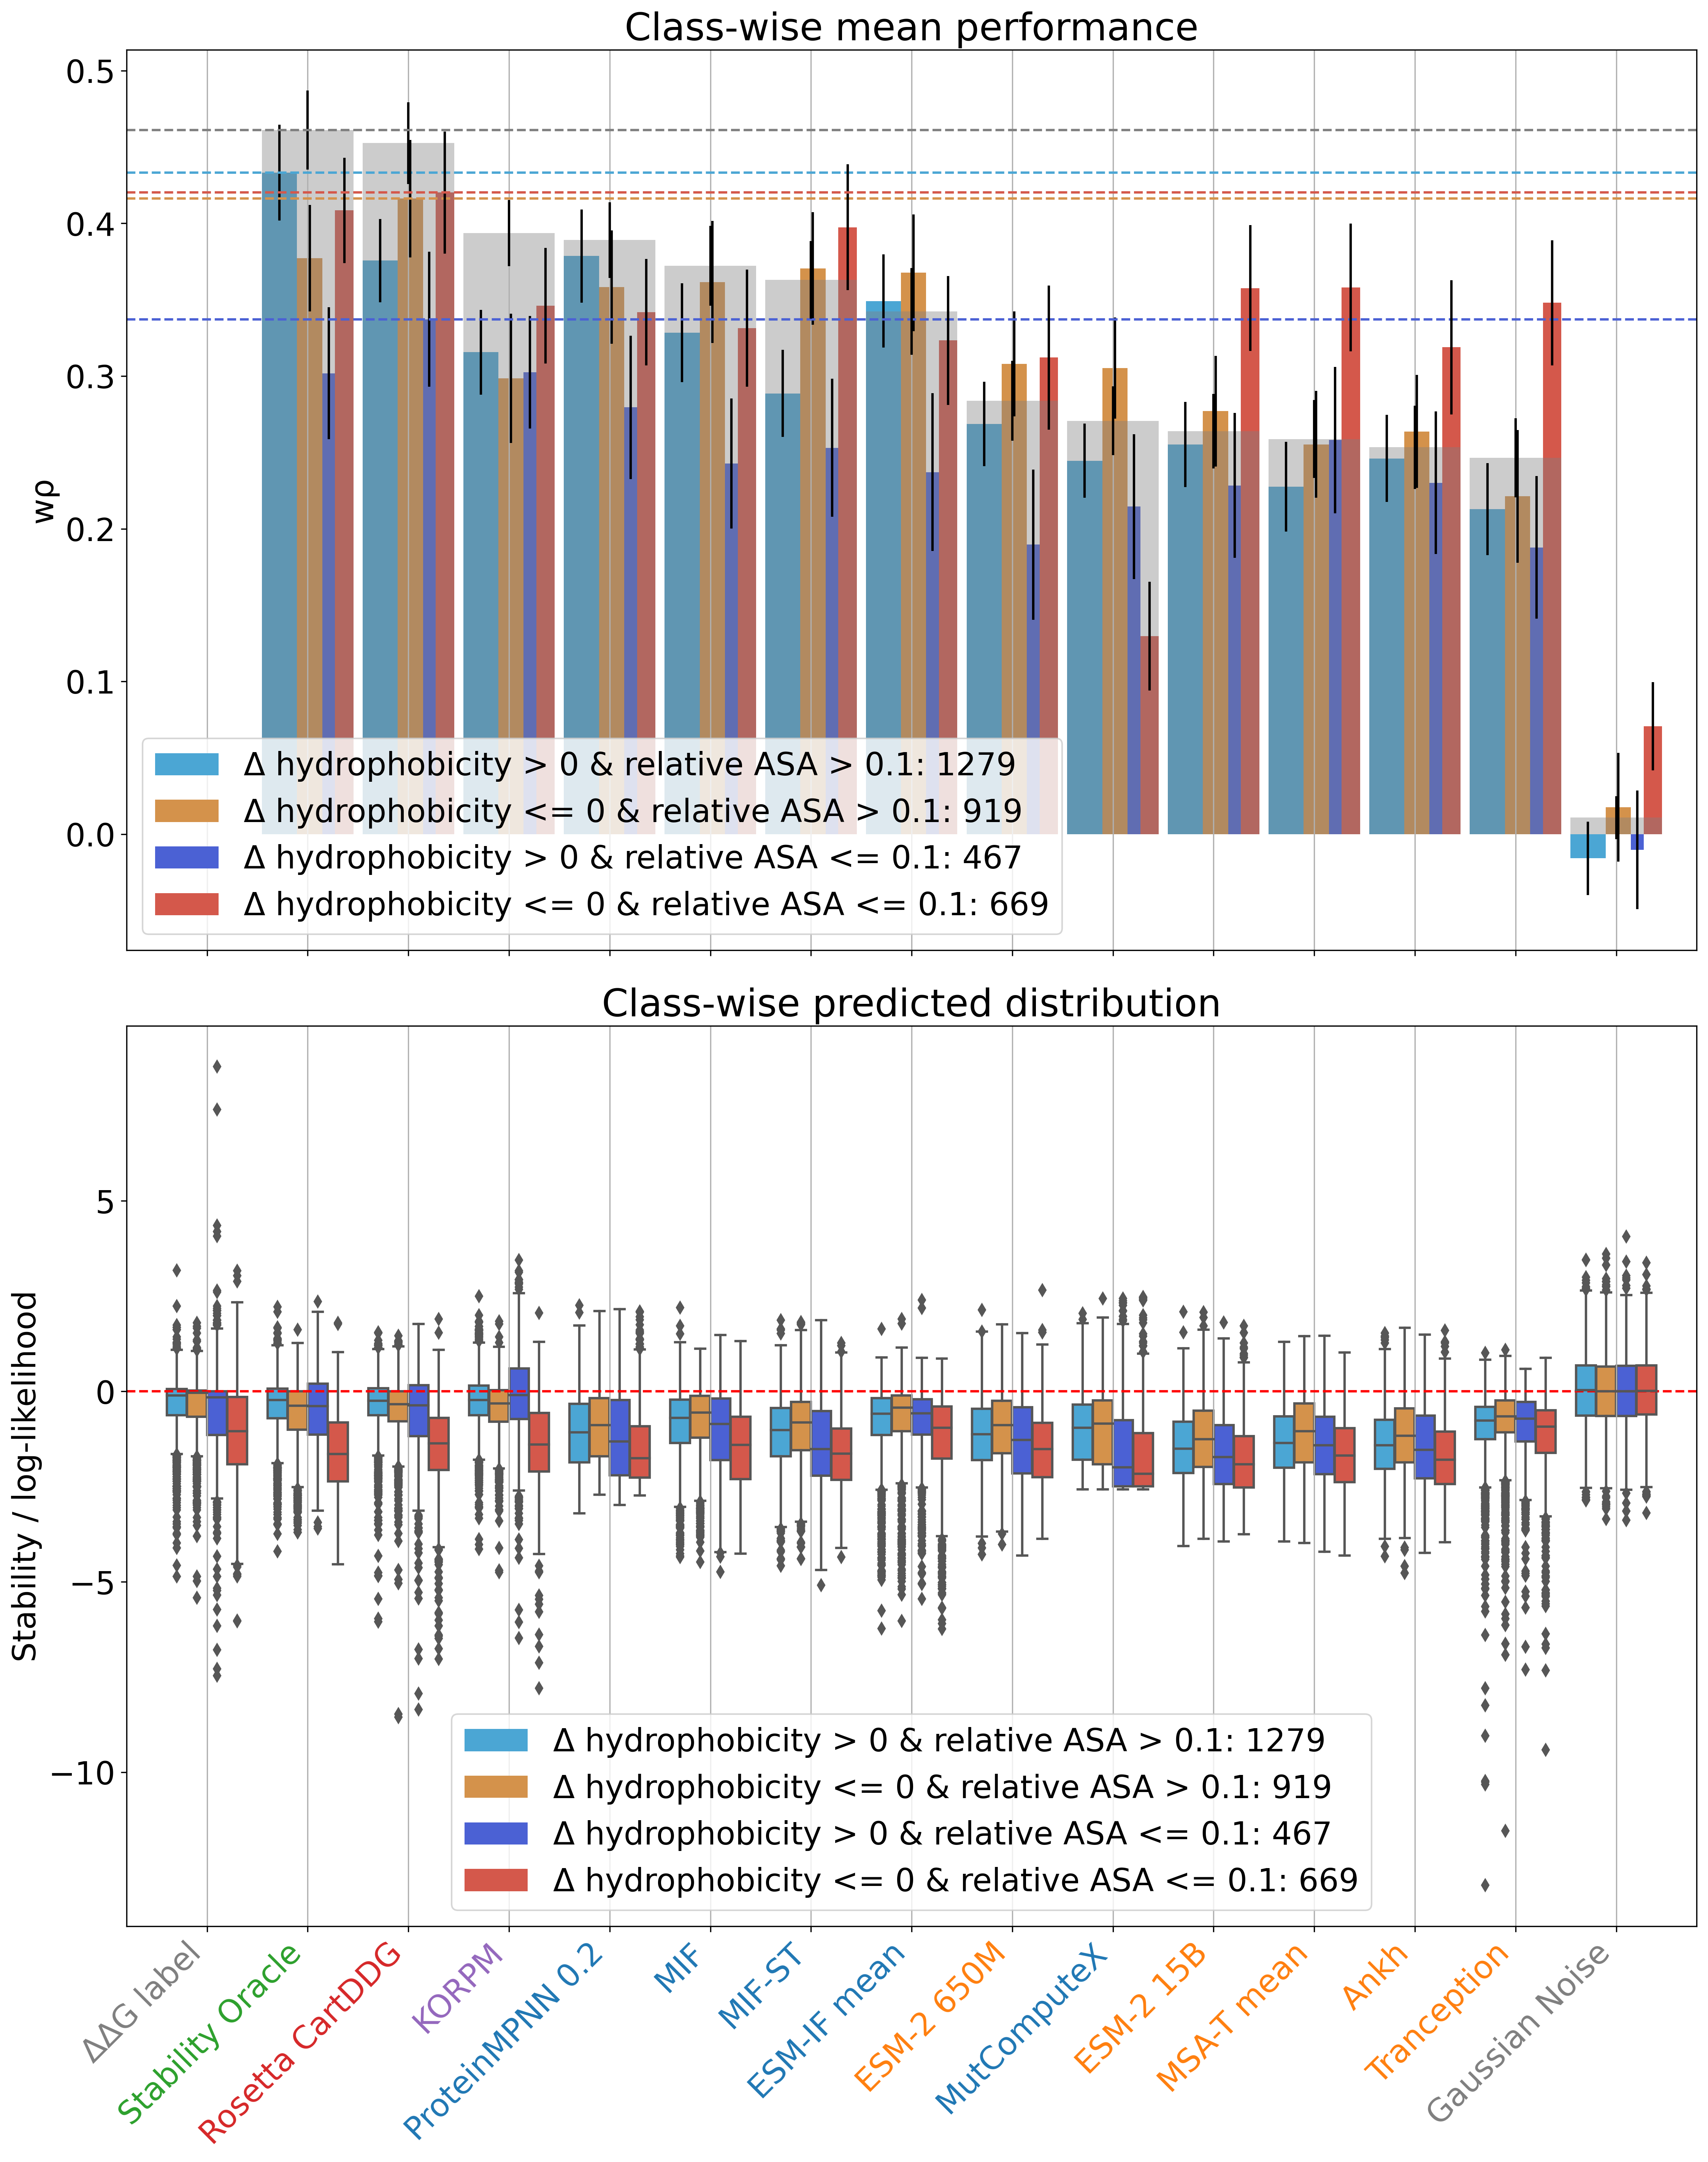

In [ ]:
# Supplementary Figure 2

current_feats = ['delta_kdh', 'rel_ASA', 'ddG']
db_fig = db_complete[[c for c in db_complete if '_dir' in c or c in current_feats or c == 'cluster']].fillna(0)
d = analysis_utils.compare_performance(
                        db_fig,
                        split_col = 'delta_kdh', 
                        split_col_2 = 'rel_ASA', 
                        threshold_1 = 0, 
                        threshold_2 = 0.1, 
                        measurement = 'ddG',
                        statistic = 'spearman',
                        statistic_2 = 'weighted_spearman',
                        n_bootstraps=1000,
                        count_muts = True,
                        subset = list(custom_colors.keys()),
                        grouper = 'cluster')

  0%|          | 0/1000 [00:00<?, ?it/s]

conservation > 80% : 568
conservation <= 80% : 2898
['ddG_dir', 'stability-oracle_dir', 'cartesian_ddg_dir', 'korpm_dir', 'mpnn_20_00_dir', 'mif_dir', 'mifst_dir', 'esmif_mean_dir', 'esm2_650M_dir', 'mutcomputex_dir', 'esm2_15B_half_dir', 'msa_transformer_mean_dir', 'ankh_dir', 'tranception_dir', 'random_dir']
class
conservation <= 80    2898
conservation > 80      568
Name: n, dtype: int64


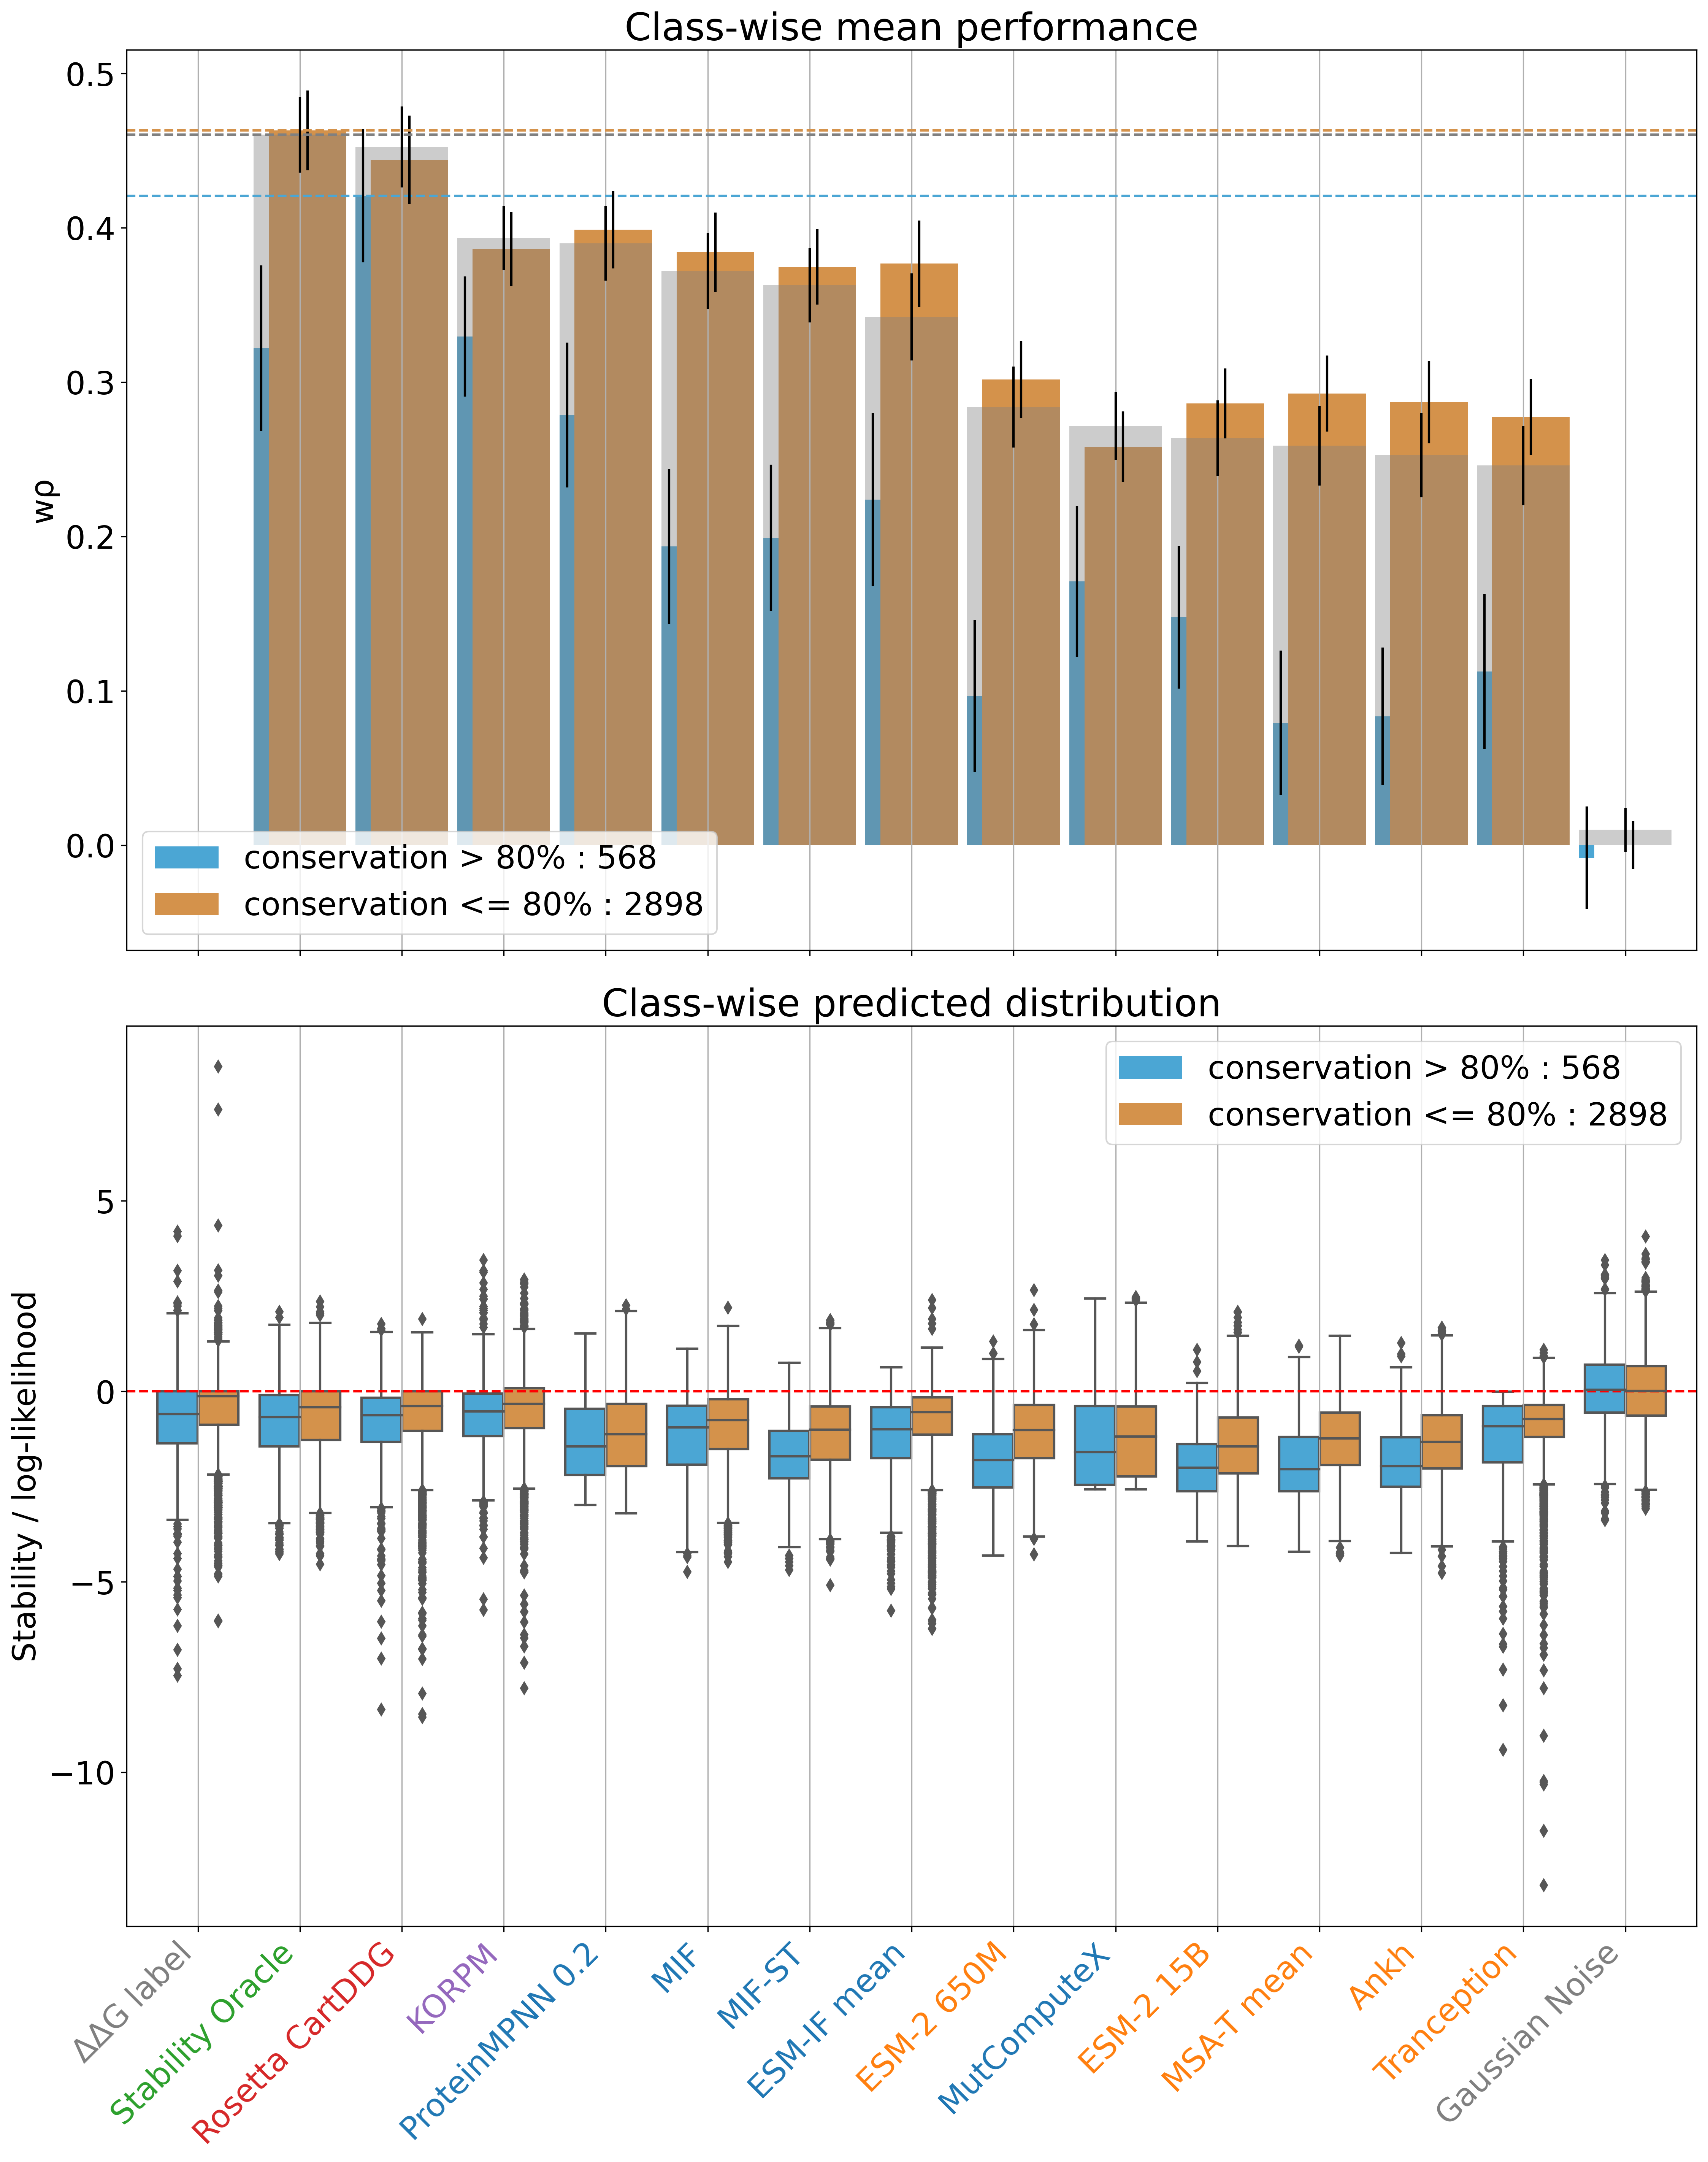

In [ ]:
# Supplementary Figure 3

current_feats = ['conservation', 'ddG']
db_fig = db_complete[[c for c in db_complete if '_dir' in c or c in current_feats or c == 'cluster']].fillna(0)
d = analysis_utils.compare_performance(
                        db_fig,
                        split_col = 'conservation', 
                        split_col_2 = None, 
                        threshold_1 = 80, 
                        threshold_2 = None, 
                        measurement = 'ddG',
                        statistic = 'spearman',
                        statistic_2 = 'weighted_spearman',
                        n_bootstraps=1000,
                        count_muts = True,
                        subset = list(custom_colors.keys()),
                        grouper = 'cluster')

  0%|          | 0/1000 [00:00<?, ?it/s]

['ddG_dir', 'cartesian_ddg_dir', 'mpnn_mean_dir', 'korpm_dir', 'mif_dir', 'mifst_dir', 'esmif_multimer_dir', 'msa_transformer_mean_dir', 'tranception_dir', 'esm1v_mean_dir']
class
is_nmr <= 0.5    3177
is_nmr > 0.5      292
Name: n, dtype: int64


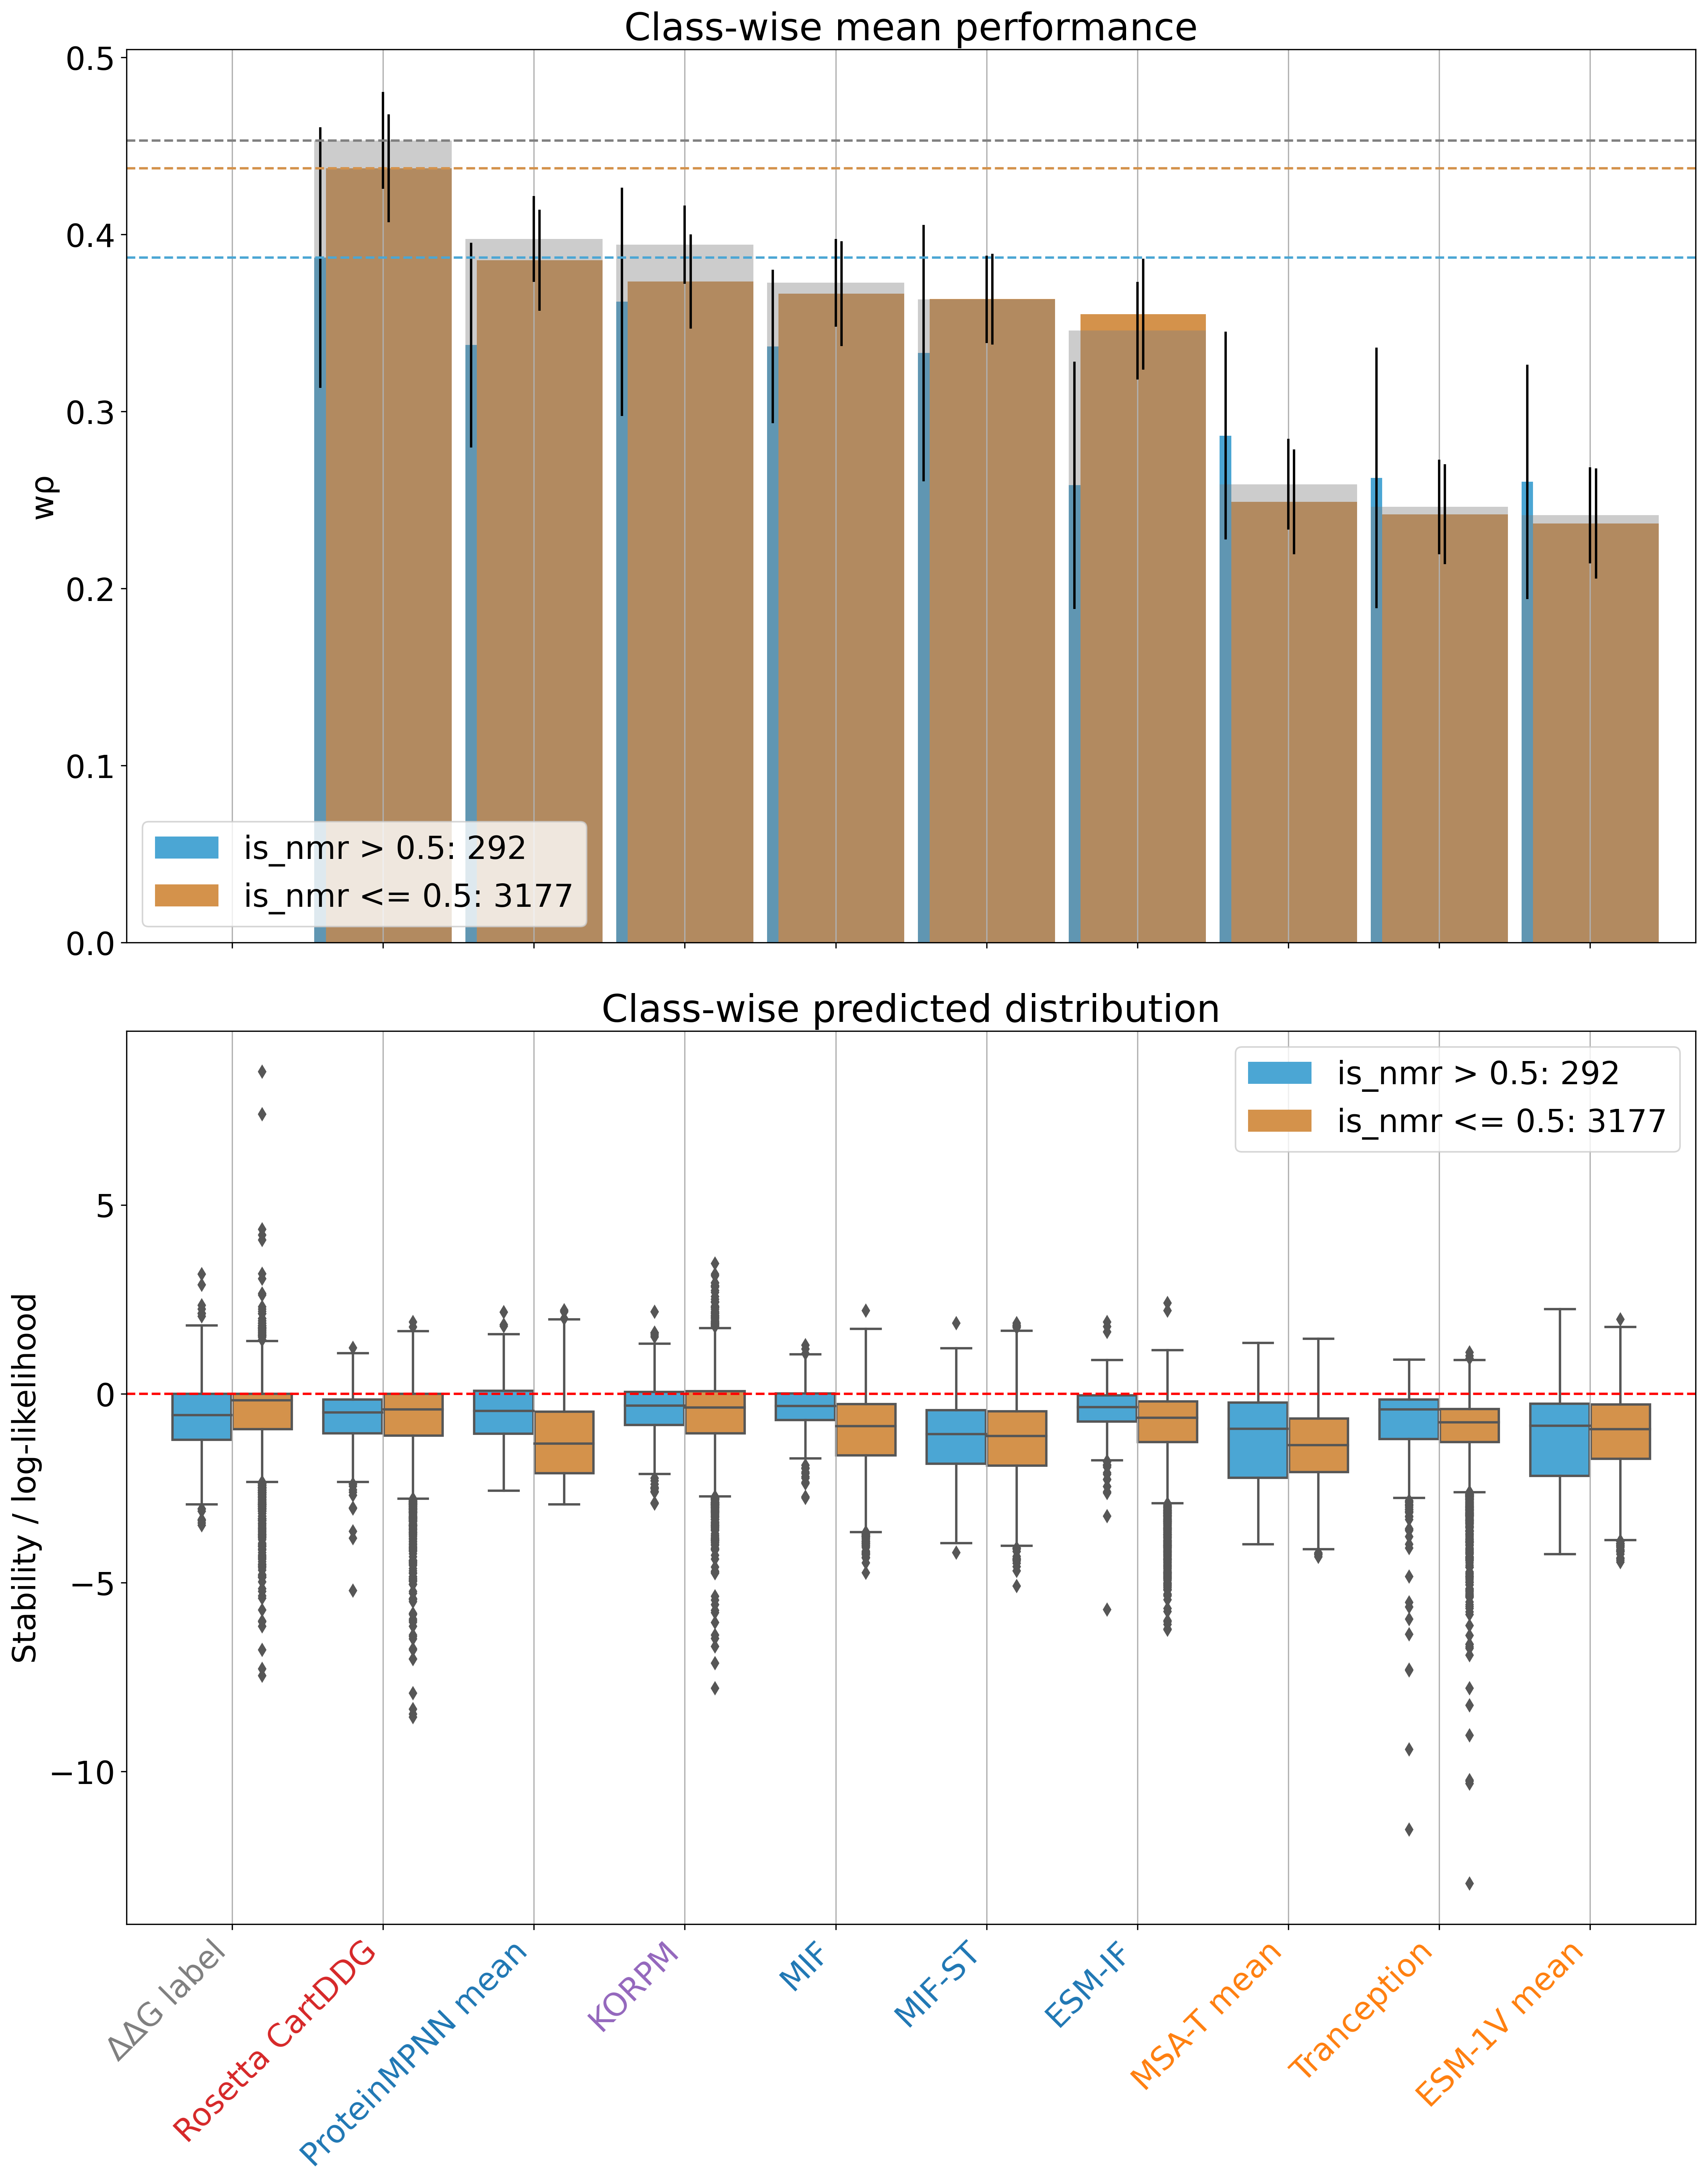

In [ ]:
custom_colors = {'cartesian_ddg_dir': 'red',
                 'korpm_dir': 'red',
                 'esm1v_mean_dir': 'blue',
                 'msa_transformer_mean_dir': 'green',
                 'tranception_dir': 'green',
                 #'esmif_monomer_dir': 'red',
                 'esmif_multimer_dir': 'red',
                 #'esmif_monomer_masked_dir': 'red',
                 'mpnn_mean_dir': 'red',
                 #'mpnn_10_00_dir': 'red',
                 #'mpnn_20_00_dir': 'red',
                 #'mpnn_30_03_dir': 'red',
                 #'mpnn_30_00_dir': 'red',
                 'mif_dir': 'red',
                 'mifst_dir': 'purple',
                 'ddG_dir': 'grey'}
                 
current_feats = ['is_nmr', 'ddG']
db_fig = db_complete[[c for c in db_complete if '_dir' in c or c in current_feats or c == 'cluster']].fillna(0)
d = analysis_utils.compare_performance(
                        db_fig,
                        split_col = 'is_nmr', 
                        split_col_2 = None, 
                        threshold_1 = 0.5, 
                        threshold_2 = None, 
                        measurement = 'ddG',
                        statistic = 'spearman',
                        statistic_2 = 'weighted_spearman',
                        n_bootstraps=1000,
                        count_muts = True,
                        subset = list(custom_colors.keys()),
                        grouper = 'cluster')

In [ ]:
# generate ensembles for Model Complementarity section

models = original_pred_cols_reduced + \
          ['rel_ASA_dir', 'delta_kdh_dir', 'delta_vol_dir', 'delta_chg_dir'] + \
            ['mpnn_mean_dir', 'esmif_mean_dir', 'esm2_mean_dir', 'mif_mean_dir']
#models = ['mpnn_20_00_dir', 'cartesian_ddg_dir', 'esm2_dir']

zs_feats = ['rel_ASA', 'delta_kdh', 'delta_vol', 'delta_chg']

db_summ = db_class.join(db_feats_2[zs_feats])#.join(db_clusters).join(db_ddg)#.drop('code', axis=1)
print(len(db_summ))
#db_summ = db_summ.loc[~db_summ['ProTherm'].astype(bool)]
#db_summ = db_summ.loc[db_summ['is_curated'].astype(bool)]
db_summ = db_summ.dropna(subset='cartesian_ddg_dir')
print(len(db_summ))
db_summ['ddG_dir'] = db_summ['ddG']
db_summ['dTm_dir'] = db_summ['dTm']
#db_summ['delta_vol_dir'] = db_summ['delta_vol'].transform(lambda x: -np.abs(x))
#db_summ['delta_kdh_dir'] = db_summ['delta_kdh'].transform(lambda x: -np.abs(x))
#db_summ['delta_chg_dir'] = db_summ['delta_chg'].transform(lambda x: -np.abs(x))
#db_summ['rel_ASA_dir'] = db_summ['rel_ASA']
db_summ['random_dir'] = np.random.normal(loc=0, size=len(db_summ))

dfm = db_summ#.join(db_feats_2[zs_feats].drop_duplicates(), how='left')
dfm['code'] = dfm.index.str[:4]
ren = dict(zip(zs_feats, [f+'_dir' for f in zs_feats]))
dfm = dfm.rename(ren, axis=1)
#dfm = dfm.drop(['is_curated'], axis=1)
dfr = db_runtimes.copy(deep=True)
dfr['code'] = dfr.index.str[:4]
dfr[['runtime_' + r for r in ['rel_ASA_dir', 'delta_kdh_dir', 'delta_vol_dir', 'delta_chg_dir']]] = 0

weights = [1, 0.5, 0.2] #, -0.2] # could include -0.2 to allow for subtracting models
weights2 = [] # fill in weights to test 3-model ensembles
#weights2 = [0.8, 0.3]

all_cols = []

tmp_preds = []
tmp_runtimes = []
for model1 in models:
    for model2 in models:
        if model1 != model2:
            for weight in weights:
                tmp_preds.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight, name=f'{model1} + {model2} * {weight}'))
                #tmp_preds.append(pd.Series((dfm[model1]-dfm[model1].min())/dfm[model1].max() + (dfm[model2]-dfm[model2].min())/dfm[model1].max() * weight, name=f'{model1} + {model2} * {weight}'))
                all_cols.append(f'{model1} + {model2} * {weight}')
                #tmp_runtimes.append(pd.Series(dfr['runtime_'+model1] + dfr['runtime_'+model2], name=f'runtime_'+all_cols[-1]))
                for model3 in models:
                    #if (model1.split('_')[0] != model3.split('_')[0]) and (model2.split('_')[0] != model3.split('_')[0]):
                        for weight2 in weights2:
                            tmp_preds.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight + dfm[model3]/dfm[model3].std() * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                            #tmp_preds.append(pd.Series((dfm[model1]-dfm[model1].min())/dfm[model1].max() + (dfm[model2]-dfm[model2].min())/dfm[model2].max() * weight + (dfm[model3]-dfm[model3].min())/dfm[model3].max() * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                            all_cols.append(f'{model1} + {model2} * {weight} + {model3} * {weight2}')
                            #tmp_runtimes.append(pd.Series(dfr['runtime_'+model1] + dfr['runtime_'+model2] + dfr['runtime_'+model3], name='runtime_'+all_cols[-1]))

print('concatenating')
dfm = pd.concat([dfm] + tmp_preds, axis=1)
dfr = pd.concat([dfr] + tmp_runtimes, axis=1)
#print('saving...')
#dfm.to_csv('~/zs_suppl/preds_ensemble_fireprot_3_models.csv')
print('joining...')
dfm = dfm.join(dfr.drop('code', axis=1))

5754
5754
concatenating
joining...


In [ ]:
def get_summary_df(db_complete, cols=None, class_stats=(), saveloc='../../zeroshot suppl/fireprot_summary.csv', overwrite=False):

    if not overwrite:
        assert not os.path.exists(saveloc)
    if cols is None:
        cols = db_complete.columns
        for extra in ['code', 'ProTherm', 'FireProt', 'is_curated', 'ThermoFluor']:
            if extra in cols:
                cols = cols.drop(extra)

    df_summ = analysis_utils.compute_stats(db_complete[cols], stats=class_stats, grouper='cluster', measurements=['ddG']).reset_index().set_index(['measurement', 'model'])
    df_summ = df_summ.reset_index().rename({'index': 'model'}, axis=1)
    df_summ = df_summ.set_index(['measurement', 'model_type', 'model', 'class'])

    df_summ.to_csv(saveloc)
    return df_summ

In [ ]:
# compute all statistics on the combined set (already done, takes ~12 hours)
#d1 = get_summary_df(dfm, saveloc=os.path.join(path, 'data', 'ensemble_fireprot_2_models_3_weights_revised_over_10_in_cluster_new.csv'), overwrite=True)
d1 = pd.read_csv(os.path.join(path, 'data', 'ensemble_fireprot_2_models_3_weights_revised_over_10_in_cluster_new.csv')).set_index(['measurement', 'model_type', 'model', 'class'])
d1.xs('ddG').sort_values('weighted_ndcg', ascending=False).iloc[:20, 13:]

auroc  \
model_type  model                                     class             
unknown     ddG_dir                                   NaN    1.000000   
            dTm_dir                                   NaN    0.943406   
biophysical cartesian_ddg_dir + mpnn_mean_dir * 0.5   NaN    0.789848   
            cartesian_ddg_dir + mpnn_30_00_dir * 0.5  NaN    0.785957   
            cartesian_ddg_dir + mpnn_20_00_dir * 0.5  NaN    0.790104   
structural  mpnn_rosetta_dir                          NaN    0.793187   
potential   korpm_dir + mpnn_30_00_dir * 1            NaN    0.755436   
            mpnn_30_00_dir + korpm_dir * 1            NaN    0.755436   
biophysical cartesian_ddg_dir + mpnn_10_00_dir * 0.5  NaN    0.789124   
potential   korpm_dir + mpnn_mean_dir * 1             NaN    0.762663   
            mpnn_mean_dir + korpm_dir * 1             NaN    0.762663   
biophysical cartesian_ddg_dir + mpnn_mean_dir * 1     NaN    0.772454   
            mpnn_mean_dir + cartesian_ddg_dir * 1     NaN    0.772454   
            mpnn_mean_dir + cartesian_ddg_dir * 0.5   NaN    0.751501   
            cartesian_ddg_dir + mpnn_20_00_dir * 1    NaN    0.772130   
            mpnn_20_00_dir + cartesian_ddg_dir * 1    NaN    0.772130   
            cartesian_ddg_dir + mpnn_10_00_dir * 0.2  NaN    0.796856   
transfer    mpnn_20_00_dir + stability-oracle_dir * 1 NaN    0.771729   
            stability-oracle_dir + mpnn_20_00_dir * 1 NaN    0.771729   
potential   mpnn_mean_dir + korpm_dir * 0.5           NaN    0.748090   

                                                                auprc  \
model_type  model                                     class             
unknown     ddG_dir                                   NaN    1.000000   
            dTm_dir                                   NaN    0.854619   
biophysical cartesian_ddg_dir + mpnn_mean_dir * 0.5   NaN    0.568603   
            cartesian_ddg_dir + mpnn_30_00_dir * 0.5  NaN    0.560265   
            cartesian_ddg_dir + mpnn_20_00_dir * 0.5  NaN    0.569398   
structural  mpnn_rosetta_dir                          NaN    0.570926   
potential   korpm_dir + mpnn_30_00_dir * 1            NaN    0.523148   
            mpnn_30_00_dir + korpm_dir * 1            NaN    0.523148   
biophysical cartesian_ddg_dir + mpnn_10_00_dir * 0.5  NaN    0.566514   
potential   korpm_dir + mpnn_mean_dir * 1             NaN    0.529428   
            mpnn_mean_dir + korpm_dir * 1             NaN    0.529428   
biophysical cartesian_ddg_dir + mpnn_mean_dir * 1     NaN    0.553707   
            mpnn_mean_dir + cartesian_ddg_dir * 1     NaN    0.553707   
            mpnn_mean_dir + cartesian_ddg_dir * 0.5   NaN    0.531601   
            cartesian_ddg_dir + mpnn_20_00_dir * 1    NaN    0.552843   
            mpnn_20_00_dir + cartesian_ddg_dir * 1    NaN    0.552843   
            cartesian_ddg_dir + mpnn_10_00_dir * 0.2  NaN    0.565993   
transfer    mpnn_20_00_dir + stability-oracle_dir * 1 NaN    0.536715   
            stability-oracle_dir + mpnn_20_00_dir * 1 NaN    0.536715   
potential   mpnn_mean_dir + korpm_dir * 0.5           NaN    0.520275   

                                                             0.0_n_stable  \
model_type  model                                     class                 
unknown     ddG_dir                                   NaN           755.0   
            dTm_dir                                   NaN           381.0   
biophysical cartesian_ddg_dir + mpnn_mean_dir * 0.5   NaN          1275.0   
            cartesian_ddg_dir + mpnn_30_00_dir * 0.5  NaN          1275.0   
            cartesian_ddg_dir + mpnn_20_00_dir * 0.5  NaN          1275.0   
structural  mpnn_rosetta_dir                          NaN          1275.0   
potential   korpm_dir + mpnn_30_00_dir * 1            NaN          1275.0   
            mpnn_30_00_dir + korpm_dir * 1            NaN          1275.0   
biophysical cartesian_ddg_dir + mpnn_10_00_dir * 0.5  NaN          1275.0   
pot

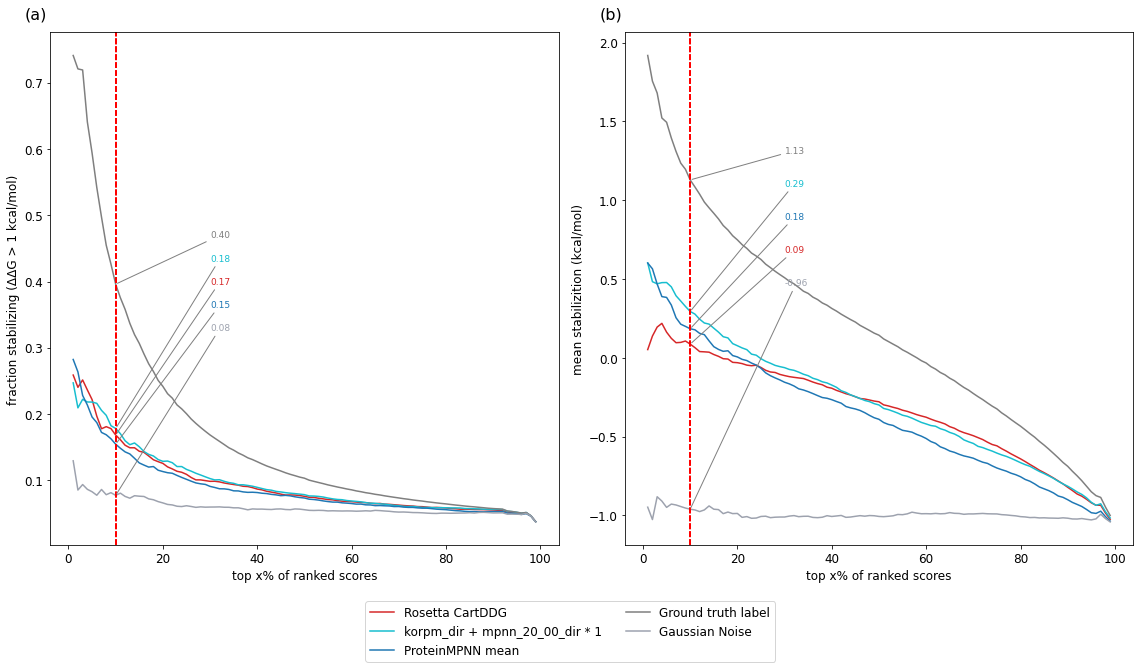

In [ ]:
importlib.reload(analysis_utils)
# extra figure (not in text)
analysis_utils.recovery_curves(d1.reset_index(), ['mpnn_mean_dir', 'cartesian_ddg_dir', 'korpm_dir + mpnn_20_00_dir * 1', 'ddG_dir', 'dTm_dir', 'random_dir'], spacing=0.07, measurements=['ddG'])

4719
           cartesian_ddg_dir + mpnn_20_00_dir * 0.5  \
uid                                                   
1A43_291D                                 -1.992190   
1A43_299A                                 -1.540987   
1A43_316A                                 -2.224605   
1A43_350S                                 -1.190101   
1A43_288A                                 -0.851854   
...                                             ...   
5AZU_115A                                 -1.750773   
5AZU_115T                                 -1.560532   
5AZU_117A                                 -4.406755   
8TIM_179A                                 -0.077658   
8TIM_193A                                  0.472107   

           cartesian_ddg_dir + mif_dir * 0.5  \
uid                                            
1A43_291D                          -1.411790   
1A43_299A                          -1.158576   
1A43_316A                          -0.675175   
1A43_350S                          -0.7

  0%|          | 0/3 [00:00<?, ?it/s]

2406.2616666666668
['Rosetta CartDDG', 'ProteinMPNN 0.2', 'MIF-ST', 'Tranception', 'ESM-IF', 'ESM-2 3B', 'MIF', 'MSA-T mean', 'Ankh', 'ESM-1V mean', 'KORPM', 'Δ volume', 'Δ hydrophobicity', 'relative ASA']


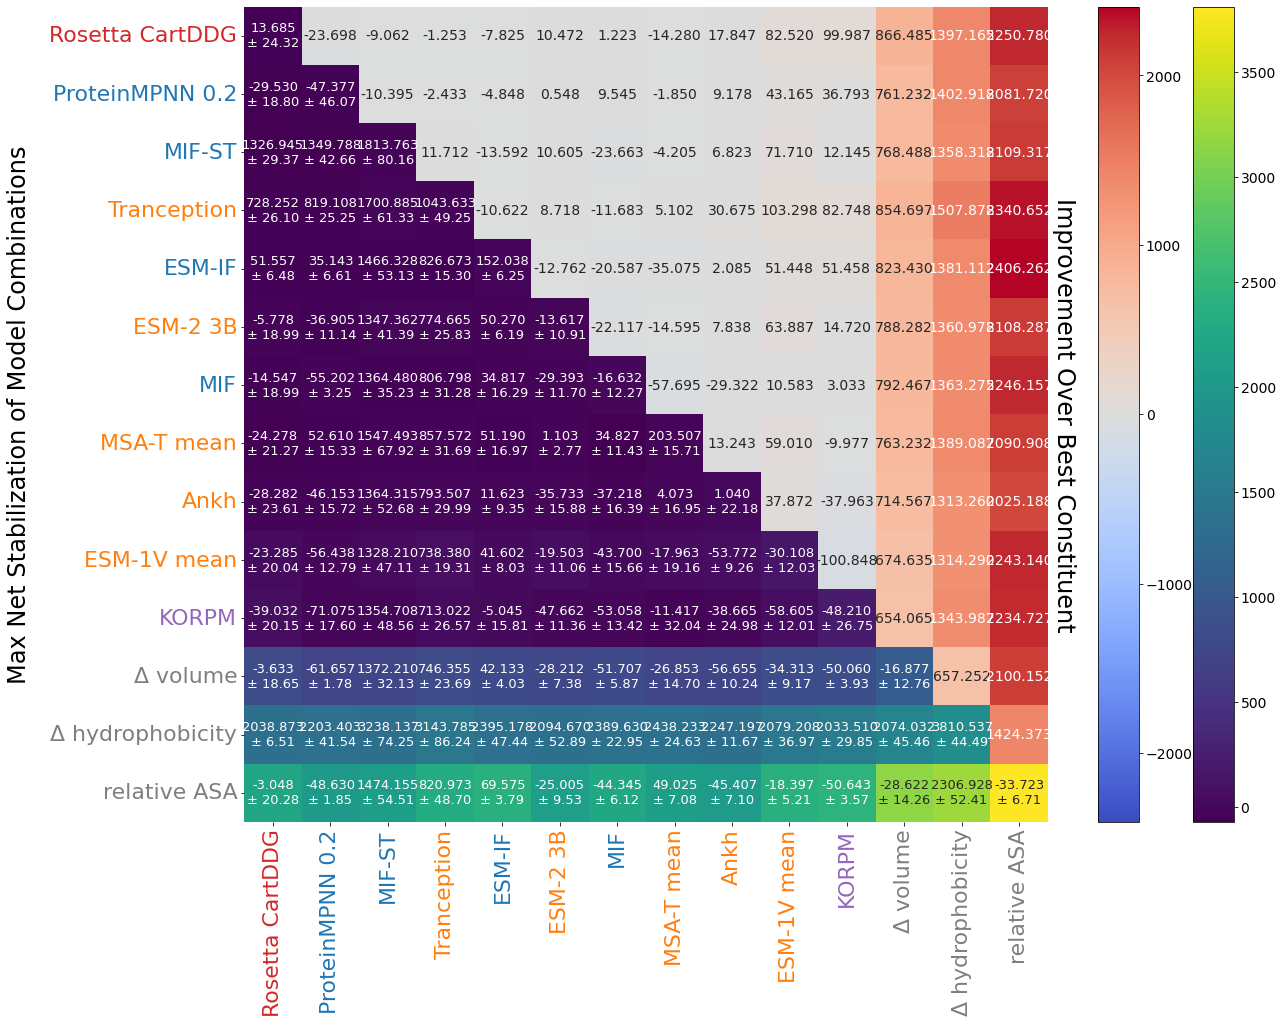

rank              model1 weight1          model2 weight2  \
0       1         rel_ASA_dir       1   delta_kdh_dir     0.2   
1       1         rel_ASA_dir       1   delta_vol_dir     0.2   
2       1         rel_ASA_dir       1   delta_kdh_dir     0.5   
3       1         rel_ASA_dir       1   delta_kdh_dir       1   
4       1         rel_ASA_dir       1   delta_vol_dir     0.5   
..    ...                 ...     ...             ...     ...   
450     1  esmif_multimer_dir       1       korpm_dir     0.5   
451     1           korpm_dir       1  mpnn_20_00_dir       1   
452     1   cartesian_ddg_dir       1  mpnn_20_00_dir       1   
453     1   cartesian_ddg_dir       1         mif_dir     0.5   
454     1   cartesian_ddg_dir       1  mpnn_20_00_dir     0.5   

    mean_net_stabilization   p_value  
0              3238.136667  0.001352  
1                 3143.785  0.010998  
2              2835.243333  0.000755  
3                  2560.95   0.00033  
4                 2555.425  0.003345  
..                     ...       ...  
450            -143.358333   0.00157  
451                -144.55    0.0023  
452               -149.215  0.039758  
453               -149.395  0.001586  
454            -164.533333  0.031954  

[455 rows x 7 columns]

In [ ]:
# Figure 3
importlib.reload(analysis_utils)
custom_colors = {
                 'cartesian_ddg_dir': 'red',
                 'esm1v_mean_dir': 'blue',
                 'msa_transformer_mean_dir': 'green',
                 'tranception_dir': 'green',
                 'ankh_dir': 'blue',
                 'esm2_dir': 'blue',
                 #'esmif_monomer_dir': 'red',
                 'esmif_multimer_dir': 'purple',
                 #'esmif_multimer_full_masked_dir': 'red',
                 #'mpnn_10_00_dir': 'red',
                 'mpnn_20_00_dir': 'red',
                 #'mpnn_30_00_dir': 'red',
                 #'mpnn_30_03_dir': 'red',
                 'mif_dir': 'red',
                 'mifst_dir': 'purple',
                 'korpm_dir': 'red',
                 'delta_kdh_dir': 'blue',
                 'delta_vol_dir': 'blue',
                 #'delta_chg_dir': 'blue',
                 #'random_dir': 'black',
                 'rel_ASA_dir': 'red',
                }

measurement = 'ddG'
statistic = 'net_stabilization'

d3 = d1.copy(deep=True)
d3 = d3.reset_index()
d3 = d3.set_index(['measurement', 'model_type', 'model', 'class'])
d3 = d3.drop([c for c in d3.columns if 'pos_' in c], axis=1)

stat_df, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm, db_ddg, statistic, measurement, n_bootstraps=3, subset=list(custom_colors.keys()), grouper=None, upper='delta')
stat_df = stat_df.sort_values(f'mean_{statistic}', ascending=False).drop_duplicates(subset=['weight1', 'weight2', f'mean_{statistic}', 'p_value']).reset_index()
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1

#stat_df.to_csv('~/zs_suppl/model_combinations_ddG_net_stab_nonneg_test.csv')
stat_df

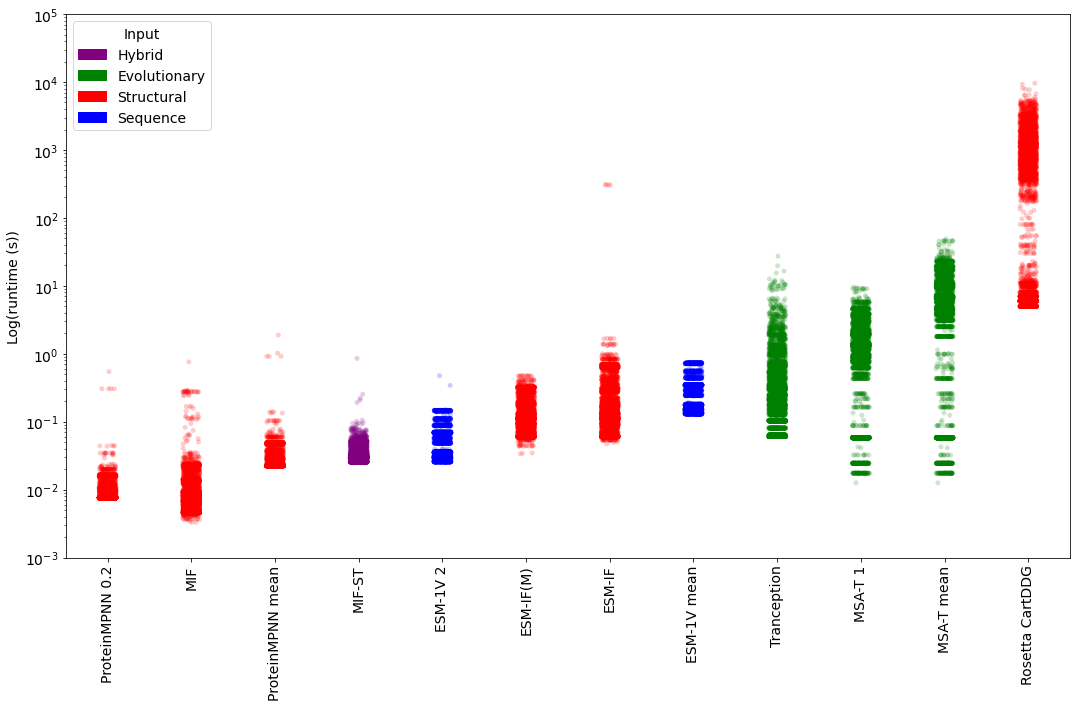

In [ ]:
# SUPPLEMENTARY FIGURE 5

int_runtimes = db_runtimes.dropna(axis=1, how='all')#.groupby('code').mean()#.sum() #uncomment to get mean per protein
int_runtimes = int_runtimes[[
                             'runtime_esmif_monomer_dir',
                             'runtime_esmif_multimer_dir',
                             'runtime_mif_dir',
                             'runtime_mifst_dir',
                             'runtime_mpnn_20_00_dir',
                             'runtime_mpnn_mean_dir',
                             'runtime_tranception_dir',
                             'runtime_msa_transformer_mean_dir',
                             'runtime_msa_1_dir',
                             'runtime_esm1v_mean_dir',
                             'runtime_esm1v_2_dir',
                             'runtime_cartesian_ddg_dir',
                            ]]

int_runtimes.columns = [c[8:-4] for c in int_runtimes.columns]
total_runtimes = int_runtimes.melt().sort_values('value')#.sum(axis=0)

### determine order for displaying runtimes
# Calculate the grouped median
grouped_median = total_runtimes.groupby('variable')['value'].median()
# Create a temporary column 'group_median' with the grouped medians mapped to each row
total_runtimes['group_median'] = total_runtimes['variable'].map(grouped_median)
# Sort the DataFrame first by 'group_median' and then by 'variable'
df_sorted = total_runtimes.sort_values(['group_median', 'variable'], ascending=True)
# Drop the temporary column 'group_median'
total_runtimes = df_sorted.drop(columns=['group_median'])

hybrid = ['mifst']
evolutionary = ['tranception', 'msa_transformer_mean', 'msa_1']
sequence = ['esm1v_mean', 'esm1v_2']
structural = ['cartesian_ddg', 'esmif_multimer', 'esmif_multimer', 'esmif_monomer', 'mpnn_20_00', 'mpnn_mean', 'mif', 'korpm']

cmap = {}
for h in hybrid:
    cmap.update({h: 'purple'})
for e in evolutionary:
    cmap.update({e: 'green'})
for s in structural:
    cmap.update({s: 'red'})
for s in sequence:
    cmap.update({s: 'blue'})

hybrid_patch = Patch(color='purple', label='Hybrid')
evolutionary_patch = Patch(color='green', label='Evolutionary')
structural_patch = Patch(color='red', label='Structural')
sequence_patch = Patch(color='blue', label='Sequence')

fig, ax = plt.subplots(figsize=(1.5*total_runtimes['variable'].nunique(), 10))  # adjust the size here
ax = sns.stripplot(data=total_runtimes, x='variable', y='value', palette=cmap, alpha=0.2)
ax.legend(handles=[hybrid_patch, evolutionary_patch, structural_patch, sequence_patch], title='Input', loc='upper left')

remapped_x = [remap_names[tick.get_text()] if tick.get_text() in remap_names.keys() else tick.get_text() for tick in ax.get_xticklabels()]
ax.set_xticklabels(remapped_x)
ax.set_yticklabels(remapped_x[::-1])
plt.yscale('log')
plt.ylim(10e-4, 10e4)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Log(runtime (s))')
plt.show()

In [ ]:
# SUPPLEMENTARY FIGURE 6

measurement = 'ddG'
statistic = 'auprc'

stat_df, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm, db_measurements, statistic, measurement, n_bootstraps=100, custom_colors=custom_colors)
stat_df = stat_df.sort_values(f'mean_{statistic}', ascending=False).drop_duplicates(subset=['weight1', 'weight2', f'mean_{statistic}', 'p_value']).reset_index()
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1

#stat_df.to_csv('../../zs_suppl/model_combinations_ddG_auprc_nonneg.csv')
stat_df.head(30)


TypeError: model_combinations_heatmap() got an unexpected keyword argument 'custom_colors'

  0%|          | 0/5 [00:00<?, ?it/s]

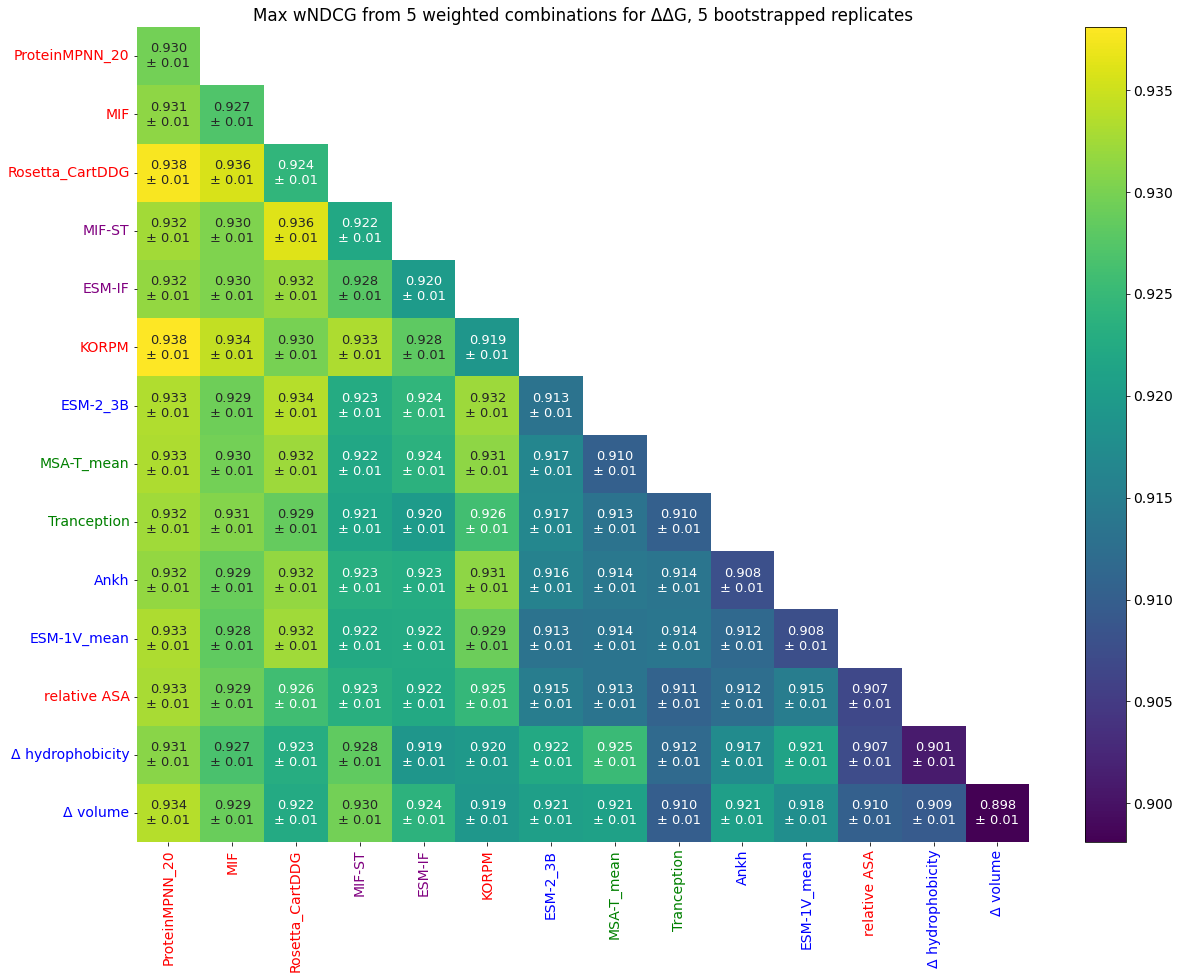

rank             model1 weight1                    model2 weight2  \
0      1          korpm_dir       1            mpnn_20_00_dir       1   
1      1     mpnn_20_00_dir       1                 korpm_dir     0.5   
2      1  cartesian_ddg_dir       1            mpnn_20_00_dir     0.5   
3      1  cartesian_ddg_dir       1            mpnn_20_00_dir       1   
4      1  cartesian_ddg_dir       1                 mifst_dir     0.5   
5      1  cartesian_ddg_dir       1                   mif_dir       1   
6      1          korpm_dir       1            mpnn_20_00_dir     0.5   
7      1     mpnn_20_00_dir       1                 korpm_dir     0.2   
8      1            mif_dir       1                 korpm_dir     0.5   
9      1  cartesian_ddg_dir       1                   mif_dir     0.5   
10     1            mif_dir       1                 korpm_dir       1   
11     1  cartesian_ddg_dir       1                 mifst_dir     0.2   
12     1     mpnn_20_00_dir       1         cartesian_ddg_dir     0.5   
13     1          mifst_dir       1         cartesian_ddg_dir       1   
14     1  cartesian_ddg_dir       1            mpnn_20_00_dir     0.2   
15     1            mif_dir       1         cartesian_ddg_dir     0.5   
16     1  cartesian_ddg_dir       1                  esm2_dir     0.5   
17     1     mpnn_20_00_dir       1             delta_vol_dir     0.5   
18     1     mpnn_20_00_dir       1                  esm2_dir     0.2   
19     1          mifst_dir       1                 korpm_dir       1   
20     1     mpnn_20_00_dir       1            esm1v_mean_dir     0.5   
21     1     mpnn_20_00_dir       1  msa_transformer_mean_dir     0.2   
22     1     mpnn_20_00_dir       1                  esm2_dir     0.5   
23     1     mpnn_20_00_dir       1               rel_ASA_dir     0.5   
24     1          korpm_dir       1                 mifst_dir     0.5   
25     1     mpnn_20_00_dir       1                 mifst_dir     0.5   
26     1     mpnn_20_00_dir       1  msa_transformer_mean_dir     0.5   
27     1     mpnn_20_00_dir       1           tranception_dir     0.5   
28     1  cartesian_ddg_dir       1                   mif_dir     0.2   
29     1  cartesian_ddg_dir       1            esm1v_mean_dir     0.5   

   mean_weighted_ndcg   p_value  
0            0.938087  0.000266  
1             0.93794  0.000008  
2            0.937677   0.00622  
3            0.936964  0.004428  
4            0.936077  0.001225  
5            0.935735  0.003709  
6            0.935583  0.004818  
7            0.934767  0.000014  
8            0.934413  0.001174  
9            0.934341  0.010894  
10            0.93434  0.001996  
11           0.934336  0.000503  
12           0.934285  0.009711  
13           0.934084  0.002318  
14           0.934028  0.026849  
15           0.933758  0.004205  
16           0.933672  0.003931  
17           0.933658  0.027207  
18           0.933327  0.000214  
19            0.93322  0.000052  
20            0.93317  0.000614  
21           0.933141  0.000354  
22           0.932879  0.020887  
23           0.932823  0.034404  
24           0.932706  0.000147  
25           0.932497  0.001516  
26           0.932488  0.044345  
27            0.93246  0.102615  
28           0.932446  0.025569  
29            0.93242  0.004536

In [ ]:
# SUPPLEMENTARY FIGURE 8

measurement = 'ddG'
statistic = 'weighted_ndcg'

stat_df, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm, db_measurements, statistic, measurement, n_bootstraps=5, custom_colors=custom_colors)
stat_df = stat_df.sort_values(f'mean_{statistic}', ascending=False).drop_duplicates(subset=['weight1', 'weight2', f'mean_{statistic}', 'p_value']).reset_index()
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1

#stat_df.to_csv('../../zs_suppl/model_combinations_ddG_ndcg_nonneg.csv')
stat_df.head(30)


  0%|          | 0/10 [00:00<?, ?it/s]

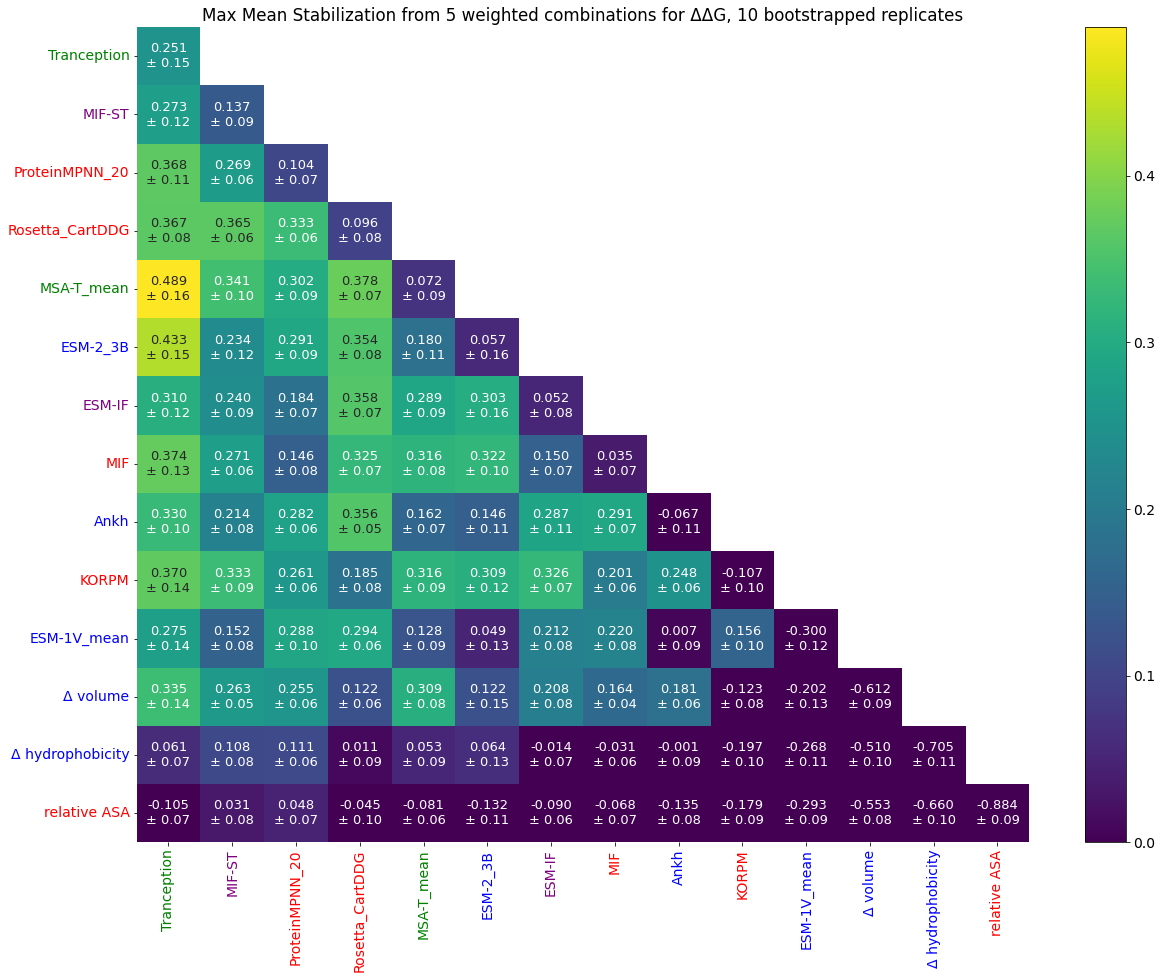

rank                    model1 weight1                    model2 weight2  \
0      1           tranception_dir       1  msa_transformer_mean_dir     0.2   
1      1           tranception_dir       1                  esm2_dir     0.2   
2      1           tranception_dir       1  msa_transformer_mean_dir     0.5   
3      1  msa_transformer_mean_dir       1         cartesian_ddg_dir       1   
4      1           tranception_dir       1                   mif_dir     0.2   
5      1           tranception_dir       1                 korpm_dir     0.2   
6      1           tranception_dir       1            mpnn_20_00_dir     0.2   
7      1           tranception_dir       1         cartesian_ddg_dir       1   
8      1         cartesian_ddg_dir       1                 mifst_dir     0.5   
9      1           tranception_dir       1         cartesian_ddg_dir     0.2   
10     1           tranception_dir       1         cartesian_ddg_dir     0.5   
11     1        esmif_multimer_dir       1         cartesian_ddg_dir       1   
12     1         cartesian_ddg_dir       1                  ankh_dir       1   
13     1         cartesian_ddg_dir       1                  esm2_dir     0.5   
14     1           tranception_dir       1                   mif_dir     0.5   
15     1                 mifst_dir       1         cartesian_ddg_dir       1   
16     1  msa_transformer_mean_dir       1                 mifst_dir       1   
17     1        esmif_multimer_dir       1         cartesian_ddg_dir     0.5   
18     1           tranception_dir       1             delta_vol_dir     0.2   
19     1                   mif_dir       1           tranception_dir       1   
20     1                 korpm_dir       1                 mifst_dir       1   
21     1         cartesian_ddg_dir       1            mpnn_20_00_dir     0.5   
22     1         cartesian_ddg_dir       1                  ankh_dir     0.5   
23     1           tranception_dir       1                  ankh_dir     0.5   
24     1         cartesian_ddg_dir       1           tranception_dir     0.5   
25     1           tranception_dir       1                  esm2_dir     0.5   
26     1        esmif_multimer_dir       1                 korpm_dir     0.5   
27     1         cartesian_ddg_dir       1                   mif_dir       1   
28     1         cartesian_ddg_dir       1                  ankh_dir     0.2   
29     1         cartesian_ddg_dir       1                  esm2_dir     0.2   

   mean_mean_stabilization   p_value  
0                 0.489196       0.0  
1                 0.432524  0.000002  
2                 0.417333  0.000168  
3                 0.377951  0.000005  
4                 0.374345  0.000295  
5                 0.369847  0.000034  
6                 0.368026  0.000787  
7                 0.366598  0.001846  
8                 0.365416  0.000051  
9                 0.363741  0.000908  
10                0.361784  0.014406  
11                0.358243  0.000035  
12                0.355528  0.000016  
13                0.353945  0.000001  
14                0.349431  0.008654  
15                0.343915  0.000002  
16                 0.34141  0.000009  
17                0.336027  0.000011  
18                0.334673  0.006466  
19                0.334025  0.039234  
20                 0.33306   0.00002  
21                0.332836  0.000002  
22                0.332482  0.000018  
23                0.330382  0.009115  
24                0.327288  0.175055  
25                0.326746  0.010939  
26                0.326008       0.0  
27                0.325218  0.000054  
28                0.324817  0.000022  
29                0.324417  0.000098

In [ ]:
# SUPPLEMENTARY FIGURE 9

measurement = 'ddG'
statistic = 'mean_stabilization'

stat_df, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm, db_measurements, statistic, measurement, n_bootstraps=10, threshold=0, custom_colors=custom_colors)
stat_df = stat_df.sort_values(f'mean_{statistic}', ascending=False).drop_duplicates(subset=['weight1', 'weight2', f'mean_{statistic}', 'p_value']).reset_index()
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1

#stat_df.to_csv('../../zs_suppl/model_combinations_ddG_mean_stab_nonneg.csv')
stat_df.head(30)

In [ ]:
# preprocessing for feature comparisons between datasets

db_feats_2['neff'] = db_feats_2['neff'].fillna(0)
fp_feats = db_feats_2
fp_feats['neff'] = fp_feats['neff'].fillna(0)
fp_feats['rel_ASA']

db = pd.read_csv(os.path.join(path, 'data', 's669_mapped.csv'))

db['uid2'] = db['code'] + '_' + (db['position'].astype(int) - db['offset_up'].astype(int)).astype(str) + db['mutation'].str[-1]
db = db.set_index(['uid', 'uid2'])

cols = db.columns
drop = [col for col in db.columns if 'Unnamed' in col]
drop += [col for col in db.columns if 'pdb' in col]
drop += [col for col in db.columns if 'offset' in col]

db_full = db.copy(deep=True)
db_full['uid3'] = db['code'] + '_' + db['PDB_Mut'].str[1:]
db_full = db_full.reset_index().set_index('uid3')

s461 = pd.read_csv(os.path.join(path, 'data', 'S461.csv'))
s461['uid3'] = s461['PDB'] + '_' + s461['MUT_D'].str[2:]
s461 = s461.set_index('uid3')
s461['ddG_I'] = -s461['ddG_D']

s461.columns = [s+'_dir' for s in s461.columns]
s461 = s461.rename({'ddG_D_dir': 'ddG_dir', 'ddG_I_dir': 'ddG_inv'}, axis=1)


db = s461.join(db_full, how='left').reset_index(drop=True).set_index(['uid', 'uid2'])
#db.to_csv(os.path.join(path, '..', 'S461_joined.csv'))
db = db.drop(drop, axis=1)
db = db.drop(['PDB_dir', 'MUT_D_dir'], axis=1)

s669_combined = db.copy(deep=True).reset_index()
s669_combined = s669_combined.set_index('uid').drop(['multimer', 'nmr_xray', 'pH', 'resolution', 'wild_type'], axis=1)

neff = pd.read_csv(os.path.join(path, 'data', 'neff_s669.csv'), header=None).set_index(0)
neff.index.name = 'code'
neff.columns = ['neff']

s669_feats = pd.read_csv(os.path.join(path, 'data', 's669_mapped_feats.csv'))
s669_feats['uid'] = s669_feats['code'] + '_' + s669_feats['position'].astype(str) + s669_feats['mutation']
s669_feats = s669_feats[['uid', 'wild_type', 'on_interface', 'entropy', 'conservation', 'column_completeness', 'completeness_score', 'n_seqs', 'structure_length', 'multimer', 'SS',
                        'features', 'hbonds', 'saltbrs', 'b_factor', 'kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'rel_ASA', 'nmr_xray', 'pH', 'resolution']] # 'residue_depth',

s669_feats['on_interface'] = s669_feats['on_interface'].astype(int)
s669_feats['features'] = s669_feats['features'].fillna("")#.apply(list)
#s669_combined = s669_combined.join(ddgs)
s669_combined = s669_combined.join(s669_feats.set_index('uid')).drop('code', axis=1)
s669_combined['delta_kdh'] = s669_combined['kdh_mut'] - s669_combined['kdh_wt']
s669_combined['delta_vol'] = s669_combined['vol_mut'] - s669_combined['vol_wt']
s669_combined['delta_chg'] = s669_combined['chg_mut'] - s669_combined['chg_wt']
s669_combined['delta_asa'] = s669_combined['SOL_ACC_inv'] - s669_combined['SOL_ACC_dir']
s669_combined['to_proline'] = (s669_combined.index.str[-1] == 'P').astype(int)
s669_combined['to_glycine'] = (s669_combined.index.str[-1] == 'G').astype(int)
s669_combined['from_proline'] = s669_combined['wild_type'] == 'P'
s669_combined['from_glycine'] = s669_combined['wild_type'] == 'G'
s669_combined['helix'] = s669_combined['SS'] == 'H'
s669_combined['bend'] = s669_combined['SS'] == 'S'
s669_combined['turn'] = s669_combined['SS'] == 'T'
s669_combined['coil'] = s669_combined['SS'] == '-'
s669_combined['strand'] = s669_combined['SS'] == 'E'
s669_combined['xray_else_NMR'] = s669_combined['nmr_xray'].str.contains('X-RAY')
s669_combined['active_site'] = s669_combined['features'].str.contains('ACT_SITE')
s669_combined['resolution'] = s669_combined['resolution'].fillna('').apply(lambda x: analysis_utils.extract_decimal_number(x))

s669_combined = s669_combined.drop(['kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'features', 'SS', 'wild_type', 'nmr_xray'], axis=1)

s669_combined['code'] = s669_combined.index.str[:4]
s669_combined = s669_combined.reset_index().merge(neff['neff'].dropna(), on='code', how='left')#.drop('code', axis=1)#.set_index('uid')
s669_combined['neff'] = s669_combined['neff'].fillna(0)
unique_indices = s669_combined.groupby('uid')['neff'].idxmax()#.astype(int)
s669_combined = s669_combined.loc[unique_indices].set_index('uid')

s669_combined['random_dir'] = np.random.rand(len(s669_combined)) - 0.5
s669_combined['random_inv'] = np.random.rand(len(s669_combined)) - 0.5
s669_combined = s669_combined.rename({'ddG_dir': 'ddG'}, axis=1)

s461_feats = s669_combined
s461_feats['rel_ASA']

uid
1A0F_11A     0.000000
1BA3_457D    0.190217
1BA3_485D    1.000000
1BA3_485K    1.000000
1BA3_485M    1.000000
               ...   
4HE7_19G     0.764151
4HE7_19K     0.764151
5JXB_25G     0.975460
5JXB_25P     0.975460
5OAQ_199H    0.004505
Name: rel_ASA, Length: 461, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def compare_distributions_violin(df1, df2):
    remap_names = {'delta_chg': 'Δ charge', 'delta_vol': 'Δ volume', 'hbonds': 'wt hydrogen bonds', 
                    'multimer': 'chains in assembly', 'neff': 'n effective sequences', 'b_factor': 'beta factor',
                    'rel_ASA': 'SASA', 'delta_kdh': 'Δ hydrophobicity', 'ddG': 'ΔΔG', 'structure_length': 'n residues', 
                    'completeness_score': 'alignment completeness'}

    # Identify shared columns
    shared_columns = set(df1.columns).intersection(df2.columns)
    print(shared_columns)

    # Exclude boolean columns
    shared_columns = [col for col in shared_columns if df1[col].dtype != 'bool' and df2[col].dtype != 'bool']

    # Create a combined dataframe with an extra column to indicate the source dataframe
    df1_copy = df1[shared_columns].copy()
    df1_copy['source'] = 'FireProtDB'

    df2_copy = df2[shared_columns].copy()
    df2_copy['source'] = 'S461'

    combined_df = pd.concat([df1_copy, df2_copy])

    # Apply Min-Max Scaling
    scaler = MinMaxScaler()
    combined_df[shared_columns] = scaler.fit_transform(combined_df[shared_columns])

    # Melt the dataframe to long format for plotting
    melted_df = combined_df.melt(id_vars='source', value_vars=shared_columns)

    # Plot a violin plot for each shared column
    plt.figure(figsize=(20, 10))
    ax = sns.violinplot(x='variable', y='value', hue='source', split=True, data=melted_df, bw=0.05)

    for i, col in enumerate(shared_columns):
        # Calculate medians before transformation
        median_df1 = df1[col].median()
        median_df2 = df2[col].median()

        # Normalize column
        combined_col = pd.concat([df1[[col]], df2[[col]]])
        combined_col_scaled = scaler.fit_transform(combined_col)

        # Create DataFrame for violin plot
        violin_df = pd.DataFrame({
            'Column': [i]*len(combined_col),  # replace column name with numeric value
            'Value': combined_col_scaled.flatten(),
            'Source': ['df1']*len(df1) + ['df2']*len(df2)
        })

        # Plot violin
        #sns.violinplot(x='Column', y='Value', hue='Source', data=violin_df, split=True, inner=None, ax=ax)

        # Plot median markers
        median_df1_scaled = scaler.transform([[median_df1]])[0, 0]
        median_df2_scaled = scaler.transform([[median_df2]])[0, 0]
        plt.plot([i-0.2, i], [median_df1_scaled, median_df1_scaled], color='blue', linestyle='dashed')
        plt.plot([i, i+0.2], [median_df2_scaled, median_df2_scaled], color='red', linestyle='dashed')

        # Annotate median markers
        ax.text(i-0.6, median_df1_scaled, f'{median_df1:.2f}', color='blue', va='center', fontsize=10)
        ax.text(i+0.3, median_df2_scaled, f'{median_df2:.2f}', color='red', va='center', fontsize=10)

    remapped_x = [remap_names[tick.get_text()] if tick.get_text() in remap_names.keys() else tick.get_text() for tick in ax.get_xticklabels()]
    ax.set_xticklabels(remapped_x)

    plt.title('Feature Distribution for each Dataset')
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Normalized Value')
    plt.show()


{'completeness_score', 'rel_ASA', 'is_nmr', 'bend', 'from_glycine', 'multimer', 'to_proline', 'neff', 'delta_vol', 'to_glycine', 'from_proline', 'strand', 'hbonds', 'helix', 'b_factor', 'pH', 'coil', 'conservation', 'entropy', 'structure_length', 'delta_kdh', 'delta_chg', 'active_site', 'turn'}


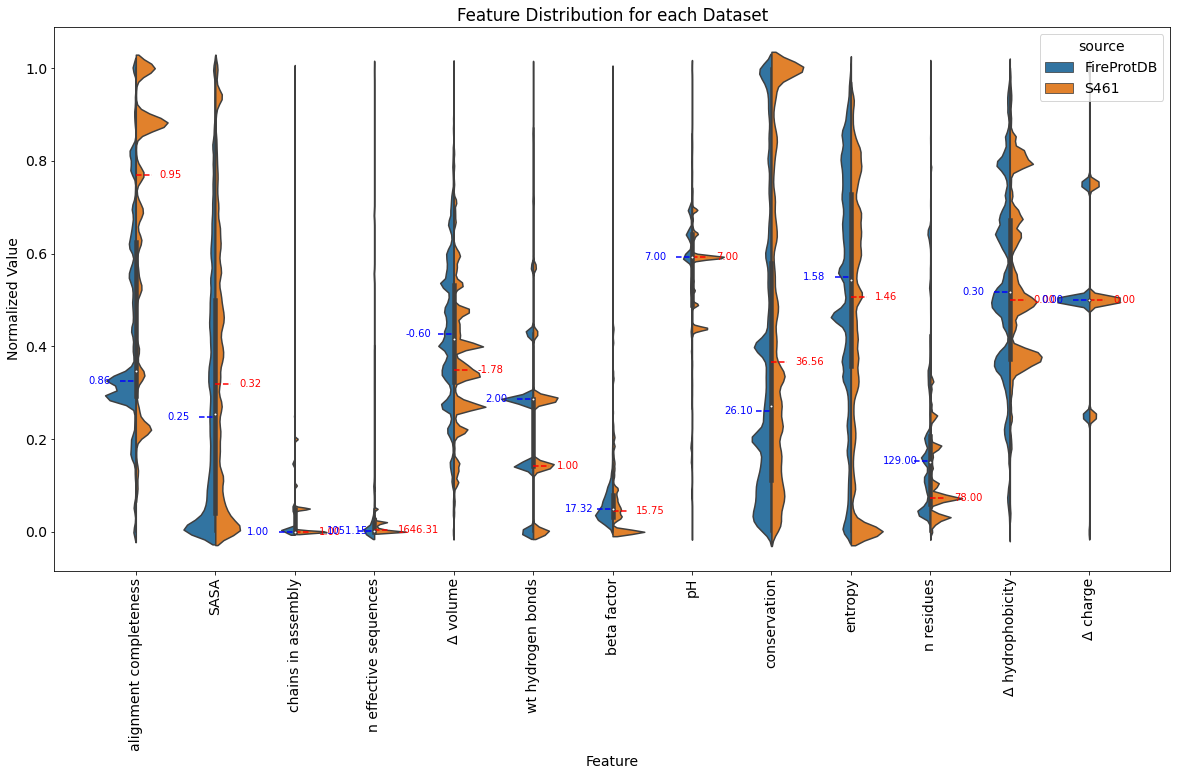

In [ ]:
# SUPPLEMENTARY FIGURE 10

compare_distributions_violin(fp_feats.drop(['n_seqs', 'on_interface', 'column_completeness', 'saltbrs'], axis=1), s461_feats)

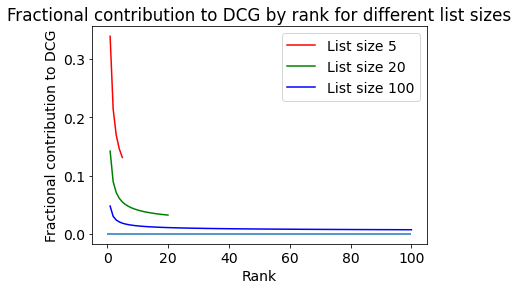

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def fractional_contributions(list_size, base=2):
    ranks = np.arange(1, list_size+1)
    discounts = 1 / np.log2(ranks + 1)  # compute the discount for each rank
    return discounts / np.sum(discounts)  # normalize to get fractional contributions

list_sizes = [5, 20, 100]
colors = ['r', 'g', 'b']

for i, list_size in enumerate(list_sizes):
    fractions = fractional_contributions(list_size)
    plt.plot(np.arange(1, list_size+1), fractions, color=colors[i], label=f'List size {list_size}')

plt.xlabel('Rank')
plt.ylabel('Fractional contribution to DCG')
plt.title('Fractional contribution to DCG by rank for different list sizes')
plt.hlines(0, 0, 100)
plt.legend()
plt.show()

In [ ]:
# The following cells are extra analyses not included in the paper

In [ ]:
custom_colors = {#'cartesian_ddg_dir + esmif_multimer_dir * 0.5': 'black',
                 #'mpnn_20_00_dir + esmif_multimer_dir * 1': 'black',
                 'cartesian_ddg_dir': 'red',
                 #'monomer_ddg_dir': 'red',
                 'korpm_dir': 'red',
                 'esm1v_mean_dir': 'blue',
                 'msa_transformer_mean_dir': 'green',
                 #'msa_transformer_median_dir': 'green',
                 'tranception_dir': 'green',
                 #'tranception_dir': 'green',
                 #'esmif_monomer_dir': 'red',
                 #'esmif_multimer_dir': 'red',
                 'esmif_multimer_dir': 'red',
                 #'esmif_monomer_masked_dir': 'red',
                 'mpnn_mean_dir': 'red',
                 #'mpnn_10_00_dir': 'red',
                 #'mpnn_20_00_dir': 'red',
                 #'mpnn_20_mean_dir': 'red',
                 #'mpnn_30_noise_dir': 'red',
                 #'mpnn_20_02_dir': 'red',
                 #'mpnn_30_03_dir': 'red',
                 #'mpnn_30_03_dir': 'red',
                 'mif_dir': 'red',
                 'mifst_dir': 'purple',
                 'ddG_dir': 'grey',
                 'mpnn_mean_dir + cartesian_ddg_dir * 1': 'red',
                 'mpnn_mean_dir + korpm_dir * 1': 'red'}

db_complete = db_preds.join(db_measurements, how='left').drop(['ProTherm', 'FireProt', 'is_curated', 'ThermoFluor'], axis=1).join(db_feats_2, how='left').drop_duplicates().drop('code', axis=1).dropna(subset='korpm_dir').dropna(subset='msa_transformer_mean_dir')
db_complete = dfm.drop('code', axis=1)[list(custom_colors.keys())+['ddG', 'dTm']]
analysis_utils.compute_stats(db_complete, stats=('n', 'mean_stabilization', 'pred_positives'), measurements=['ddG', 'dTm']).drop('runtime', axis=1)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

n  \
measurement model_type   model                                 class           
dTm         NaN          ddG_dir                                      1554.0   
            evolutionary esm1v_mean_dir                               2788.0   
                         msa_transformer_mean_dir                     2788.0   
                         tranception_dir                              2788.0   
            structural   cartesian_ddg_dir                            2788.0   
                         esmif_multimer_dir                           2788.0   
                         korpm_dir                                    2788.0   
                         mif_dir                                      2788.0   
                         mifst_dir                                    2788.0   
                         mpnn_mean_dir                                2788.0   
                         mpnn_mean_dir + cartesian_ddg_dir * 1        2788.0   
                         mpnn_mean_dir + korpm_dir * 1                2788.0   
ddG         NaN          ddG_dir                                      5043.0   
            evolutionary esm1v_mean_dir                               5043.0   
                         msa_transformer_mean_dir                     5043.0   
                         tranception_dir                              5043.0   
            structural   cartesian_ddg_dir                            5043.0   
                         esmif_multimer_dir                           5043.0   
                         korpm_dir                                    5043.0   
                         mif_dir                                      5043.0   
                         mifst_dir                                    5043.0   
                         mpnn_mean_dir                                5043.0   
                         mpnn_mean_dir + cartesian_ddg_dir * 1        5043.0   
                         mpnn_mean_dir + korpm_dir * 1                5043.0   

                                                                      pred_positives  \
measurement model_type   model                                 class                   
dTm         NaN          ddG_dir                                               428.0   
            evolutionary esm1v_mean_dir                                        545.0   
                         msa_transformer_mean_dir                              346.0   
                         tranception_dir                                       352.0   
            structural   cartesian_ddg_dir                                     888.0   
                         esmif_multimer_dir                                    392.0   
                         korpm_dir                                             925.0   
                         mif_dir                                               562.0   
                         mifst_dir                                             431.0   
                         mpnn_mean_dir                                         548.0   
                         mpnn_mean_dir + cartesian_ddg_dir * 1                 571.0   
                         mpnn_mean_dir + korpm_dir * 1                         562.0   
ddG         NaN          ddG_dir                                              1371.0   
            evolutionary esm1v_mean_dir                                        558.0   
                         msa_transformer_mean_dir                              213.0   
                         tranception_dir                                       171.0   
            structural   cartesian_ddg_dir                                    1034.0   
                         esmif_multimer_dir                                    512.0   
                         korpm_dir                                            1314.0   
                         mif_dir                                               701.0   
                         mifst_dir                        

Average prediction for stabilized protein: -0.49609476646840933
Average experimental value for predicted stabilized: 0.3340901360544218


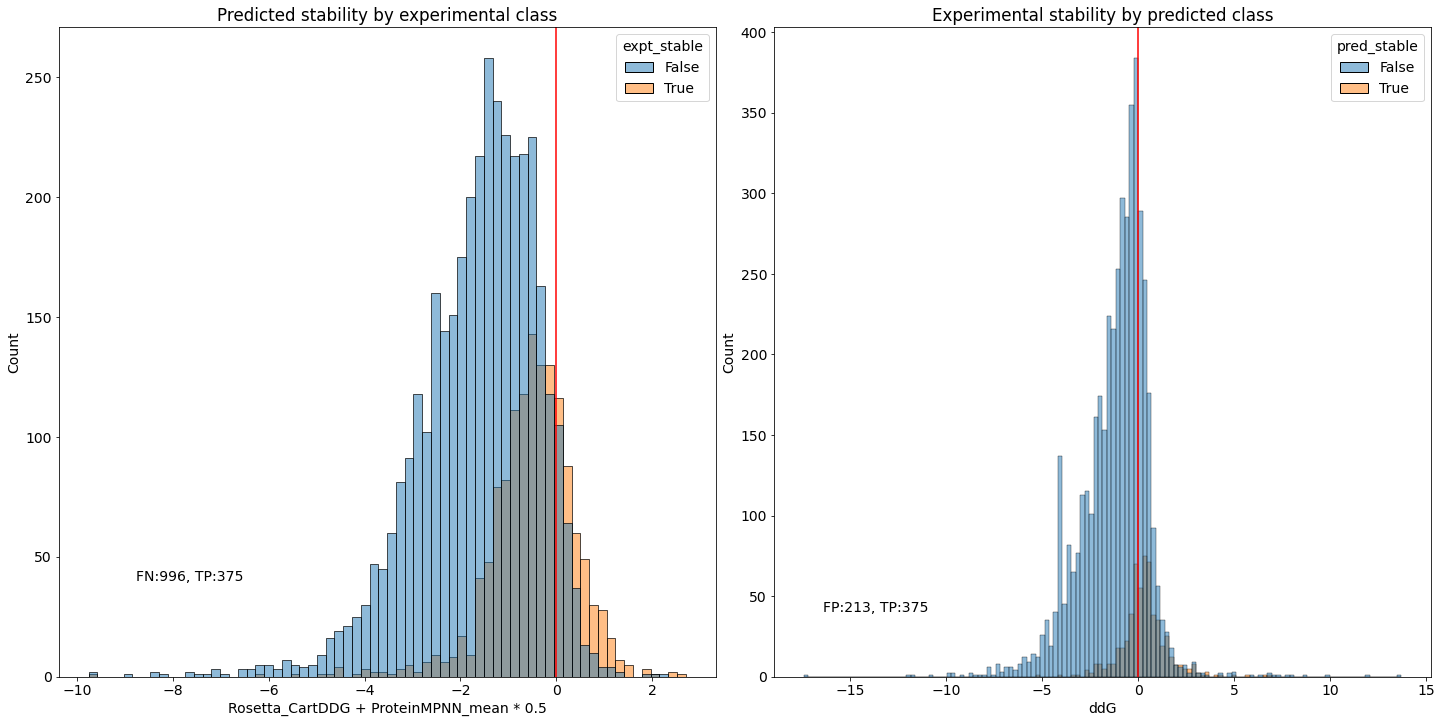

n_expt_stable                          1371.000000
P(pred_stable|stable) - sensitivity       0.273523
P(pred_stable|unstable) - FPR             0.058007
n_pred_stable                           588.000000
P(stable|pred_stable) - PPV               0.670068
P(stable|pred_unstable) - FOR             0.237486
dtype: float64

In [ ]:
def compare_stable_dists(db_complete, score_name, decision_threshold_ddg=0, decision_threshold_score=0, x_label_1=None):

    dbf = db_complete.copy(deep=True)
    dbf = dbf.loc[:, [score_name, 'ddG']]
    min_score = dbf[score_name].min() + 1
    min_ddg = dbf['ddG'].min() + 1

    # todo: add dTm
    df_out = pd.Series(index = ['n_expt_stable', 'P(pred_stable|stable) - sensitivity', 'P(pred_stable|unstable) - FPR',\
                                 'n_pred_stable', 'P(stable|pred_stable) - PPV', 'P(stable|pred_unstable) - FOR'], dtype=float)
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    #fig.suptitle(score_name)
    axs[0].set_title(f'Predicted stability by experimental class')
    axs[1].set_title(f'Experimental stability by predicted class')

    stable = dbf.loc[dbf['ddG'] > decision_threshold_ddg, :].dropna().copy()
    stable['expt_stable'] = True
    unstable = dbf.loc[dbf['ddG'] <= decision_threshold_ddg, :].dropna().copy()
    unstable['expt_stable'] = False
    to_plot = pd.concat([stable, unstable])

    df_out['n_expt_stable'] = len(stable)
    df_out['P(pred_stable|stable) - sensitivity'] = len(stable.loc[stable[score_name] >= decision_threshold_score]) / len(stable)
    df_out['P(pred_stable|unstable) - FPR'] = len(unstable.loc[unstable[score_name] >= decision_threshold_score]) / len(unstable)

    left = len(stable.loc[stable[score_name] <= decision_threshold_score])
    right = len(stable.loc[stable[score_name] > decision_threshold_score])
    sns.histplot(ax=axs[0], data=to_plot, x=score_name, hue='expt_stable')
    axs[0].annotate(f'FN:{left}, TP:{right}', xy=(min_score,40))
    axs[0].axvline(x = decision_threshold_score, color = 'r', label = 'axvline - full height')
    axs[0].set_xlabel(x_label_1)

    avg = stable[score_name].mean()
    print('Average prediction for stabilized protein:', avg)

    predicted_stable = dbf.loc[dbf[score_name] > decision_threshold_score, :].dropna().copy()
    predicted_stable['pred_stable'] = True
    predicted_unstable = dbf.loc[dbf[score_name] <= decision_threshold_score, :].dropna().copy()
    predicted_unstable['pred_stable'] = False
    to_plot = pd.concat([predicted_stable, predicted_unstable])

    df_out['n_pred_stable'] = len(predicted_stable)
    df_out['P(stable|pred_stable) - PPV'] = len(predicted_stable.loc[predicted_stable['ddG'] >= decision_threshold_ddg]) / len(predicted_stable)
    df_out['P(stable|pred_unstable) - FOR'] = len(predicted_unstable.loc[predicted_unstable['ddG'] >= decision_threshold_ddg]) / len(predicted_unstable)
    
    left = len(predicted_stable.loc[predicted_stable['ddG'] <= decision_threshold_ddg])
    right = len(predicted_stable.loc[predicted_stable['ddG'] > decision_threshold_ddg])
    sns.histplot(ax=axs[1], data=to_plot, x='ddG', hue='pred_stable')
    axs[1].annotate(f'FP:{left}, TP:{right}', xy=(min_ddg,40))
    axs[1].axvline(x = decision_threshold_ddg, color = 'r', label = 'axvline - full height')

    avg = predicted_stable['ddG'].mean()
    print('Average experimental value for predicted stabilized:', avg)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

    return df_out

s = dfm.drop(['ProTherm', 'FireProt', 'ThermoFluor'], axis=1).drop_duplicates().drop('code', axis=1).dropna(subset='korpm_dir') #.join(db_feats_2, how='left')
compare_stable_dists(s, 'cartesian_ddg_dir + mpnn_mean_dir * 0.5', decision_threshold_ddg=0, decision_threshold_score=0, x_label_1='Rosetta_CartDDG + ProteinMPNN_mean * 0.5')